# Bare minimum 

## imports

In [1]:
import pandas as pd
from tqdm import tqdm
import random
from matplotlib import pyplot as plt 
import numpy as np
from datetime import timedelta
import squarify
import openpyxl 
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd


# Add this line to remove column width limit

## Data Ingestion

In [2]:
df_ema = pd.read_parquet('../data_ema/csv_processed.parquet')
df_questionnaires = pd.read_excel('../data_questionnaire/2023006_COBRA_20230811.xlsx')
df_id_mapping = pd.read_excel('../data_ema/COBRA ID Mapping for Roman.xlsx')
pd.set_option('display.max_columns', None)

#### Joining the two dataframes

In [3]:
df_ema = df_ema.merge(df_id_mapping[['ID - Ethica EMA', 'Subject_ID_Roman']], 
                    left_on='ID - Ethica EMA', 
                    right_on='ID - Ethica EMA', 
                    how='left')

In [4]:
df_questionnaires.head()

SubjectID  Int_Age  Gender  Derived_Race RaceOthers  a2 a2others  a3  \
0  2023006-00529A       36       2             1        NaN   1      NaN   8   
1  2023006-00023A       53       1             1        NaN   1      NaN   2   
2  2023006-00249A       58       1             1        NaN   1      NaN   2   
3  2023006-00068A       30       2             1        NaN   1      NaN   2   
4  2023006-00615A       28       2             1        NaN   1      NaN   2   

   a4  a5  a5_999  a6  a6_999  a7 a7others  a8 a8others  i1  i2  i3  i4  i41  \
0   1   1       0   1       0   1      NaN   1      NaN   1   5   2   2  4.0   
1   1  46       0   2       0   1      NaN   1      NaN   5   6   3   1  4.0   
2   1   1       0   1       0   1      NaN   1      NaN   2   7   2   2  4.0   
3   2   2       0   2       0   1      NaN   1      NaN   1   7   3   2  4.0   
4   2   2       0   2       0   1      NaN   1      NaN   2   7   1   2  6.0   

    i42  i43  i44  i5  i6  i7                           i7oth  i8  i9  i10  \
0   4.0  2.0  NaN   4   2   4                             NaN   1   2    0   
1  10.0  2.0  NaN   2   1   4                             NaN   2   0    1   
2   2.0  2.0  NaN   5   1   5                             NaN   1   5    0   
3  10.0  2.0  NaN   2   2   8  Rent a room in a private house   2   0    0   
4   5.0  2.0  NaN   5   2   3                             NaN   2   1    0   

   i11  i12  i13  i141  i142  i143  i144  i145  i14_none  i15a  i15b  i15c  \
0    2    2    4     2     2     2     2     2       NaN     6     6     6   
1    2    2    5     1     1     1     1     2       NaN     5     5     5   
2    1    2    4     1     1     2     2     2       NaN     6     6     6   
3    2    2    5     2     2     2     2     2       NaN     6     6     4   
4    2    2    3     2     1     2     2     2       NaN     7     7     7   

   i15d  i15e  i15f  i15g  i15h  i15i  i15j  i15k  i15l  c1  c2  c2a  c3  \
0     5     4     4     4     5     5     5     5     5   2 NaN  NaN NaN   
1     5     5     5     5     5     5     5     5     5   2 NaN  NaN NaN   
2     6     6     6     6     6     6     6     6     6   2 NaN  NaN NaN   
3     4     7     7     7     4     7     6     4     6   2 NaN  NaN NaN   
4     7     7     4     4     7     7     7     7     7   2 NaN  NaN NaN   

   c4age  c5age  c6  c7  c8  c9  c10  b1  b2a  b2b  b3  b4  b5  
0    NaN    NaN NaN NaN NaN NaN  1.0   2  2.0  NaN NaN NaN NaN  
1    NaN    NaN NaN NaN NaN NaN  1.0   1  NaN  NaN NaN NaN NaN  
2    NaN    NaN NaN NaN NaN NaN  2.0   1  NaN  NaN NaN NaN NaN  
3    NaN    NaN NaN NaN NaN NaN  1.0   1  NaN  NaN NaN NaN NaN  
4    NaN    NaN NaN NaN NaN NaN  2.0   1  NaN  NaN NaN NaN NaN

In [5]:
questionnaires_unique = df_questionnaires['SubjectID'].unique()
len(questionnaires_unique)

694

In [6]:
ema_unique = df_ema['Subject_ID_Roman'].unique()
len(ema_unique)

692

In [7]:
# Find values unique to each dataframe
unique_to_questionnaires = set(questionnaires_unique) - set(ema_unique)
unique_to_ema = set(ema_unique) - set(questionnaires_unique)

# Print values unique to each dataframe
print("Values unique to df_questionnaires:")
print(unique_to_questionnaires)

print("\nValues unique to df_ema:")
print(unique_to_ema)

Values unique to df_questionnaires:
{'2023006-00405A', '2023006-00122A'}

Values unique to df_ema:
set()


In [8]:
# MOve the subject ID to the left side of the dataframe
subject_id_roman = df_ema['Subject_ID_Roman']

# Drop the "Subject_ID_Roman" column from the original DataFrame
df_ema = df_ema.drop('Subject_ID_Roman', axis=1)

# Insert the "Subject_ID_Roman" column at the beginning (left) of the DataFrame
df_ema.insert(0, 'Subject_ID_Roman', subject_id_roman)


##### Merge with the questionnaires dataframe

In [9]:
df_ema = df_ema.merge(df_id_mapping[['ID - Ethica EMA', 'Subject_ID_Roman']], 
                    left_on='ID - Ethica EMA', 
                    right_on='ID - Ethica EMA', 
                    how='left')

#### Create initial index to join together with the independent variables

In [10]:
df_ema['initial_index_targets'] = range(len(df_ema))

## Filter out a single participant (ignore this section if you want to work with all participants)

In [11]:
# unique_values = df_ema['Subject_ID_Roman_x'].unique()

# # Randomly choose one value from the unique values
# chosen_value = random.choice(unique_values)

# # Filter out all rows with the chosen value
# single_participant = df_ema[df_ema['Subject_ID_Roman_x'] == chosen_value]

# # The filtered_df will now contain all rows with a different value in the "Subject_ID_Roman_x" column.
# single_participant.head(20)

# df_ema=single_participant.copy()

#### Add new outcome features to the dataframe

Enable the cell below as well to run everything

In [12]:
# Split the string to remove the time zone
df_ema['Scheduled Time'] = df_ema['Scheduled Time'].str.split().str[:-1].str.join(' ')

# Convert the column to datetime
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'], format="%Y-%m-%d %H:%M:%S")


# Split the string to remove the time zone
df_ema['Issued Time'] = df_ema['Issued Time'].str.split().str[:-1].str.join(' ')

# Convert the column to datetime
df_ema['Issued Time'] = pd.to_datetime(df_ema['Issued Time'], format="%Y-%m-%d %H:%M:%S")


# Split the string to remove the time zone
df_ema['Response Time'] = df_ema['Response Time'].str.split().str[:-1].str.join(' ')

# Convert the column to datetime
df_ema['Response Time'] = pd.to_datetime(df_ema['Response Time'], format="%Y-%m-%d %H:%M:%S")

In [13]:
df_ema.head()

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00146A            47144  4D7296C6632540CEB41546939C8F3EA2   
1     2023006-00402A            47145  EC77B6EAED3341A088011364EFEFCD34   
2     2023006-00508A            47636                  b5d6b06e3e3283eb   
3     2023006-00116A            73429  B6ED4A2888CB438F82242F3D37714572   
4     2023006-00047A            48497  F321464C7BFC4197934E5628C7F0E2B8   

       Scheduled Time         Issued Time       Response Time  \
0 2022-01-21 20:32:54 2022-01-21 20:32:54 2022-01-21 20:39:55   
1 2022-01-21 21:11:32 2022-01-21 21:11:32 2022-01-21 21:25:09   
2 2022-01-24 20:48:15 2022-01-24 20:58:15 2022-01-24 21:09:25   
3 2023-06-29 21:19:41 2023-06-29 21:19:41 2023-06-29 21:22:54   
4 2022-02-14 20:30:36 2022-02-14 20:30:36 2022-02-14 21:30:36   

  Duration (seconds) from scheduled to completion time  \
0                                            421.367     
1                                            817.508     
2                                           1270.898     
3                                            193.953     
4                                            Expired     

  Duration (seconds) from first response to completion time  \
0                                                 59          
1                                                227          
2                                                 31          
3                                                183          
4                                            Unknown          

              Location [2_MAQ_1] eating/drinking (other than water)  \
0  1.321510 103.885419                                         True   
1  1.289592 103.829555                                         True   
2  1.341625 103.739039                                         None   
3  1.429330 103.851446                                         True   
4                 None                                         None   

  [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
0                      None                        None   
1                      None                        None   
2                      None                        None   
3                      None                        None   
4                      None                        None   

  [2_MAQ_4] resting/sleeping\r  \
0                         None   
1                         None   
2                         None   
3                         None   
4                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         
1                                               None         
2                                               None         
3                                               True         
4                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   
1                None            None                       None   
2                None            None                       None   
3                None            None                       None   
4                None            None                       None   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   
1                                        None                 None   
2                                        None                 None   
3                                        None                 None   
4                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   
1               None                           None   
2               None                           True   
3               None  

#### Correct two time stamp errors:

Thoss two rows above have minor errors: 
1) In the row with index 2902, the date in the response time column is the 2022-04-29 21:37:05instead of the 2022-04-28 21:37:05. Therefore, we recalculate the response time here to account for this.Recalculated, this should be 2028 seconds.
2) In the row with the index 27418, the response delay should actually be 373 seconds, therefore the stamp should be 15:55:28

--> Therefore I replace thos values in the response time column

In [14]:
selected_rows = df_ema.loc[[2902, 27418]]
selected_rows.head()


Subject_ID_Roman_x  ID - Ethica EMA         Device ID  \
2902      2023006-00157A            53585  9adf7ef7a7052003   
27418     2023006-00338A            59573  1b6b4067afe09d7d   

           Scheduled Time         Issued Time       Response Time  \
2902  2022-04-29 20:53:17 2022-04-29 21:03:17 2022-04-28 21:37:05   
27418 2022-09-02 15:49:16 2023-09-02 04:43:01 2022-09-02 15:55:41   

      Duration (seconds) from scheduled to completion time  \
2902                                           -83771.58     
27418                                            385.707     

      Duration (seconds) from first response to completion time  \
2902                                                 119          
27418                                                 12          

                  Location [2_MAQ_1] eating/drinking (other than water)  \
2902   1.374927 103.960836                                         True   
27418  1.358577 103.748388                                         None   

      [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
2902                       None                        None   
27418                      None                        None   

      [2_MAQ_4] resting/sleeping\r  \
2902                          None   
27418                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
2902                                                True         
27418                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
2902                 None            None                       None   
27418                None            None                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
2902                                         None                 None   
27418                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
2902                None                           None   
27418               None                           True   

      [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
2902                           None                    None           True   
27418                          None                    None           None   

      [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
2902                      None            True         None   
27418                     None            None         None   

      [5_CAL]  What time did you eat your meal?  \
2902                             0/1/1900 20:35   
27418                                      None   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
2902                                               True   
27418                                              None   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
2902                                                None             
27418                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
2902                         True                True   
27418                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
2902                                                None        
27418                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
2902                                        None                 None   
27418                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
2902              None                               None   
27418             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
2902                                                None    

In [15]:
df_ema.at[2902, 'Response Time'] = '2022-04-20 21:37:05'  
df_ema.at[2902, 'Duration (seconds) from scheduled to completion time'] = 2628  # Update Duration (seconds)
df_ema.at[27418, 'Issued Time'] = '2022-09-02 15:55:28'  


#### Back to before

In [16]:
df_ema['Issued_minus_scheduled_time'] = (df_ema['Issued Time'] - df_ema['Scheduled Time']).dt.total_seconds()
filtered_df = df_ema[df_ema['Issued_minus_scheduled_time'] > 1.0]


In [17]:
df_ema.head(220).tail(10)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
210     2023006-00340A            73343  66579617F7ED4E6A88A3A078D4CA0E0E   
211     2023006-00201A            55843                  afe055a76fe1b6a3   
212     2023006-00293A            55916                  53b83edf4d3fa58f   
213     2023006-00462A            73342  29946F42D77F48E8A8920BB089B05009   
214     2023006-00436A            55922                  be2e1a1624be4669   
215     2023006-00183A            63262                  e49c86276439cc7e   
216     2023006-00545A            56052  6176624E99D0410C9C1358D1D942F1AA   
217     2023006-00431A            56054                              None   
218     2023006-00530A            56120  E54139591F9A47EAB5ACC525725A4710   
219     2023006-00349A            56124                  217f612fd2e87a0f   

         Scheduled Time         Issued Time       Response Time  \
210 2023-06-25 21:28:34 2023-06-25 21:28:34 2023-06-25 21:48:41   
211 2022-06-05 21:11:44 2022-06-05 21:21:44 2022-06-05 21:32:13   
212 2022-06-06 20:39:24 2022-06-06 20:49:24 2022-06-06 20:50:27   
213 2023-06-25 21:01:05 2023-06-25 21:01:05 2023-06-25 21:01:32   
214 2022-06-06 20:57:08 2022-06-06 20:57:08 2022-06-06 21:24:06   
215 2022-11-21 21:03:11 2022-11-21 21:03:11 2022-11-21 21:08:01   
216 2022-06-08 21:08:01 2022-06-08 21:08:01 2022-06-08 21:18:40   
217 2022-06-08 20:35:15                 NaT                 NaT   
218 2022-06-09 21:06:19 2022-06-09 21:06:19 2022-06-09 21:27:59   
219 2022-06-09 20:59:36 2022-06-09 20:59:36 2022-06-09 21:59:36   

    Duration (seconds) from scheduled to completion time  \
210                                           1207.806     
211                                           1229.664     
212                                            663.877     
213                                             27.031     
214                                           1618.887     
215                                            290.284     
216                                            639.013     
217                                            Expired     
218                                           1300.636     
219                                            Expired     

    Duration (seconds) from first response to completion time  \
210                                                 11          
211                                                420          
212                                                 49          
213                                                 21          
214                                                 62          
215                                                 30          
216                                                 23          
217                                            Unknown          
218                                                 48          
219                                            Unknown          

                Location [2_MAQ_1] eating/drinking (other than water)  \
210  1.454567 103.814180                                         None   
211  1.357176 103.871040                                         True   
212              Unknown                                         None   
213  1.454650 103.814217                                         None   
214  1.394528 103.914050                                         True   
215  1.348588 103.935423                                         None   
216  1.362839 103.851485                                         None   
217                 None                                         None   
218  1.333500 103.843967                                         None   
219                 None                                         None   

    [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
210                      None                        None   
211                      None                        None   
212                      None                        N

Enable cell below to run everything

In [18]:
non_zero_count = (df_ema['Issued_minus_scheduled_time'] > 1).sum()
non_zero_count

12700

In [19]:
# Count the number of rows with values between -1.5 and 10 (around 0)
count_around_0 = len(df_ema[(df_ema['Issued_minus_scheduled_time'] >= -1.5) & (df_ema['Issued_minus_scheduled_time'] <= 10)])

# Count the number of rows with values between 598.5 and 610
count_around_600 = len(df_ema[(df_ema['Issued_minus_scheduled_time'] >= 598.5) & (df_ema['Issued_minus_scheduled_time'] <= 610)])

# Count the number of rows with values between 1198.5 and 1210
count_around_1200 = len(df_ema[(df_ema['Issued_minus_scheduled_time'] >= 1198.5) & (df_ema['Issued_minus_scheduled_time'] <= 1210)])


# Count the number of rows with values between 1198.5 and 1210
count_around_1800 = len(df_ema[(df_ema['Issued_minus_scheduled_time'] >= 1798.5) & (df_ema['Issued_minus_scheduled_time'] <= 1810)])


# Count the number of rows with values between 1198.5 and 1210
count_around_2400 = len(df_ema[(df_ema['Issued_minus_scheduled_time'] >= 2398.5) & (df_ema['Issued_minus_scheduled_time'] <= 2410)])


print("Number of rows with values around 0 mins:", count_around_0)
print("Number of rows with values around 10 mins:", count_around_600)
print("Number of rows with values around 20 mins:", count_around_1200)
print("Number of rows with values around 30 mins:", count_around_1800)
print("Number of rows with values around 40 mins:", count_around_2400)



Number of rows with values around 0 mins: 24090
Number of rows with values around 10 mins: 12558
Number of rows with values around 20 mins: 15
Number of rows with values around 30 mins: 0
Number of rows with values around 40 mins: 1


In [20]:
len(df_ema)

37368

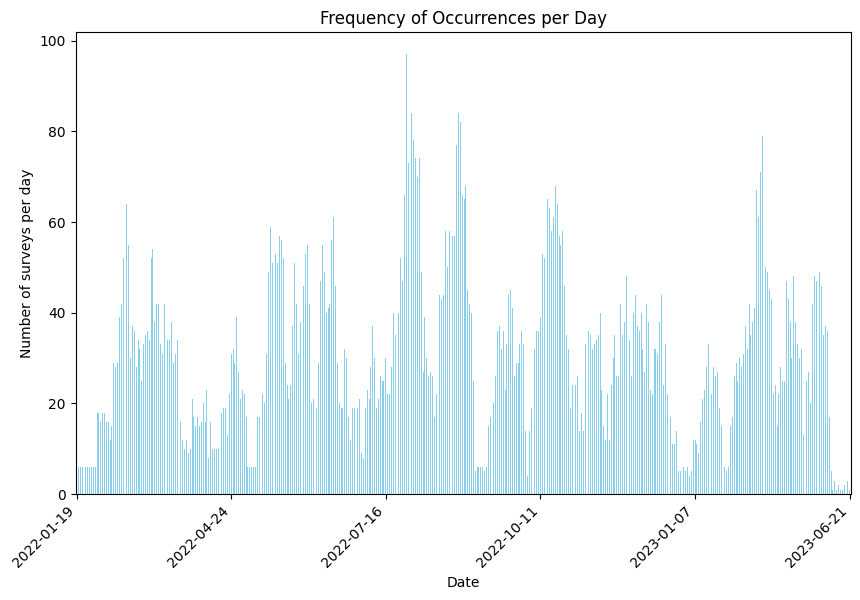

In [21]:
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'])
filtered_rows = df_ema[df_ema['Issued_minus_scheduled_time'] > 598.5]
daily_counts = filtered_rows.groupby(filtered_rows['Scheduled Time'].dt.date).size()

plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of surveys per day')
plt.title('Frequency of Occurrences per Day')

x_labels = daily_counts.index
plt.xticks(range(0, len(x_labels), max(1, len(x_labels) // 5)), x_labels[::max(1, len(x_labels) // 5)], rotation=45, ha='right')

plt.show()


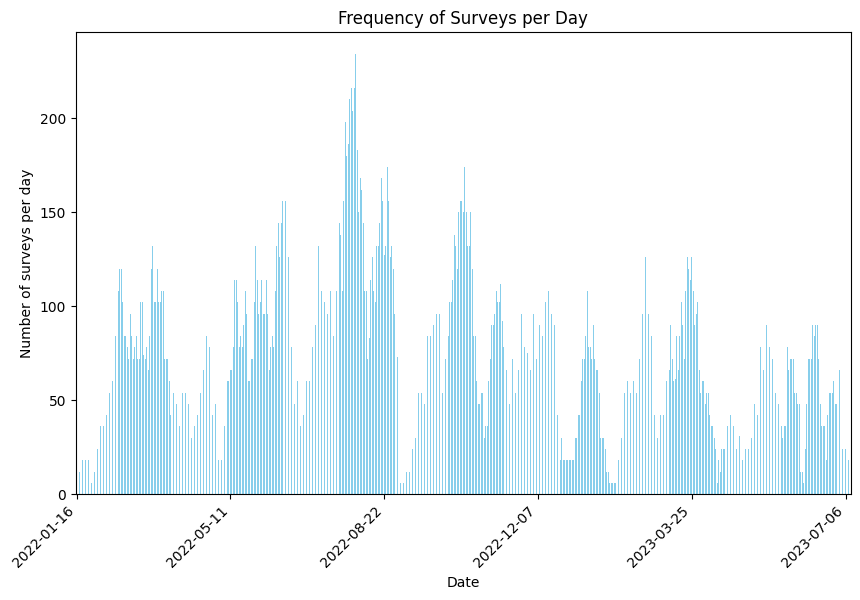

In [22]:
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'])

daily_counts = df_ema.groupby(df_ema['Scheduled Time'].dt.date).size()

# Plotting the frequency of occurrences per day
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of surveys per day')
plt.title('Frequency of Surveys per Day')

# Show only 5 x-axis labels
x_labels = daily_counts.index
plt.xticks(range(0, len(x_labels), max(1, len(x_labels) // 5)), x_labels[::max(1, len(x_labels) // 5)], rotation=45, ha='right')

plt.show()


In [23]:
# Assuming 'Scheduled Time' column is in datetime format
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'])

# Create a new DataFrame containing rows that satisfy the condition
filtered_rows = df_ema[df_ema['Issued_minus_scheduled_time'] > 598.5]


In [24]:
# Assuming 'Scheduled Time' column is in datetime format
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'])

# Create a new DataFrame containing rows that satisfy the condition
filtered_rows = df_ema[df_ema['Issued_minus_scheduled_time'] > 598.5]

# Sort the filtered DataFrame by 'Scheduled Time' in descending order and select the top 30 rows
recent_rows = filtered_rows.sort_values(by='Scheduled Time', ascending=False).head(42)

# Extract unique participant IDs and Ethica IDs
unique_participant_ids = recent_rows['Subject_ID_Roman_x'].unique()
unique_ethica_ids = recent_rows['ID - Ethica EMA'].unique()

# Create a DataFrame with the unique IDs
unique_ids_df = pd.DataFrame({'Participant_ID': unique_participant_ids, 'Ethica_ID': unique_ethica_ids})


In [25]:
unique_ids_df.head(3)

Participant_ID  Ethica_ID
0  2023006-00428A      73190
1  2023006-00425A      73191
2  2023006-00482A      72284

In [26]:
unique_ids_df.to_csv(f'../outputs/for_ethica/recent_ethica_and_participant_IDs.csv', index=False)

#### Only for ethica (Unique IDs that have a difference in issued and scheduled time)

#### Back to normal code

In [27]:
def subtract_duration(row):
    duration_column = pd.to_numeric(row['Duration (seconds) from scheduled to completion time'], errors='coerce')
    issued_minus_scheduled_column = pd.to_numeric(row['Issued_minus_scheduled_time'], errors='coerce')
    
    if not np.isnan(duration_column) and not np.isnan(issued_minus_scheduled_column):
        return float(duration_column) - float(issued_minus_scheduled_column)
    else:
        return 'NA'

df_ema['Duration (seconds) from issued to completion time'] = df_ema.apply(subtract_duration, axis=1)


#### Just to check whethere there are any inconsistenties in the completion time column, specifically completion times of surveys that have not been completed (compliance = 0)

In [28]:
import pandas as pd

# Assuming you already have df_ema DataFrame

# Get the unique participant IDs from the 'Subject_ID_Roman_x' column
unique_participant_ids = df_ema['Subject_ID_Roman_x'].unique()

# Create the "compliance" column and initialize it with 1
df_ema['compliance_test'] = 1

# Iterate through each unique participant ID
for participant_id in tqdm(unique_participant_ids):
    # Filter the DataFrame for the current participant ID
    participant_df = df_ema[df_ema['Subject_ID_Roman_x'] == participant_id]

    # Identify rows where "Duration (seconds) from scheduled to completion time" is "Expired" or "Canceled"
    expired_or_canceled = (participant_df['Duration (seconds) from scheduled to completion time'] == "Expired") | (participant_df['Duration (seconds) from scheduled to completion time'] == "Canceled")

    # Update the "compliance" column to 0 for these rows
    participant_df.loc[expired_or_canceled, 'compliance_test'] = 0

    # If the first row is "Expired" or "Canceled," set it to 0 since there's no previous row
    if expired_or_canceled.iloc[0]:
        participant_df.at[participant_df.index[0], 'compliance_test'] = 0

    # Update the original DataFrame with the modified values for this participant
    df_ema.update(participant_df)


100%|█████████████████████████████████████████| 692/692 [03:43<00:00,  3.10it/s]


In [29]:
import pandas as pd

# Assuming df_ema is your DataFrame
# Count the number of rows where compliance_new is 0 and Duration (seconds) from issued to completion time is not NaN
count_rows = df_ema[(df_ema['compliance_test'] == 0) & (~df_ema['Duration (seconds) from issued to completion time'].isna())].shape[0]

print("Number of rows satisfying the conditions:", count_rows)


Number of rows satisfying the conditions: 4710


In [30]:
filtered_df = df_ema[(df_ema['compliance_test'] == 0) 
                     & (~df_ema['Duration (seconds) from issued to completion time'].isna()) 
                     & (df_ema['Duration (seconds) from first response to completion time'] != 'Unknown')]


In [31]:
filtered_df['issue_response_diff'] = filtered_df['Response Time'] - filtered_df['Issued Time']


/tmp/ipykernel_94075/2786429886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['issue_response_diff'] = filtered_df['Response Time'] - filtered_df['Issued Time']


In [32]:
filtered_df['issue_response_diff'].describe()

count                          224
mean     0 days 00:51:30.861607142
std      0 days 00:18:19.250785843
min                0 days 00:00:16
25%                0 days 01:00:00
50%                0 days 01:00:00
75%                0 days 01:00:00
max                0 days 01:00:00
Name: issue_response_diff, dtype: object

In [33]:
filtered_df.head()

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
18      2023006-00052A            49493  E561327B3E5A4FE19A8864AE31A62419   
175     2023006-00027A            54473  888642195B3E44BE90B949BA3C60B7A9   
509     2023006-00203A            68056                  5c72867cd909a330   
679     2023006-00494A            62938  F3E8ACE07E314E63B436860B53A37160   
918     2023006-00514A            56400                  21ea2677792940cd   

         Scheduled Time         Issued Time       Response Time  \
18  2022-02-24 21:14:08 2022-02-24 21:14:08 2022-02-24 22:14:08   
175 2022-05-20 20:43:22 2022-05-20 20:43:22 2022-05-20 21:43:22   
509 2023-02-22 21:04:52 2023-02-22 21:14:52 2023-02-22 22:14:52   
679 2022-11-16 20:46:52 2022-11-16 20:46:52 2022-11-16 21:46:52   
918 2022-08-18 20:43:23 2022-08-18 20:53:23 2022-08-18 21:53:23   

    Duration (seconds) from scheduled to completion time  \
18                                             Expired     
175                                            Expired     
509                                            Expired     
679                                            Expired     
918                                            Expired     

    Duration (seconds) from first response to completion time  \
18                                                  51          
175                                               2388          
509                                                596          
679                                                 12          
918                                                613          

                Location [2_MAQ_1] eating/drinking (other than water)  \
18   1.373676 103.773590                                         True   
175  1.333951 103.742555                                         None   
509              Unknown                                         True   
679  1.291255 103.785114                                         True   
918  1.296117 103.832562                                         None   

    [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
18                       None                        None   
175                      None                        None   
509                      None                        None   
679                      None                        None   
918                      None                        None   

    [2_MAQ_4] resting/sleeping\r  \
18                          None   
175                         None   
509                         None   
679                         None   
918                         None   

    [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
18                                                None         
175                                               None         
509                                               True         
679                                               None         
918                                               None         

    [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
18                 None            None                       None   
175                None            True                       None   
509                None            None                       True   
679                None            None                       True   
918                None            None                       True   

    [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
18                                         None                 None   
175                                        None                 None   
509                                        None                 None   
679                                        None                 None   
918                                        None                 None   

    [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
18                None                           None   
175       

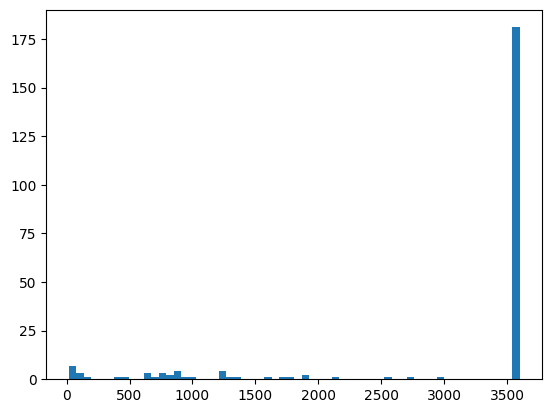

In [34]:
plt.hist(filtered_df['issue_response_diff'].dt.total_seconds(), bins = 60)
plt.show()

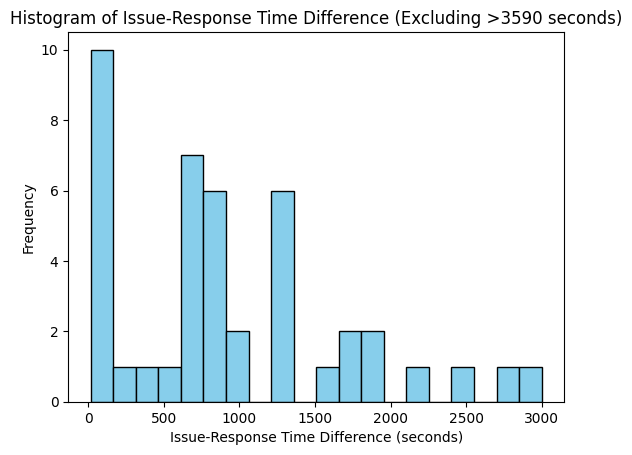

In [35]:
filtered_df_subset = filtered_df[filtered_df['issue_response_diff'].dt.total_seconds() <= 3590]

# Plot histogram
plt.hist(filtered_df_subset['issue_response_diff'].dt.total_seconds(), bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Issue-Response Time Difference (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Issue-Response Time Difference (Excluding >3590 seconds)')

# Show plot
plt.show()


In [36]:
len(filtered_df_subset)

43

In [37]:
filtered_df_subset.head(5)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
1394     2023006-00026A            48761                  95f79563193f5915   
4859     2023006-00622A            73431                  8f1ad3c2f6f929c1   
6847     2023006-00598A            61012                  670549c66de877ac   
7344     2023006-00156A            59455  CF15D08E385042A2916BB0F800B87801   
8153     2023006-00527A            66183  0D186C2F099A49A19C8EF440B26CEC45   

          Scheduled Time         Issued Time       Response Time  \
1394 2022-02-11 18:35:23 2022-02-11 18:45:23 2022-02-11 19:00:29   
4859 2023-07-02 10:56:33 2023-07-02 10:56:33 2023-07-02 11:04:29   
6847 2022-10-21 20:48:53 2022-10-21 20:48:53 2022-10-21 20:55:55   
7344 2022-08-30 11:59:38 2022-08-30 11:59:38 2022-08-30 12:16:16   
8153 2023-01-12 08:44:02 2023-01-12 08:44:02 2023-01-12 08:54:55   

     Duration (seconds) from scheduled to completion time  \
1394                                           Canceled     
4859                                           Canceled     
6847                                           Canceled     
7344                                           Canceled     
8153                                           Canceled     

     Duration (seconds) from first response to completion time  \
1394                                                276          
4859                                                 50          
6847                                                 35          
7344                                                 47          
8153                                                 11          

                 Location [2_MAQ_1] eating/drinking (other than water)  \
1394  1.333989 103.926076                                         True   
4859  1.318073 103.886291                                         None   
6847              Unknown                                         None   
7344  1.324738 103.765817                                         True   
8153  1.375543 103.948043                                         None   

     [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
1394                      None                        None   
4859                      None                        None   
6847                      None                        None   
7344                      True                        None   
8153                      None                        None   

     [2_MAQ_4] resting/sleeping\r  \
1394                         True   
4859                         None   
6847                         None   
7344                         None   
8153                         None   

     [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
1394                                               None         
4859                                               True         
6847                                               None         
7344                                               None         
8153                                               None         

     [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
1394                None            None                       None   
4859                None            None                       None   
6847                None            None                       None   
7344                None            None                       None   
8153                None            None                       None   

     [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
1394                                        True                 None   
4859                                        None                 None   
6847                                        True                 None   
7344                                        None                 None   
8153                                        None                 None   

     [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
1394   

In [38]:
filtered_df.head(1000).tail(5)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
36675     2023006-00324A            73565  DED1F059A41F4CBDB48B9EE44237362E   
36750     2023006-00413A            51726                  e2955e73faf15afd   
36887     2023006-00293A            55916                  53b83edf4d3fa58f   
37085     2023006-00054A            59424                  cc0056d0bea4789b   
37100     2023006-00156A            59455  CF15D08E385042A2916BB0F800B87801   

           Scheduled Time         Issued Time       Response Time  \
36675 2023-07-02 08:17:41 2023-07-02 08:17:41 2023-07-02 09:17:41   
36750 2022-03-26 08:31:55 2022-03-26 08:41:55 2022-03-26 09:41:55   
36887 2022-06-08 08:48:04 2022-06-08 08:58:04 2022-06-08 09:58:04   
37085 2022-08-28 09:14:07 2022-08-28 09:24:07 2022-08-28 10:24:07   
37100 2022-08-31 09:29:50 2022-08-31 09:29:50 2022-08-31 10:29:50   

      Duration (seconds) from scheduled to completion time  \
36675                                            Expired     
36750                                            Expired     
36887                                            Expired     
37085                                            Expired     
37100                                            Expired     

      Duration (seconds) from first response to completion time  \
36675                                                106          
36750                                                631          
36887                                               2710          
37085                                                807          
37100                                                935          

                  Location [2_MAQ_1] eating/drinking (other than water)  \
36675  1.420628 103.838127                                         None   
36750  1.389374 103.742973                                         None   
36887  1.439623 103.797006                                         None   
37085  1.341368 103.952156                                         True   
37100  1.316731 103.968425                                         True   

      [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
36675                      None                        None   
36750                      None                        None   
36887                      None                        None   
37085                      None                        None   
37100                      True                        None   

      [2_MAQ_4] resting/sleeping\r  \
36675                         True   
36750                         True   
36887                         None   
37085                         None   
37100                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
36675                                               None         
36750                                               None         
36887                                               None         
37085                                               None         
37100                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
36675                None            True                       None   
36750                None            None                       None   
36887                None            None                       None   
37085                None            None                       None   
37100                None            None                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
36675                                        None                 None   
36750                                        None                 None   
36887                                        None                 None   
37085                                        None                 None   
37100                                        None                 None   

      

#### Calculate response delay

In [39]:

# First, convert the columns to numeric and handle conversion errors with NaN
df_ema['Duration (seconds) from first response to completion time'] = pd.to_numeric(
    df_ema['Duration (seconds) from first response to completion time'], errors='coerce')
df_ema['Duration (seconds) from issued to completion time'] = pd.to_numeric(
    df_ema['Duration (seconds) from issued to completion time'], errors='coerce')

# Then, calculate the 'response delay' column by subtracting the two columns
df_ema['response delay'] = df_ema['Duration (seconds) from issued to completion time'] - df_ema['Duration (seconds) from first response to completion time']

# Now, the 'response delay' column will contain the time differences, and NaN for non-numeric values


In [40]:
response_delay = df_ema['response delay']
df_ema = df_ema.drop('response delay', axis=1)
position = 8  # Since Python uses 0-based indexing, the 9th position corresponds to index 8
df_ema.insert(position, 'response delay', response_delay)


#### Make a response_delay_column without the effects of the reminders (everything after 10 minutes is NaN)

In [41]:
df_ema['response_delay_10min'] = df_ema['response delay'].where(df_ema['response delay'] <= 598)

# Set values to NaN for rows where 'response delay' is greater than 598
df_ema.loc[df_ema['response delay'] > 598, 'response_delay_10min'] = pd.NA

In [42]:
df_ema.head(5)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00146A            47144  4D7296C6632540CEB41546939C8F3EA2   
1     2023006-00402A            47145  EC77B6EAED3341A088011364EFEFCD34   
2     2023006-00508A            47636                  b5d6b06e3e3283eb   
3     2023006-00116A            73429  B6ED4A2888CB438F82242F3D37714572   
4     2023006-00047A            48497  F321464C7BFC4197934E5628C7F0E2B8   

       Scheduled Time         Issued Time       Response Time  \
0 2022-01-21 20:32:54 2022-01-21 20:32:54 2022-01-21 20:39:55   
1 2022-01-21 21:11:32 2022-01-21 21:11:32 2022-01-21 21:25:09   
2 2022-01-24 20:48:15 2022-01-24 20:58:15 2022-01-24 21:09:25   
3 2023-06-29 21:19:41 2023-06-29 21:19:41 2023-06-29 21:22:54   
4 2022-02-14 20:30:36 2022-02-14 20:30:36 2022-02-14 21:30:36   

  Duration (seconds) from scheduled to completion time  \
0                                            421.367     
1                                            817.508     
2                                           1270.898     
3                                            193.953     
4                                            Expired     

   Duration (seconds) from first response to completion time  response delay  \
0                                               59.0                 362.367   
1                                              227.0                 590.508   
2                                               31.0                 639.898   
3                                              183.0                  10.953   
4                                                NaN                     NaN   

              Location [2_MAQ_1] eating/drinking (other than water)  \
0  1.321510 103.885419                                         True   
1  1.289592 103.829555                                         True   
2  1.341625 103.739039                                         None   
3  1.429330 103.851446                                         True   
4                 None                                         None   

  [2_MAQ_2] sports/exercise [2_MAQ_3] going somewhere\r  \
0                      None                        None   
1                      None                        None   
2                      None                        None   
3                      None                        None   
4                      None                        None   

  [2_MAQ_4] resting/sleeping\r  \
0                         None   
1                         None   
2                         None   
3                         None   
4                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         
1                                               None         
2                                               None         
3                                               True         
4                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   
1                None            None                       None   
2                None            None                       None   
3                None            None                       None   
4                None            None                       None   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   
1                                        None                 None   
2                                        None                 None   
3                                        None                 None   
4                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   
1               None          

In [43]:
import pandas as pd

# Assuming your DataFrame is named df_ema
count_expired = len(df_ema[df_ema['Duration (seconds) from scheduled to completion time'] == 'Expired'])
print('Expired:', count_expired)

# Assuming your DataFrame is named df_ema
count_cancelled = len(df_ema[df_ema['Duration (seconds) from scheduled to completion time'] == 'Canceled'])
print('Cancelled:', count_cancelled)

# Assuming your DataFrame is named df_ema
count_NaN = len(df_ema[df_ema['Duration (seconds) from scheduled to completion time'] == 'NaN'])
print('NaN:', count_NaN)




Expired: 4646
Cancelled: 64
NaN: 0


#### Visualisations of response delay

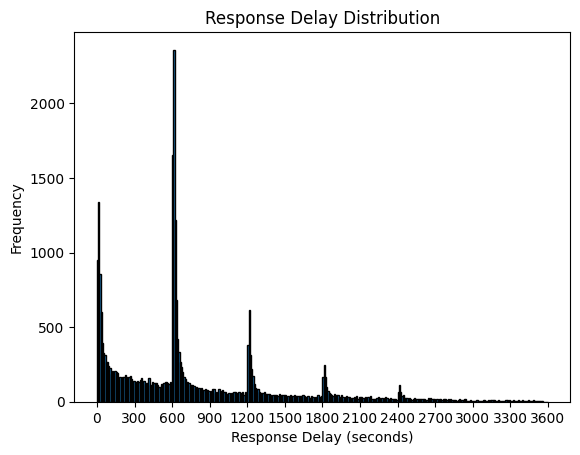

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df_ema' with the 'response delay' column
# Filter the data to exclude rows with NaN values in 'response delay'
filtered_df = df_ema.dropna(subset=['response delay'])

# Create a histogram of 'response delay' values with specified bins
bins = list(range(0, 3601, 10))  # Define bins from 0 to 1200 seconds with a bin width of 100 seconds
plt.hist(filtered_df['response delay'], bins=bins, edgecolor='k')
plt.xticks(range(0, 3601, 300))

# Set labels and title
plt.xlabel('Response Delay (seconds)')
plt.ylabel('Frequency')
plt.title('Response Delay Distribution')

# Show the plot
plt.show()


### Calculate next-prompt compliance

#### Make compliance feature

In [45]:
import pandas as pd

# Assuming you already have df_ema DataFrame

# Get the unique participant IDs from the 'Subject_ID_Roman_x' column
unique_participant_ids = df_ema['Subject_ID_Roman_x'].unique()

# Create the "compliance" column and initialize it with 1
df_ema['compliance'] = 1

# Iterate through each unique participant ID
for participant_id in tqdm(unique_participant_ids):
    # Filter the DataFrame for the current participant ID
    participant_df = df_ema[df_ema['Subject_ID_Roman_x'] == participant_id]

    # Identify rows where "Duration (seconds) from scheduled to completion time" is "Expired" or "Canceled"
    expired_or_canceled = (participant_df['Duration (seconds) from scheduled to completion time'] == "Expired") | (participant_df['Duration (seconds) from scheduled to completion time'] == "Canceled")

    # Update the "compliance" column to 0 for these rows
    participant_df.loc[expired_or_canceled, 'compliance'] = 0

    # If the first row is "Expired" or "Canceled," set it to 0 since there's no previous row
    if expired_or_canceled.iloc[0]:
        participant_df.at[participant_df.index[0], 'compliance'] = 0

    # Update the original DataFrame with the modified values for this participant
    df_ema.update(participant_df)


100%|█████████████████████████████████████████| 692/692 [03:41<00:00,  3.12it/s]


In [46]:
df_ema['compliance'].value_counts()

compliance
1    32658
0     4710
Name: count, dtype: int64

In [47]:
df_ema.head(37360).tail(5)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
37355     2023006-00328A            62994  40012FE854BC436183BA410FFEFA6048   
37356     2023006-00034A            62995                  9cd3be91e4a34476   
37357     2023006-00301A            63064                  837b302ad8ea4881   
37358     2023006-00358A            50791                              None   
37359     2023006-00554A            53728                              None   

           Scheduled Time         Issued Time       Response Time  \
37355 2022-11-19 09:15:36 2022-11-19 09:15:36 2022-11-19 09:18:20   
37356 2022-11-19 08:39:15 2022-11-19 08:39:15 2022-11-19 08:50:24   
37357 2022-11-22 08:23:18 2022-11-22 08:23:18 2022-11-22 08:25:52   
37358                 NaT                 NaT                 NaT   
37359                 NaT                 NaT                 NaT   

      Duration (seconds) from scheduled to completion time  \
37355                                            164.205     
37356                                             669.29     
37357                                            154.578     
37358                                               None     
37359                                               None     

       Duration (seconds) from first response to completion time  \
37355                                               98.0           
37356                                              141.0           
37357                                              114.0           
37358                                                NaN           
37359                                                NaN           

       response delay             Location  \
37355          66.205  1.358931 103.740090   
37356         528.290  1.366878 103.897343   
37357          40.578  1.317919 103.872991   
37358             NaN                 None   
37359             NaN                 None   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
37355                                         None                      None   
37356                                         True                      True   
37357                                         True                      None   
37358                                         None                      None   
37359                                         None                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
37355                        None                         True   
37356                        None                         None   
37357                        None                         None   
37358                        None                         None   
37359                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
37355                                               None         
37356                                               None         
37357                                               None         
37358                                               None         
37359                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
37355                None            None                       True   
37356                None            True                       None   
37357                None            None                       None   
37358                None            None                       None   
37359                None            None                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
37355                                        None                 None   
37356                                        None                 None   
37357                                        None                 None   
37358                                        None    

#### Testing above for single participants (Next-promt compliance)

In [48]:
# Get the unique values in the "Subject_ID_Roman_x" column
unique_values = df_ema['Subject_ID_Roman_x'].unique()

# Randomly choose one value from the unique values
chosen_value = random.choice(unique_values)

# Filter out all rows with the chosen value
single_participant = df_ema[df_ema['Subject_ID_Roman_x'] == chosen_value]

# The filtered_df will now contain all rows with a different value in the "Subject_ID_Roman_x" column.
single_participant.head(5)



Subject_ID_Roman_x  ID - Ethica EMA         Device ID  \
186      2023006-00118A            55420  09d0aa784d6421c6   
879      2023006-00118A            55420  09d0aa784d6421c6   
1570     2023006-00118A            55420  09d0aa784d6421c6   
2262     2023006-00118A            55420  09d0aa784d6421c6   
2955     2023006-00118A            55420  09d0aa784d6421c6   

          Scheduled Time         Issued Time       Response Time  \
186  2022-05-29 20:31:37 2022-05-29 20:31:37 2022-05-29 20:40:47   
879  2022-05-25 20:45:03 2022-05-25 20:55:03 2022-05-25 21:00:19   
1570 2022-05-24 19:06:35 2022-05-24 19:16:35 2022-05-24 20:16:35   
2262 2022-05-28 16:40:41 2022-05-28 16:50:41 2022-05-28 16:58:51   
2955 2022-05-26 21:13:58 2022-05-26 21:23:59 2022-05-26 21:25:11   

     Duration (seconds) from scheduled to completion time  \
186                                             550.056     
879                                             916.653     
1570                                            Expired     
2262                                           1090.139     
2955                                            673.788     

      Duration (seconds) from first response to completion time  \
186                                                18.0           
879                                                50.0           
1570                                                NaN           
2262                                               29.0           
2955                                               47.0           

      response delay             Location  \
186          532.056  1.314870 103.846829   
879          266.653  1.314758 103.846874   
1570             NaN                 None   
2262         461.139  1.314748 103.846797   
2955          25.788  1.314723 103.846815   

     [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
186                                          None                      None   
879                                          None                      None   
1570                                         None                      None   
2262                                         None                      None   
2955                                         None                      None   

     [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
186                         None                         True   
879                         None                         None   
1570                        None                         None   
2262                        None                         None   
2955                        None                         None   

     [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
186                                                None         
879                                                True         
1570                                               None         
2262                                               True         
2955                                               True         

     [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
186                 None            None                       None   
879                 None            None                       None   
1570                None            None                       None   
2262                None            None                       None   
2955                None            None                       None   

     [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
186                                         None                 None   
879                                         None                 None   
1570                                        None                 None   
2262                                        None                 None   
2955                                        None                 None   

     [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
1

#### Build targets

In [49]:
df_ema['2-min receptivity'] = df_ema['response delay'].apply(lambda x: 1 if x <= 120 else (0 if x > 120 else None))
df_ema['2-min receptivity'].value_counts(dropna=False)


2-min receptivity
0.0    26368
1.0     5969
NaN     5031
Name: count, dtype: int64

In [50]:
df_ema['5-min receptivity'] = df_ema['response delay'].apply(lambda x: 1 if x <= 300 else (0 if x > 300 else None))
df_ema['5-min receptivity'].value_counts(dropna=False)

5-min receptivity
0.0    23317
1.0     9020
NaN     5031
Name: count, dtype: int64

In [51]:
df_ema['10-min receptivity'] = df_ema['response delay'].apply(lambda x: 1 if x <= 600 else (0 if x > 600 else None))
df_ema['10-min receptivity'].value_counts(dropna=False)

10-min receptivity
0.0    19508
1.0    12829
NaN     5031
Name: count, dtype: int64

In [52]:
df_ema['20-min receptivity'] = df_ema['response delay'].apply(lambda x: 1 if x <= 1200 else (0 if x > 1200 else None))
df_ema['20-min receptivity'].value_counts(dropna=False)

20-min receptivity
1.0    24274
0.0     8063
NaN     5031
Name: count, dtype: int64

In [53]:
def convert_and_ignore(value):
    if value not in ['NaN']:
        try:
            return float(value)
        except (ValueError, TypeError):
            pass
    return None

# Apply the custom function to the DataFrame
df_ema['response delay'] = df_ema['response delay'].apply(convert_and_ignore)

# Remove non-float values
filtered_df = df_ema.dropna(subset=['response delay'])

# Define time intervals
intervals = [(0, 600), (600, 1200), (1200, 1800), (1800, 2400), (2400, 3000), (3000, 3600), (3600, 4200)]

# Initialize counters for each interval
counters = {f"{start}-{end} seconds": 0 for start, end in intervals}

# Count values in each interval
for start, end in intervals:
    counters[f"{start}-{end} seconds"] = ((filtered_df['response delay'] >= start) &
                                           (filtered_df['response delay'] < end)).sum()

# Print the counts for each interval
for interval, count in counters.items():
    print(f"{interval}: {count} responses")

0-600 seconds: 12829 responses
600-1200 seconds: 11445 responses
1200-1800 seconds: 4192 responses
1800-2400 seconds: 2290 responses
2400-3000 seconds: 1188 responses
3000-3600 seconds: 393 responses
3600-4200 seconds: 0 responses


In [54]:
negative_values_mask = df_ema['response delay'] < 0
df_negative_values = df_ema[negative_values_mask]

In [55]:
df_negative_values.head()

Empty DataFrame
Columns: [Subject_ID_Roman_x, ID - Ethica EMA, Device ID, Scheduled Time, Issued Time, Response Time, Duration (seconds) from scheduled to completion time, Duration (seconds) from first response to completion time, response delay, Location, [2_MAQ_1] eating/drinking (other than water), [2_MAQ_2] sports/exercise, [2_MAQ_3] going somewhere
, [2_MAQ_4] resting/sleeping
, [2_MAQ_5] using a screen (e.g., phone, tablet, computer), [2_MAQ_6] nothing
, [2_MAQ_7] Other, [2_MAQ_8] working/studying, [2_MAQ_9] household chores/cooking/shopping, [2_MAQ_10] childcare, [2_MAQ_11] hobbies, [2_MAQ_12] talking/socialising, [2_MAQ_13] praying/meditation, [3_FFT] Please describe, [4_MAQ_1] Meal, [4_MAQ_2] Snack/desserts, [4_MAQ_3] Drink, [4_MAQ_4] No, [5_CAL]  What time did you eat your meal?, [6_MAQ_1] white rice/noodles/pasta/bread/cereal
, [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea, [6_MAQ_3] fish or seafood
, [6_MAQ_4] chicken
, [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)
, [6_MAQ_6] soy foods (e.g., tofu, tempeh)
, [6_MAQ_9] vegetables, [6_MAQ_10] fruit, [6_MAQ_11] milk, yoghurt or cheese, [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French , [6_MAQ_13] sweet dessert, [6_MAQ_14] other food, [6_MAQ_15] egg, [6_MAQ_16] beans, peas, and nuts (e.g., peanuts, dahl, sambar, [7_FFT] Please describe, [8_MAQ_1] work
, [8_MAQ_2] watch a screen for leisure (e.g., phone, TV)
, [8_MAQ_3] play computer games
, [8_MAQ_4] reading or writing for leisure
, [8_MAQ_5] conversation with others present at the meal
, [8_MAQ_6] phone conversation
, [8_MAQ_7] walking
, [8_MAQ_8] nothing else
, [8_MAQ_9] other activity
, [9_SAQ]  Where did you eat your snack or meal?, [10_FFT] Please describe, [46_MAQ_1] spouse/partner
, [46_MAQ_2] your children
, [46_MAQ_3] other family members
, [46_MAQ_4] friends
, [46_MAQ_5] colleagues/fellow students, [46_MAQ_6] no one
, [46_MAQ_7] pet
, [46_MAQ_8] other, [46_MAQ_9] people I dont know well, [47_FFT] Please describe, [11_SAQ]  How full did you feel after eating your meal?, [12_CAL] What time did you eat your snack?, [13_MAQ_1] sweet snacks (e.g., cookies, cakes, candy, sweet d, [13_MAQ_2] chips or fried crackers (e.g., potato chips, prawn, [13_MAQ_3] other deep-fried food (e.g., puffs, samosas, Frenc, [13_MAQ_4] nuts or seeds
, [13_MAQ_5] fruits or vegetables
, [13_MAQ_6] other snacks, [14_FFT] Please describe, [15_SAQ]  Where did you eat your snack or meal?, [16_FFT] Please describe, [17_MAQ_1] it was my regular snack time
, [17_MAQ_2] I was hungry
, [17_MAQ_3] I felt tired/a lack of energy
, [17_MAQ_4] I felt bored, [17_MAQ_5] there was a celebration/special event, [17_MAQ_6] I wanted to keep others company, [17_MAQ_7] I saw an advertisement for delicious food
, [17_MAQ_8] I saw or smelled delicious food
, [17_MAQ_9] I noticed food that was good value for money
, [17_MAQ_10] other reason
, [17_MAQ_11] I wanted to give myself a treat, [17_MAQ_12] I felt stressed, frustrated, lonely, or sad, [17_MAQ_13] I wanted to please others who wanted me to eat it, [17_MAQ_14] I was watching TV/a movie, [17_MAQ_15] I wanted to avoid food going to waste, [17_MAQ_16] I do not know, [18_MAQ_1] soy or other non-dairy milk (e.g., almond), [18_MAQ_2] milk (cow milk)
, [18_MAQ_3] malted drink/hot chocolate (e.g., Milo)
, [18_MAQ_4] fruit juice, 100%, no added sugar
, [18_MAQ_6] sweetened beverages (e.g., cola, sports drinks, fr, [18_MAQ_7] sugar-free sweetened beverages (e.g., Coke Zero)
, [18_MAQ_8] coffee with sugar (e.g., sugar, condensed milk), [18_MAQ_9] tea with sugar (e.g., sugar, condensed milk), ...]
Index: []

In [56]:
df_ema['response delay'].describe()

count    32337.000000
mean       791.031913
std        717.338673
min          1.707000
25%        238.638000
50%        616.368000
75%       1196.033000
max       3586.666000
Name: response delay, dtype: float64

### Completion time

#### Visualisations of response delay

In [57]:
negative_values_mask = df_ema['Duration (seconds) from first response to completion time'] < 0
df_negative_values = df_ema[negative_values_mask]


In [58]:
df_negative_values.head()

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
20731     2023006-00682A            62271  9E9F749599B44637BF042C91FC27EEF7   
35192     2023006-00213A            60557  7CC37E7A3CF64541B85031B11157AB1B   

           Scheduled Time         Issued Time       Response Time  \
20731 2022-11-07 09:07:16 2022-11-07 09:07:16 2022-11-07 10:07:16   
35192 2022-10-11 18:54:40 2022-10-11 18:54:40 2022-10-11 19:54:40   

      Duration (seconds) from scheduled to completion time  \
20731                                            Expired     
35192                                            Expired     

       Duration (seconds) from first response to completion time  \
20731                                               -2.0           
35192                                               -4.0           

       response delay             Location  \
20731             NaN  1.360275 103.750001   
35192             NaN  1.346420 103.749899   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
20731                                         None                      None   
35192                                         None                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
20731                        None                         None   
35192                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
20731                                               None         
35192                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
20731                None            None                       None   
35192                None            None                       True   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
20731                                        None                 None   
35192                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
20731               None                           None   
35192               None                           None   

      [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
20731                          None                    None           None   
35192                          None                    None           None   

      [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
20731                     None            None         None   
35192                     None            None         None   

      [5_CAL]  What time did you eat your meal?  \
20731                                      None   
35192                                      None   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
20731                                              None   
35192                                              None   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
20731                                               None             
35192                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
20731                        None                None   
35192                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
20731                                               None        
35192                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
20731                                       None                 None   
35192                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
20731             None                               None   
35192             None                               None   

      [6_MAQ_12] any deep-fried 

There seem to be 2 rows with negative Completion Time values. Therefore, we will drop these two rows (20731, adn 35192) from the dataset

In [59]:
df_ema = df_ema.drop([20731, 35192])

In [60]:
df_ema['Duration (seconds) from first response to completion time'].describe()

count    32559.000000
mean        87.602537
std        158.814954
min          0.000000
25%         23.000000
50%         51.000000
75%        101.000000
max       3591.000000
Name: Duration (seconds) from first response to completion time, dtype: float64

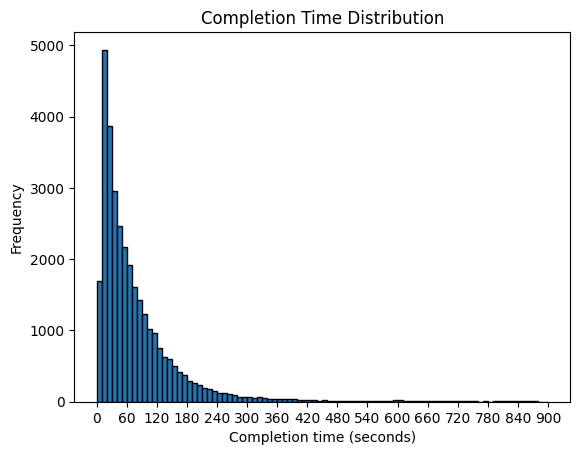

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df_ema' with the 'response delay' column
# Filter the data to exclude rows with NaN values in 'response delay'
filtered_df = df_ema.dropna(subset=['Duration (seconds) from first response to completion time'])

# Create a histogram of 'response delay' values with specified bins
bins = list(range(0, 901, 10))  # Define bins from 0 to 1200 seconds with a bin width of 100 seconds
plt.hist(filtered_df['Duration (seconds) from first response to completion time'], bins=bins, edgecolor='k')
plt.xticks(range(0, 901, 60))

# Set labels and title
plt.xlabel('Completion time (seconds)')
plt.ylabel('Frequency')
plt.title('Completion Time Distribution')

# Show the plot
plt.show()


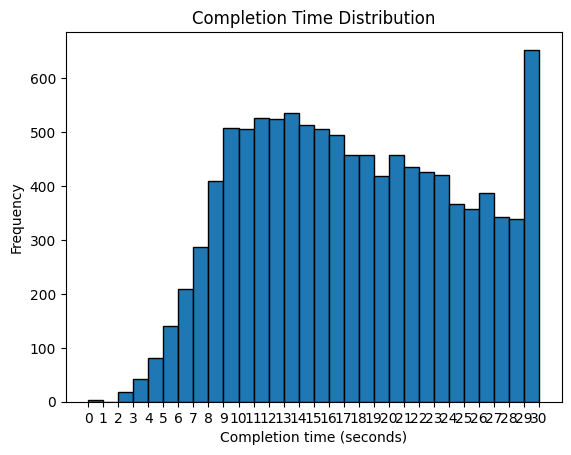

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df_ema' with the 'response delay' column
# Filter the data to exclude rows with NaN values in 'response delay'
filtered_df = df_ema.dropna(subset=['Duration (seconds) from first response to completion time'])

# Create a histogram of 'response delay' values with specified bins
bins = list(range(0, 31, 1))  # Define bins from 0 to 1200 seconds with a bin width of 100 seconds
plt.hist(filtered_df['Duration (seconds) from first response to completion time'], bins=bins, edgecolor='k')
plt.xticks(range(0, 31, 1))

# Set labels and title
plt.xlabel('Completion time (seconds)')
plt.ylabel('Frequency')
plt.title('Completion Time Distribution')

# Show the plot
plt.show()


In [63]:
def convert_and_ignore(value):
    if value not in ['NaN']:
        try:
            return float(value)
        except (ValueError, TypeError):
            pass
    return None

# Apply the custom function to the DataFrame
df_ema['Duration (seconds) from first response to completion time'] = df_ema['Duration (seconds) from first response to completion time'].apply(convert_and_ignore)

# Remove non-float values
filtered_df = df_ema.dropna(subset=['Duration (seconds) from first response to completion time'])

# Define time intervals
intervals = [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360), (360, 420), (420, 480), (360, 420), (480, 540), (540, 600), (600, 660), (660, 720)]

# Initialize counters for each interval
counters = {f"{start}-{end} seconds": 0 for start, end in intervals}

# Count values in each interval
for start, end in intervals:
    counters[f"{start}-{end} seconds"] = ((filtered_df['Duration (seconds) from first response to completion time'] >= start) &
                                           (filtered_df['Duration (seconds) from first response to completion time'] < end)).sum()

# Print the counts for each interval
for interval, count in counters.items():
    print(f"{interval}: {count} responses")

0-60 seconds: 18102 responses
60-120 seconds: 8163 responses
120-180 seconds: 3276 responses
180-240 seconds: 1290 responses
240-300 seconds: 577 responses
300-360 seconds: 308 responses
360-420 seconds: 191 responses
420-480 seconds: 104 responses
480-540 seconds: 65 responses
540-600 seconds: 73 responses
600-660 seconds: 89 responses
660-720 seconds: 51 responses


In [64]:
df_ema['Duration (seconds) from first response to completion time'].describe()

count    32559.000000
mean        87.602537
std        158.814954
min          0.000000
25%         23.000000
50%         51.000000
75%        101.000000
max       3591.000000
Name: Duration (seconds) from first response to completion time, dtype: float64

#### Because responses that are quicker than 2 seconds are technically impossible, we remove any responses that are lower than 2 seconds

In [65]:
num_rows_duration_2_or_less = (df_ema['Duration (seconds) from first response to completion time'] <= 2).sum()
print("Number of rows with duration of 2 or less:", num_rows_duration_2_or_less)


Number of rows with duration of 2 or less: 21


In [66]:
len(df_ema)

37366

In [67]:

# Filter out rows from df_ema that are not in num_rows_duration_2_or_less
df_ema = df_ema[~(df_ema['Duration (seconds) from first response to completion time'] < 2)]

# Check the number of rows in filtered_df
print("Number of rows in filtered DataFrame:", len(filtered_df))


Number of rows in filtered DataFrame: 32559


#### Rename some columns

In [68]:
df_ema = df_ema.rename(columns={'Duration (seconds) from first response to completion time': 'completion_time'})


In [69]:
df_ema.head(1)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00146A            47144  4D7296C6632540CEB41546939C8F3EA2   

       Scheduled Time         Issued Time       Response Time  \
0 2022-01-21 20:32:54 2022-01-21 20:32:54 2022-01-21 20:39:55   

  Duration (seconds) from scheduled to completion time  completion_time  \
0                                            421.367               59.0   

   response delay             Location  \
0         362.367  1.321510 103.885419   

  [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
0                                         True                      None   

  [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
0                        None                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   

  [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
0                          None                    None           None   

  [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
0                     True            None         None   

  [5_CAL]  What time did you eat your meal?  \
0                                      None   

  [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
0                                              None   

  [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
0                                               None             

  [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
0                        None                None   

  [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
0                                               None        

  [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
0                                       None                 None   

  [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
0             None                               None   

  [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
0                                               None              

  [6_MAQ_13] sweet dessert [6_MAQ_14] other food [6_MAQ_15] egg  \
0                     None                  None           None   

  [6_MAQ_16] beans, peas, and nuts (e.g., peanuts, dahl, sambar  \
0                                               None              

  [7_FFT] Please describe [8_MAQ_1] work\r  \
0                    None             None   

  [8_MAQ_2] watch a screen for leisure (e.g., phone, TV)\r  \
0                                               None         

  [8_MAQ_3] play computer games\r [8_MAQ_4] reading or writing for leisure\r  \
0                            None                                       None   

  [8_MAQ_5] conversation with others present at the meal\r  \
0                                               None         

  [8_MAQ_6] phone conversation\r [8_MAQ_7] walking\r [8_MAQ_8] nothing else\r  \
0                           None                None                     None   

  [8_MAQ_9] other activity\r  [9_SAQ]  Where did you eat your snack or meal?  \
0                       None                                             NaN   

  [10_FFT] Please describe [46_MAQ_1] spouse/partner\r  \
0                     None                        None   

  [46_MAQ_2] your children\r [46_MAQ_3] other family members\r  \
0                       None                              None   

  [46_MAQ_4] friends\r [46_MAQ_5] colleagues/fellow students  \
0                 None                                

## Exports

Which rows from this dataframe need to be preserved for later?

In [70]:
df_ema['Duration (seconds) from scheduled to completion time'] = pd.to_numeric(df_ema['Duration (seconds) from scheduled to completion time'], errors='coerce')


In [71]:
df_ema.to_parquet(f'../outputs/targets.parquet', index=False)

In [72]:
df_ema.head()

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00146A            47144  4D7296C6632540CEB41546939C8F3EA2   
1     2023006-00402A            47145  EC77B6EAED3341A088011364EFEFCD34   
2     2023006-00508A            47636                  b5d6b06e3e3283eb   
3     2023006-00116A            73429  B6ED4A2888CB438F82242F3D37714572   
4     2023006-00047A            48497  F321464C7BFC4197934E5628C7F0E2B8   

       Scheduled Time         Issued Time       Response Time  \
0 2022-01-21 20:32:54 2022-01-21 20:32:54 2022-01-21 20:39:55   
1 2022-01-21 21:11:32 2022-01-21 21:11:32 2022-01-21 21:25:09   
2 2022-01-24 20:48:15 2022-01-24 20:58:15 2022-01-24 21:09:25   
3 2023-06-29 21:19:41 2023-06-29 21:19:41 2023-06-29 21:22:54   
4 2022-02-14 20:30:36 2022-02-14 20:30:36 2022-02-14 21:30:36   

   Duration (seconds) from scheduled to completion time  completion_time  \
0                                            421.367                59.0   
1                                            817.508               227.0   
2                                           1270.898                31.0   
3                                            193.953               183.0   
4                                                NaN                 NaN   

   response delay             Location  \
0         362.367  1.321510 103.885419   
1         590.508  1.289592 103.829555   
2         639.898  1.341625 103.739039   
3          10.953  1.429330 103.851446   
4             NaN                 None   

  [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
0                                         True                      None   
1                                         True                      None   
2                                         None                      None   
3                                         True                      None   
4                                         None                      None   

  [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
0                        None                         None   
1                        None                         None   
2                        None                         None   
3                        None                         None   
4                        None                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         
1                                               None         
2                                               None         
3                                               True         
4                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   
1                None            None                       None   
2                None            None                       None   
3                None            None                       None   
4                None            None                       None   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   
1                                        None                 None   
2                                        None                 None   
3                                        None                 None   
4                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   
1               None                           None   
2               None                           True   
3               None                           None   
4               None                           None   

  [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
0           

In [73]:
df_ema['Subject_ID_Roman_x'].nunique()

692

##### Below is the output of the 2 participants that did not have 54 surveys

In [74]:
import pandas as pd

# Assuming df_ema is your DataFrame
participant_counts = df_ema['Subject_ID_Roman_x'].value_counts()

# Get the participant IDs without exactly 54 surveys
participants_without_54_surveys = participant_counts[participant_counts != 54].index

# Create a new DataFrame with the participant IDs and their survey counts
output_df = pd.DataFrame({
    'Subject_ID_Roman_x': participants_without_54_surveys,
    'Survey_Count': participant_counts[participants_without_54_surveys]
})

# Save the DataFrame to a CSV file
output_df.to_csv('participants_without_54_surveys.csv', index=False)
output_df.to_csv(f'../outputs/participants_without_54_surveys_for_se.csv', index=False)

# Create a new DataFrame with only the rows corresponding to the participant IDs without exactly 54 surveys
df_ema_filtered = df_ema[df_ema['Subject_ID_Roman_x'].isin(participants_without_54_surveys)]

# Sort the filtered DataFrame by participant ID
df_ema_filtered_sorted = df_ema_filtered.sort_values('Subject_ID_Roman_x')

# Display the counts
print(f"Participants with exactly 54 surveys: {(participant_counts == 54).sum()}")
print(f"Participants without exactly 54 surveys: {len(participants_without_54_surveys)}")
print(output_df)  # Display the survey counts for participants without exactly 54 surveys


Participants with exactly 54 surveys: 687
Participants without exactly 54 surveys: 5
                   Subject_ID_Roman_x  Survey_Count
Subject_ID_Roman_x                                 
2023006-00366A         2023006-00366A            53
2023006-00213A         2023006-00213A            53
2023006-00305A         2023006-00305A            53
2023006-00682A         2023006-00682A            53
2023006-00351A         2023006-00351A            53


In [75]:
output_df.head()

Subject_ID_Roman_x  Survey_Count
Subject_ID_Roman_x                                 
2023006-00366A         2023006-00366A            53
2023006-00213A         2023006-00213A            53
2023006-00305A         2023006-00305A            53
2023006-00682A         2023006-00682A            53
2023006-00351A         2023006-00351A            53

In [76]:
# Assuming df_ema is your DataFrame
participant_counts = df_ema['Subject_ID_Roman_x'].value_counts()

# Extract the list of participants with exactly 54 surveys
participants_with_54_surveys = participant_counts[participant_counts == 54].index.tolist()

# Filter the DataFrame to include only participants with exactly 54 surveys
df_ema = df_ema[df_ema['Subject_ID_Roman_x'].isin(participants_with_54_surveys)]


In [77]:
df_ema['Subject_ID_Roman_x'].nunique()

687

In [78]:
# Get all unique participant IDs from df_filtered_deleted_app
unique_participant_ids = output_df['Subject_ID_Roman_x'].unique()

# Print the unique participant IDs
print("Unique Participant IDs in df_filtered_not_54_surveys:")
print(unique_participant_ids)

# Print the count of unique participant IDs
print("Number of Unique Participant IDs:", len(unique_participant_ids))

Unique Participant IDs in df_filtered_not_54_surveys:
['2023006-00366A' '2023006-00213A' '2023006-00305A' '2023006-00682A'
 '2023006-00351A']
Number of Unique Participant IDs: 5


In [79]:
df_ema_filtered_sorted = df_ema_filtered.sort_values(['Subject_ID_Roman_x', 'Issued Time'])

In [80]:
df_ema_filtered_sorted_reindexed = df_ema_filtered_sorted.reset_index(drop=True)

In [81]:
df_ema_filtered_sorted_reindexed.head(3)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00213A            60557  7CC37E7A3CF64541B85031B11157AB1B   
1     2023006-00213A            60557  7CC37E7A3CF64541B85031B11157AB1B   
2     2023006-00213A            60557  7CC37E7A3CF64541B85031B11157AB1B   

       Scheduled Time         Issued Time       Response Time  \
0 2022-10-05 08:20:26 2022-10-05 08:20:26 2022-10-05 08:30:09   
1 2022-10-05 11:19:32 2022-10-05 11:19:32 2022-10-05 11:41:46   
2 2022-10-05 13:09:59 2022-10-05 13:09:59 2022-10-05 13:11:18   

   Duration (seconds) from scheduled to completion time  completion_time  \
0                                            583.037                54.0   
1                                           1334.709                48.0   
2                                             79.107                26.0   

   response delay             Location  \
0         529.037  1.344865 103.746151   
1        1286.709  1.295036 103.770341   
2          53.107  1.334076 103.741790   

  [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
0                                         None                      None   
1                                         None                      None   
2                                         None                      None   

  [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
0                        True                         None   
1                        None                         None   
2                        True                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         
1                                               True         
2                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                True            None                       None   
1                None            None                       True   
2                None            None                       None   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   
1                                        None                 None   
2                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   
1               None                           None   
2               None                           None   

  [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
0                          None                    None           None   
1                          None                    None           None   
2                          None                    None           None   

  [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
0                     None            None         None   
1                     None            None         None   
2                     None            None         None   

  [5_CAL]  What time did you eat your meal?  \
0                                      None   
1                                      None   
2                                      None   

  [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
0                                              None   
1                                              None   
2                                              None   

  [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
0                                               None             
1                                               None             
2                                               None             

  [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
0                        None                None   
1                        None                None   
2                   

In [82]:
df_ema.head(1)

Subject_ID_Roman_x  ID - Ethica EMA                         Device ID  \
0     2023006-00146A            47144  4D7296C6632540CEB41546939C8F3EA2   

       Scheduled Time         Issued Time       Response Time  \
0 2022-01-21 20:32:54 2022-01-21 20:32:54 2022-01-21 20:39:55   

   Duration (seconds) from scheduled to completion time  completion_time  \
0                                            421.367                59.0   

   response delay             Location  \
0         362.367  1.321510 103.885419   

  [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
0                                         True                      None   

  [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
0                        None                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   

  [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
0                          None                    None           None   

  [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
0                     True            None         None   

  [5_CAL]  What time did you eat your meal?  \
0                                      None   

  [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
0                                              None   

  [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
0                                               None             

  [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
0                        None                None   

  [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
0                                               None        

  [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
0                                       None                 None   

  [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
0             None                               None   

  [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
0                                               None              

  [6_MAQ_13] sweet dessert [6_MAQ_14] other food [6_MAQ_15] egg  \
0                     None                  None           None   

  [6_MAQ_16] beans, peas, and nuts (e.g., peanuts, dahl, sambar  \
0                                               None              

  [7_FFT] Please describe [8_MAQ_1] work\r  \
0                    None             None   

  [8_MAQ_2] watch a screen for leisure (e.g., phone, TV)\r  \
0                                               None         

  [8_MAQ_3] play computer games\r [8_MAQ_4] reading or writing for leisure\r  \
0                            None                                       None   

  [8_MAQ_5] conversation with others present at the meal\r  \
0                                               None         

  [8_MAQ_6] phone conversation\r [8_MAQ_7] walking\r [8_MAQ_8] nothing else\r  \
0                           None                None                     None   

  [8_MAQ_9] other activity\r  [9_SAQ]  Where did you eat your snack or meal?  \
0                       None                                             NaN   

  [10_FFT] Please describe [46_MAQ_1] spouse/partner\r  \
0                     None                        None   

  [46_MAQ_2] your children\r [46_MAQ_3] other family members\r  \
0                       None                              None   

  [46_MAQ_4] friends\r [46_MAQ_5] colleagues/fellow students  \
0                 None                              

# Merge the file together with the independent variables file

## Data Ingestion

In [83]:
df_questionnaires = pd.read_excel('../data_questionnaire/2023006_COBRA_20230811.xlsx')
df_id_mapping = pd.read_excel('../data_ema/COBRA ID Mapping for Roman.xlsx')

#df_InterVarValue = pd.read_csv('../data/mcd_mongo_exports/InterventionVariableWithValue.csv')
#df_PartVarValue = pd.read_csv('../data/mcd_mongo_exports/ParticipantVariableWithValue.csv')

#### Joining the two dataframes

In [84]:
df_ema = df_ema.merge(df_id_mapping[['ID - Ethica EMA', 'Subject_ID_Roman']], 
                    left_on='ID - Ethica EMA', 
                    right_on='ID - Ethica EMA', 
                    how='left')



In [85]:
df_ema['Subject_ID_Roman_x'].nunique()

687

In [86]:
len(df_ema)

37098

In [87]:
df_questionnaires.head(2)

SubjectID  Int_Age  Gender  Derived_Race RaceOthers  a2 a2others  a3  \
0  2023006-00529A       36       2             1        NaN   1      NaN   8   
1  2023006-00023A       53       1             1        NaN   1      NaN   2   

   a4  a5  a5_999  a6  a6_999  a7 a7others  a8 a8others  i1  i2  i3  i4  i41  \
0   1   1       0   1       0   1      NaN   1      NaN   1   5   2   2  4.0   
1   1  46       0   2       0   1      NaN   1      NaN   5   6   3   1  4.0   

    i42  i43  i44  i5  i6  i7 i7oth  i8  i9  i10  i11  i12  i13  i141  i142  \
0   4.0  2.0  NaN   4   2   4   NaN   1   2    0    2    2    4     2     2   
1  10.0  2.0  NaN   2   1   4   NaN   2   0    1    2    2    5     1     1   

   i143  i144  i145  i14_none  i15a  i15b  i15c  i15d  i15e  i15f  i15g  i15h  \
0     2     2     2       NaN     6     6     6     5     4     4     4     5   
1     1     1     2       NaN     5     5     5     5     5     5     5     5   

   i15i  i15j  i15k  i15l  c1  c2  c2a  c3  c4age  c5age  c6  c7  c8  c9  c10  \
0     5     5     5     5   2 NaN  NaN NaN    NaN    NaN NaN NaN NaN NaN  1.0   
1     5     5     5     5   2 NaN  NaN NaN    NaN    NaN NaN NaN NaN NaN  1.0   

   b1  b2a  b2b  b3  b4  b5  
0   2  2.0  NaN NaN NaN NaN  
1   1  NaN  NaN NaN NaN NaN

In [88]:
questionnaires_unique = df_questionnaires['SubjectID'].unique()
len(questionnaires_unique)

694

In [89]:
# Find values unique to each dataframe
unique_to_questionnaires = set(questionnaires_unique) - set(ema_unique)
unique_to_ema = set(ema_unique) - set(questionnaires_unique)

# Print values unique to each dataframe
print("Values unique to df_questionnaires:")
print(unique_to_questionnaires)

print("\nValues unique to df_ema:")
print(unique_to_ema)

Values unique to df_questionnaires:
{'2023006-00405A', '2023006-00122A'}

Values unique to df_ema:
set()


In [90]:
# MOve the subject ID to the left side of the dataframe
subject_id_roman = df_ema['Subject_ID_Roman']

# Drop the "Subject_ID_Roman" column from the original DataFrame
df_ema = df_ema.drop('Subject_ID_Roman', axis=1)

# Insert the "Subject_ID_Roman" column at the beginning (left) of the DataFrame
df_ema.insert(0, 'Subject_ID_Roman', subject_id_roman)


##### Merge with the questionnaires dataframe

In [91]:
df_ema = df_ema.merge(
    df_id_mapping[['ID - Ethica EMA', 'Subject_ID_Roman']],
    left_on='ID - Ethica EMA',
    right_on='ID - Ethica EMA',
    how='left',
    suffixes=('_left', '_right')
)

In [92]:
df_ema.head(220).tail(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
218        2023006-00464A     2023006-00464A            56125   
219        2023006-00608A     2023006-00608A            63270   

                            Device ID      Scheduled Time         Issued Time  \
218  9B333775042140D1A05D9E2B5CA73299 2022-06-09 20:42:07 2022-06-09 20:42:07   
219                  8f41806d3bbfcb3e 2022-11-21 20:35:42 2022-11-21 20:45:42   

          Response Time  Duration (seconds) from scheduled to completion time  \
218 2022-06-09 20:55:18                                            791.460      
219 2022-11-21 20:48:11                                            749.656      

     completion_time  response delay             Location  \
218            183.0         608.460  1.305047 103.782703   
219             42.0         107.656  1.329807 103.902772   

    [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
218                                         True                      True   
219                                         True                      None   

    [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
218                        None                         None   
219                        None                         None   

    [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
218                                               True         
219                                               None         

    [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
218                None            None                       None   
219                None            None                       True   

    [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
218                                        True                 True   
219                                        None                 None   

    [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
218               None                           None   
219               None                           True   

    [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
218                          None                    None           True   
219                          None                    None           True   

    [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
218                     None            None         None   
219                     None            None         None   

    [5_CAL]  What time did you eat your meal?  \
218                            0/1/1900 18:40   
219                            0/1/1900 20:47   

    [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
218                                              None   
219                                              True   

    [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
218                                               None             
219                                               None             

    [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
218                        None                None   
219                        None                None   

    [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
218                                               True        
219                                               None        

    [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
218                                       None                 True   
219                                       None                 None   

    [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
218             True                               None   
219             None                               None   

    [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
218                                               None              
219                                               None              

    [6_MAQ_13] sweet 

#### Create index for each rows for joining with dependent var df later on

In [93]:
df_ema['initial_index_ema'] = range(len(df_ema))

In [94]:
df_ema.head(3)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
0        2023006-00146A     2023006-00146A            47144   
1        2023006-00402A     2023006-00402A            47145   
2        2023006-00508A     2023006-00508A            47636   

                          Device ID      Scheduled Time         Issued Time  \
0  4D7296C6632540CEB41546939C8F3EA2 2022-01-21 20:32:54 2022-01-21 20:32:54   
1  EC77B6EAED3341A088011364EFEFCD34 2022-01-21 21:11:32 2022-01-21 21:11:32   
2                  b5d6b06e3e3283eb 2022-01-24 20:48:15 2022-01-24 20:58:15   

        Response Time  Duration (seconds) from scheduled to completion time  \
0 2022-01-21 20:39:55                                            421.367      
1 2022-01-21 21:25:09                                            817.508      
2 2022-01-24 21:09:25                                           1270.898      

   completion_time  response delay             Location  \
0             59.0         362.367  1.321510 103.885419   
1            227.0         590.508  1.289592 103.829555   
2             31.0         639.898  1.341625 103.739039   

  [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
0                                         True                      None   
1                                         True                      None   
2                                         None                      None   

  [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
0                        None                         None   
1                        None                         None   
2                        None                         None   

  [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
0                                               None         
1                                               None         
2                                               None         

  [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
0                None            None                       True   
1                None            None                       None   
2                None            None                       None   

  [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
0                                        None                 None   
1                                        None                 None   
2                                        None                 None   

  [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
0               None                           None   
1               None                           None   
2               None                           True   

  [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
0                          None                    None           None   
1                          None                    None           True   
2                          True                    None           None   

  [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
0                     True            None         None   
1                     None            None         None   
2                     None            None         None   

  [5_CAL]  What time did you eat your meal?  \
0                                      None   
1                            0/1/1900 19:30   
2                                      None   

  [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
0                                              None   
1                                              None   
2                                              None   

  [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
0                                               None             
1                                               True             
2                                               None             

  [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
0                        None         

In [95]:
df_ema['Issued_minus_scheduled_time'] = (df_ema['Issued Time'] - df_ema['Scheduled Time']).dt.total_seconds()
filtered_df = df_ema[df_ema['Issued_minus_scheduled_time'] > 1.0]

In [96]:
df_ema.head(220).tail(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
218        2023006-00464A     2023006-00464A            56125   
219        2023006-00608A     2023006-00608A            63270   

                            Device ID      Scheduled Time         Issued Time  \
218  9B333775042140D1A05D9E2B5CA73299 2022-06-09 20:42:07 2022-06-09 20:42:07   
219                  8f41806d3bbfcb3e 2022-11-21 20:35:42 2022-11-21 20:45:42   

          Response Time  Duration (seconds) from scheduled to completion time  \
218 2022-06-09 20:55:18                                            791.460      
219 2022-11-21 20:48:11                                            749.656      

     completion_time  response delay             Location  \
218            183.0         608.460  1.305047 103.782703   
219             42.0         107.656  1.329807 103.902772   

    [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
218                                         True                      True   
219                                         True                      None   

    [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
218                        None                         None   
219                        None                         None   

    [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
218                                               True         
219                                               None         

    [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
218                None            None                       None   
219                None            None                       True   

    [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
218                                        True                 True   
219                                        None                 None   

    [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
218               None                           None   
219               None                           True   

    [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
218                          None                    None           True   
219                          None                    None           True   

    [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
218                     None            None         None   
219                     None            None         None   

    [5_CAL]  What time did you eat your meal?  \
218                            0/1/1900 18:40   
219                            0/1/1900 20:47   

    [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
218                                              None   
219                                              True   

    [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
218                                               None             
219                                               None             

    [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
218                        None                None   
219                        None                None   

    [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
218                                               True        
219                                               None        

    [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
218                                       None                 True   
219                                       None                 None   

    [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
218             True                               None   
219             None                               None   

    [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
218                                               None              
219                                               None              

    [6_MAQ_13] sweet 

In [97]:
non_zero_count = (df_ema['Issued_minus_scheduled_time'] > 1).sum()
non_zero_count

12700

# Feature engineering

#### Buidling time of the day feature

Labelling:
1: 8-10.30am
2: 10.30am-1pm
3: 1-23.30pm
4: 3.30pm-6pm
5: 6-8.30pm
6: 8.30-12am

In [98]:

# Assuming "issued time" is in datetime format
df_ema['time of the day'] = pd.cut(df_ema['Scheduled Time'].dt.hour*60 + df_ema['Scheduled Time'].dt.minute, 
                                   bins=np.array([0,1,2,3,4,5,6,7,8.1,9,10,11,12,13.2,14,15,16,17,18,19.2,20,21,22,23,24])*60,
                                   labels=[0, 1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                   include_lowest=True)



In [99]:
# Extract hour and minute from the timestamp
df_ema['hour'] = df_ema['Scheduled Time'].dt.hour
df_ema['minute'] = df_ema['Scheduled Time'].dt.minute

# Combine hour and minute to represent time in minutes
df_ema['time_in_minutes'] = df_ema['hour'] * 60 + df_ema['minute']

In [100]:
import pandas as pd

# Assuming "issued time" is in datetime format
df_ema['time_of_the_day_categories'] = pd.cut(
    df_ema['Scheduled Time'].dt.hour * 60 + df_ema['Scheduled Time'].dt.minute,
    bins=[-1, 479, 629,779, 929, 1079, 1199, 1439],  # The upper bounds represent the end of each time category
    labels=[0, 1, 2, 3, 4, 5, 6],  # The assigned values for each time category
    include_lowest=True
)


In [101]:
import pandas as pd

# Assuming "issued time" is in datetime format
df_ema['time_of_the_day_categories_dummy_no_last_p'] = pd.cut(
    df_ema['Scheduled Time'].dt.hour * 60 + df_ema['Scheduled Time'].dt.minute,
    bins=[-1, 479, 629,779, 929, 1079],  # The upper bounds represent the end of each time category
    labels=[0, 1, 2, 3, 4],  # The assigned values for each time category
    include_lowest=True
)


In [102]:
import pandas as pd

# Assuming "issued time" is in datetime format
df_ema['time_of_the_day_categories_dummy'] = pd.cut(
    df_ema['Scheduled Time'].dt.hour * 60 + df_ema['Scheduled Time'].dt.minute,
    bins=[-1, 479, 629,779, 929, 1079, 1199],  # The upper bounds represent the end of each time category
    labels=[0, 1, 2, 3, 4, 5],  # The assigned values for each time category
    include_lowest=True
)


In [103]:
dummy_df = pd.get_dummies(df_ema['time_of_the_day_categories'], prefix='time_of_day')

# Rename the columns
dummy_df.columns = [
    'time_of_day_nighttime',
    'time_of_day_8_to_930',
    'time_of_day_1030_to_12',
    'time_of_day_13_to_1430',
    'time_of_day_1530_to_17',
    'time_of_day_18_to_1930',
    'time_of_day_2030_to_2130'
]

# Concatenate the dummy variables with the original DataFrame
df_ema = pd.concat([df_ema, dummy_df], axis=1)

In [104]:
result = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().reset_index(name='count')

/tmp/ipykernel_94075/4039535087.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().reset_index(name='count')


In [105]:
users_with_value_0 = df_ema[df_ema['time_of_the_day_categories'] == 0]['Subject_ID_Roman_left'].unique()

# Count the number of users
num_users_with_value_0 = len(users_with_value_0)

print("Number of users with at least one occurrence of value 0:", num_users_with_value_0)


Number of users with at least one occurrence of value 0: 5


In [106]:
df_ema['Subject_ID_Roman_left'].nunique()

687

In [107]:
result = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().reset_index(name='count')

/tmp/ipykernel_94075/4039535087.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().reset_index(name='count')


In [108]:
df_ema['time_of_the_day_categories'].value_counts()

time_of_the_day_categories
2    6136
1    6126
3    6126
6    6111
4    6107
5    6104
0      67
Name: count, dtype: int64

In [109]:
df_ema['time_of_the_day_categories'].value_counts()

time_of_the_day_categories
2    6136
1    6126
3    6126
6    6111
4    6107
5    6104
0      67
Name: count, dtype: int64

In [110]:
df_ema['Subject_ID_Roman_left'].nunique()

687

In [111]:
category_counts = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().unstack(fill_value=0)

# Identify subject IDs for each category
subjects_category_1 = category_counts[category_counts[1] == 9].index.tolist()
subjects_category_2 = category_counts[category_counts[2] == 9].index.tolist()
subjects_category_3 = category_counts[category_counts[3] == 9].index.tolist()
subjects_category_4 = category_counts[category_counts[4] == 9].index.tolist()
subjects_category_5 = category_counts[category_counts[5] == 9].index.tolist()
subjects_category_6 = category_counts[category_counts[6] == 9].index.tolist()

# Check if there are exactly 9 occurrences for each category
are_counts_equal_9 = all(category_counts[i].eq(9).all() for i in range(1, 7))

# Combine all subject IDs for each category
all_subjects = set(subjects_category_1) & set(subjects_category_2) & set(subjects_category_3) & set(subjects_category_4) & set(subjects_category_5) & set(subjects_category_6)

# Create a new object to store the result
combined_subjects = list(all_subjects)

# Count surveys for participants who do not have exactly 9 surveys in each category
excluded_subjects = category_counts.index.difference(combined_subjects)
excluded_counts = category_counts.loc[excluded_subjects]

# Print the survey counts for excluded participants
print("Survey counts for participants who do not have exactly 9 surveys in each category:")
print(excluded_counts)


Survey counts for participants who do not have exactly 9 surveys in each category:
time_of_the_day_categories   0  1   2   3   4  5   6
Subject_ID_Roman_left                               
2023006-00121A               0  1   1   1   1  1   1
2023006-00134A               0  4   3   3   3  3   3
2023006-00137A              27  9   9   9   0  0   0
2023006-00273A               2  9   9   8   8  9   9
2023006-00358A               0  6   6   5   5  5   5
2023006-00409A              23  8  13  10   0  0   0
2023006-00461A               0  3  11   6   7  9  18
2023006-00473A               0  9   9   9   9  6  12
2023006-00479A               0  6   6   6   5  5   5
2023006-00504A               0  9   8   8   8  8   8
2023006-00535A               8  8   8   9   9  7   5
2023006-00554A               0  7   7   7   6  6   6
2023006-00556A               7  8   9   8  10  9   3
2023006-00579A               0  3   3   3   3  3   3
2023006-00606A               0  3   2   2   2  2   2
2023006-00664A  

/tmp/ipykernel_94075/4138671523.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df_ema.groupby(['Subject_ID_Roman_left', 'time_of_the_day_categories']).size().unstack(fill_value=0)


In [112]:
df_ema['Subject_ID_Roman_left'].nunique()

687

In [113]:
df_ema['Subject_ID_Roman_left'].nunique()

687

In [114]:
len(combined_subjects)

669

In [115]:
# Combine all subject IDs for each category
all_subjects = set(subjects_category_1) & set(subjects_category_2) & set(subjects_category_3) & set(subjects_category_4) & set(subjects_category_5) & set(subjects_category_6)

# Identify subject IDs not in all categories
not_in_all_categories = set(df_ema['Subject_ID_Roman_left'].unique()) - all_subjects

# Create a list of subject IDs not in all categories
not_in_all_categories_list = list(not_in_all_categories)


In [116]:
len(not_in_all_categories_list)

18

In [117]:
not_in_all_categories_list = pd.DataFrame(not_in_all_categories_list)
not_in_all_categories_list.to_csv(f'../outputs/participant_dropouts_and_timezone_issues.csv', index=False)

In [118]:
df_ema['Subject_ID_Roman_left'].nunique()

687

There are 12 participants who do not have exactly 9 surveys in each category, which we drop now, so from 631 - 12 = 619 participants are now remaining

In [119]:
df_ema = df_ema[df_ema['Subject_ID_Roman_left'].isin(combined_subjects)]

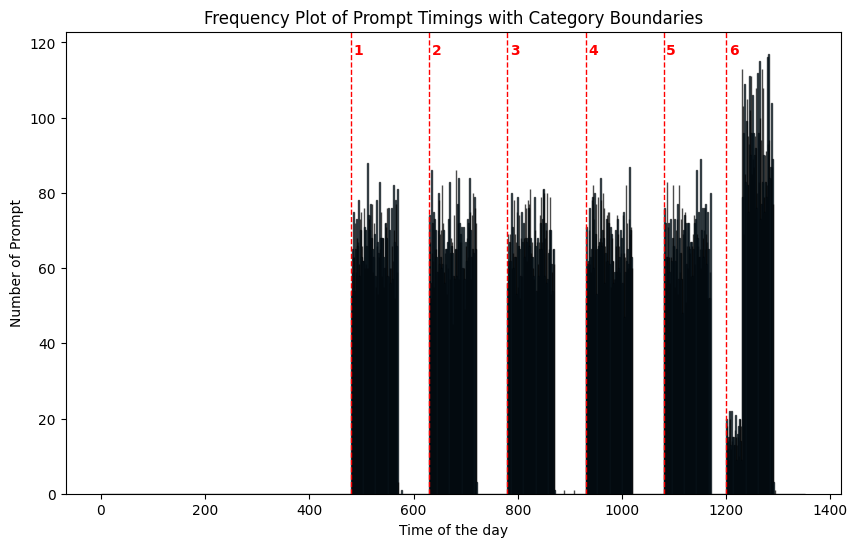

In [120]:
import matplotlib.pyplot as plt

# Assuming you have created the 'time_of_the_day_categories' column as described in the adapted code
plt.figure(figsize=(10, 6))
bins = range(0, int(df_ema['time_in_minutes'].max()) + 60, 1)
plt.hist(df_ema['time_in_minutes'], bins=bins, edgecolor='black', alpha=0.7)

# Set x-axis ticks to represent hours in a 24-hour format with hourly intervals
hour_ticks = range(0, int(df_ema['time_in_minutes'].max()) + 60, 60)
hour_labels = ['12a', '1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p', '9p', '10p', '11p', '12a']

# Add vertical lines for each time category boundary
category_boundaries = [480, 630, 780, 930, 1080, 1200]
for i, boundary in enumerate(category_boundaries):
    plt.axvline(boundary, color='red', linestyle='--', linewidth=1)
    plt.text(boundary + 5, plt.ylim()[1] * 0.95, str(i + 1), color='red', fontweight='bold')

# Labeling the plot
plt.title('Frequency Plot of Prompt Timings with Category Boundaries')
plt.xlabel('Time of the day')
plt.ylabel('Number of Prompt')

# Show the plot
plt.show()


In [121]:
# Assuming you have created the 'time_of_the_day_categories' column as described in the previous response
time_of_day_counts = df_ema['time_of_the_day_categories'].value_counts()

# Define explanations for each category
category_explanations = {
    0: '12am - 8am',
    1: '8am - 10:29am',
    2: '10:30am - 12:59pm',
    3: '1pm - 3:29pm',
    4: '3:30pm - 5:59pm',
    5: '6pm - 8:29pm',
    6: '8:30pm - 11:59pm'
}

# Sort the counts based on the category
sorted_counts = time_of_day_counts.sort_index()

# Display the counts and their corresponding categories with explanations
print("Time of the Day Categories:")
for category, count in sorted_counts.items():
    explanation = category_explanations[category]
    print(f"Category {category}: {explanation} - Count: {count}")


Time of the Day Categories:
Category 0: 12am - 8am - Count: 0
Category 1: 8am - 10:29am - Count: 6021
Category 2: 10:30am - 12:59pm - Count: 6021
Category 3: 1pm - 3:29pm - Count: 6021
Category 4: 3:30pm - 5:59pm - Count: 6021
Category 5: 6pm - 8:29pm - Count: 6021
Category 6: 8:30pm - 11:59pm - Count: 6021


#### Build sleep quality feature

In [122]:
# Create a new column 'sleep_quality' and assign values from '[1_VAS] How would you rate your overall sleep quality?&nb'
df_ema['sleep_quality'] = df_ema['[1_VAS]  How would you rate your overall sleep quality?&nb']

# Convert 'Issued Time' to datetime if it's not already
df_ema['Issued Time'] = pd.to_datetime(df_ema['Issued Time'])

# Sort DataFrame by 'Issued Time'
df_ema = df_ema.sort_values(by='Issued Time')

# Iterate over unique participant IDs
for participant_id in df_ema['Subject_ID_Roman_x'].unique():
    # Select rows for the current participant
    participant_df = df_ema[df_ema['Subject_ID_Roman_x'] == participant_id].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    # Forward-fill the sleep quality values within each date group for the current participant
    participant_df['sleep_quality'] = participant_df.groupby(participant_df['Issued Time'].dt.date)['sleep_quality'].transform(lambda x: x.ffill().bfill())
    
    # Update the original DataFrame with the modified values
    df_ema.loc[participant_df.index, 'sleep_quality'] = participant_df['sleep_quality']


In [123]:
df_ema.head()

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   
23358        2023006-00146A     2023006-00146A            47144   
23359        2023006-00402A     2023006-00402A            47145   
28168        2023006-00402A     2023006-00402A            47145   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   
23358  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 11:31:06   
23359  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 11:52:51   
28168  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 13:35:19   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   
23358 2022-01-16 11:31:06 2022-01-16 11:41:35   
23359 2022-01-16 11:52:51 2022-01-16 12:52:51   
28168 2022-01-16 13:35:19 2022-01-16 14:20:35   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   
23358                                            629.781                16.0   
23359                                                NaN                 NaN   
28168                                           2716.115               118.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   
23358         613.781  1.321435 103.885358   
23359             NaN                 None   
28168        2598.115  1.289887 103.829771   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   
23358                                         None                      None   
23359                                         None                      None   
28168                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   
23358                        None                         True   
23359                        None                         None   
28168                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         
23358                                               None         
23359                                               None         
28168                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   
23358                None            None                       True   
23359                None            None                       None   
28168                None            None                       True   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   
23358                                        None                 None   
23359                                        None                 None   
28168                                        True                 None   

      [2_MAQ_11] h

In [124]:
df_ema['sleep_quality'].value_counts()

sleep_quality
4.0    8661
3.0    7666
5.0    6706
2.0    3277
6.0    2974
1.0    1187
0.0     276
Name: count, dtype: int64

In [125]:
df_ema['sleep_quality'].isna().sum()

5379

In [126]:
df_ema['sleep_quality'].notna().sum()

30747

In [127]:
df_ema.head()

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   
23358        2023006-00146A     2023006-00146A            47144   
23359        2023006-00402A     2023006-00402A            47145   
28168        2023006-00402A     2023006-00402A            47145   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   
23358  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 11:31:06   
23359  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 11:52:51   
28168  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 13:35:19   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   
23358 2022-01-16 11:31:06 2022-01-16 11:41:35   
23359 2022-01-16 11:52:51 2022-01-16 12:52:51   
28168 2022-01-16 13:35:19 2022-01-16 14:20:35   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   
23358                                            629.781                16.0   
23359                                                NaN                 NaN   
28168                                           2716.115               118.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   
23358         613.781  1.321435 103.885358   
23359             NaN                 None   
28168        2598.115  1.289887 103.829771   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   
23358                                         None                      None   
23359                                         None                      None   
28168                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   
23358                        None                         True   
23359                        None                         None   
28168                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         
23358                                               None         
23359                                               None         
28168                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   
23358                None            None                       True   
23359                None            None                       None   
28168                None            None                       True   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   
23358                                        None                 None   
23359                                        None                 None   
28168                                        True                 None   

      [2_MAQ_11] h

#### Build number of study survey feature

In [128]:
df_ema['Issued Time'] = pd.to_datetime(df_ema['Issued Time'])  # Convert to datetime if not already

# Initialize a new column 'number of survey'
df_ema['number_of_survey'] = 0

# Iterate through each unique participant ID
for participant_id in df_ema['Subject_ID_Roman_x'].unique():
    # Filter rows for the current participant
    participant_rows = df_ema[df_ema['Subject_ID_Roman_x'] == participant_id]
    
    # Sort the participant rows based on 'issued time'
    sorted_rows = participant_rows.sort_values(by='Issued Time')
    
    # Assign 'number of survey' based on the sorted order
    df_ema.loc[sorted_rows.index, 'number_of_survey'] = range(1, len(sorted_rows) + 1)


In [129]:
user_category_counts = df_ema.groupby('Subject_ID_Roman_x')['number_of_survey'].nunique()

# Check if all users have exactly one of all 54 categories
all_categories_present = all(user_category_counts == 54)

if all_categories_present:
    print("Every user has exactly one of all 54 categories.")
else:
    print("Not every user has exactly one of all 54 categories.")


Every user has exactly one of all 54 categories.


In [130]:
df_ema['number_of_survey'].value_counts()

number_of_survey
1     669
41    669
30    669
31    669
32    669
33    669
34    669
35    669
36    669
37    669
38    669
39    669
40    669
42    669
2     669
43    669
44    669
45    669
46    669
47    669
48    669
49    669
50    669
51    669
52    669
53    669
29    669
28    669
27    669
26    669
3     669
4     669
5     669
6     669
7     669
8     669
9     669
10    669
11    669
12    669
13    669
14    669
15    669
16    669
17    669
18    669
19    669
20    669
21    669
22    669
23    669
24    669
25    669
54    669
Name: count, dtype: int64

#### Build day in study/days of monitoring feature

In [131]:
# Count rows with non-normal time stamps (NaT values)
non_normal_count = df_ema['Issued Time'].isna().sum()

print(f"Number of rows with non-normal time stamps: {non_normal_count}")

Number of rows with non-normal time stamps: 268


In [132]:
# Count rows with non-normal time stamps (NaT values)
non_normal_count = df_ema['Scheduled Time'].isna().sum()

print(f"Number of rows with non-normal time stamps: {non_normal_count}")

Number of rows with non-normal time stamps: 0


In [133]:
df_ema['Issued Time'] = pd.to_datetime(df_ema['Issued Time'])

# Group by 'Subject_ID_Roman_x'
for participant_id, data in tqdm(df_ema.groupby('Subject_ID_Roman_x')):
    # Filter out rows with valid 'Issued Time'
    data = data.dropna(subset=['Issued Time'])

    if not data.empty:  # Proceed if there's data after dropping NaT values
        unique_dates = sorted(data['Issued Time'].dt.date.unique())
        date_label_mapping = {date: i + 1 for i, date in enumerate(unique_dates)}
        data['day_of_monitoring'] = data['Issued Time'].dt.date.map(date_label_mapping)
        df_ema.loc[data.index, 'day_of_monitoring'] = data['day_of_monitoring']


  0%|                                           | 1/669 [00:00<01:47,  6.19it/s]/tmp/ipykernel_94075/435004852.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_monitoring'] = data['Issued Time'].dt.date.map(date_label_mapping)
/tmp/ipykernel_94075/435004852.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_monitoring'] = data['Issued Time'].dt.date.map(date_label_mapping)
 12%|█████                                    | 82/669 [00:00<00:02, 216.91it/s]/tmp/ipykernel_94075/435

In [134]:
df_ema['day_of_monitoring'].value_counts()

day_of_monitoring
1.0     4005
5.0     3999
2.0     3996
3.0     3996
4.0     3994
6.0     3982
7.0     3966
8.0     3960
9.0     3959
10.0       1
Name: count, dtype: int64

In [135]:
category_counts = df_ema.groupby(['Subject_ID_Roman_left', 'day_of_monitoring']).size().unstack(fill_value=0)

# Identify subject IDs for each category
subjects_category_1 = category_counts[category_counts[1] != 6].index.tolist()
subjects_category_2 = category_counts[category_counts[2] != 6].index.tolist()
subjects_category_3 = category_counts[category_counts[3] != 6].index.tolist()
subjects_category_4 = category_counts[category_counts[4] != 6].index.tolist()
subjects_category_5 = category_counts[category_counts[5] != 6].index.tolist()
subjects_category_6 = category_counts[category_counts[6] != 6].index.tolist()
subjects_category_7 = category_counts[category_counts[7] != 6].index.tolist()
subjects_category_8 = category_counts[category_counts[8] != 6].index.tolist()
subjects_category_9 = category_counts[category_counts[9] != 6].index.tolist()

# Combine all subject IDs for each category
all_subjects = set(subjects_category_1) | set(subjects_category_2) | set(subjects_category_3) | set(subjects_category_4) | set(subjects_category_5) | set(subjects_category_6) | set(subjects_category_7) | set(subjects_category_8) | set(subjects_category_9)

# Create a new object to store the result
combined_subjects = list(all_subjects)

# Count the number of surveys for each participant in each category
survey_counts = {}
for subject in combined_subjects:
    survey_counts[subject] = {}
    for category in range(1, 10):
        if subject in category_counts.index:
            survey_counts[subject][category] = category_counts.loc[subject, category]
        else:
            survey_counts[subject][category] = 0

# Print the survey counts for each participant in each category
for subject, counts in survey_counts.items():
    print(f"Subject ID: {subject}")
    for category, count in counts.items():
        print(f"Category {category}: {count} surveys")
    print()


Subject ID: 2023006-00131A
Category 1: 6 surveys
Category 2: 6 surveys
Category 3: 6 surveys
Category 4: 6 surveys
Category 5: 6 surveys
Category 6: 6 surveys
Category 7: 5 surveys
Category 8: 6 surveys
Category 9: 6 surveys

Subject ID: 2023006-00147A
Category 1: 6 surveys
Category 2: 6 surveys
Category 3: 6 surveys
Category 4: 6 surveys
Category 5: 6 surveys
Category 6: 5 surveys
Category 7: 6 surveys
Category 8: 6 surveys
Category 9: 6 surveys

Subject ID: 2023006-00369A
Category 1: 6 surveys
Category 2: 6 surveys
Category 3: 6 surveys
Category 4: 6 surveys
Category 5: 6 surveys
Category 6: 5 surveys
Category 7: 6 surveys
Category 8: 6 surveys
Category 9: 6 surveys

Subject ID: 2023006-00387A
Category 1: 6 surveys
Category 2: 6 surveys
Category 3: 6 surveys
Category 4: 5 surveys
Category 5: 6 surveys
Category 6: 6 surveys
Category 7: 6 surveys
Category 8: 6 surveys
Category 9: 6 surveys

Subject ID: 2023006-00357A
Category 1: 6 surveys
Category 2: 6 surveys
Category 3: 6 surveys
Cat

In [136]:
category_counts = df_ema.groupby(['Subject_ID_Roman_left', 'day_of_monitoring']).size().unstack(fill_value=0)
# Identify subject IDs for each category
subjects_category_1 = category_counts[category_counts[1] == 6].index.tolist()
subjects_category_2 = category_counts[category_counts[2] == 6].index.tolist()
subjects_category_3 = category_counts[category_counts[3] == 6].index.tolist()
subjects_category_4 = category_counts[category_counts[4] == 6].index.tolist()
subjects_category_5 = category_counts[category_counts[5] == 6].index.tolist()
subjects_category_6 = category_counts[category_counts[6] == 6].index.tolist()
subjects_category_7 = category_counts[category_counts[7] == 6].index.tolist()
subjects_category_8 = category_counts[category_counts[8] == 6].index.tolist()
subjects_category_9 = category_counts[category_counts[9] == 6].index.tolist()
# Check if there are exactly 9 occurrences for each category
are_counts_equal_9 = all(category_counts[i].eq(6).all() for i in range(1, 10))

In [137]:
# Combine all subject IDs for each category
all_subjects = set(subjects_category_1) & set(subjects_category_2) & set(subjects_category_3) & set(subjects_category_4) & set(subjects_category_5) & set(subjects_category_6) & set(subjects_category_7) & set(subjects_category_8) & set(subjects_category_9)
# Create a new object to store the result
combined_subjects = list(all_subjects)

In [138]:
len(combined_subjects)

629

In [139]:
# Combine all subject IDs for each category
all_subjects = set(subjects_category_1) & set(subjects_category_2) & set(subjects_category_3) & set(subjects_category_4) & set(subjects_category_5) & set(subjects_category_6) & set(subjects_category_7) & set(subjects_category_8) & set(subjects_category_9) 

# Identify subject IDs not in all categories
not_in_all_categories = set(df_ema['Subject_ID_Roman_left'].unique()) - all_subjects

# Create a list of subject IDs not in all categories
not_in_all_categories_list = list(not_in_all_categories)

In [140]:
print(not_in_all_categories)

{'2023006-00131A', '2023006-00147A', '2023006-00369A', '2023006-00135A', '2023006-00357A', '2023006-00387A', '2023006-00155A', '2023006-00129A', '2023006-00628A', '2023006-00614A', '2023006-00421A', '2023006-00219A', '2023006-00008A', '2023006-00445A', '2023006-00636A', '2023006-00640A', '2023006-00630A', '2023006-00621A', '2023006-00292A', '2023006-00559A', '2023006-00108A', '2023006-00189A', '2023006-00002A', '2023006-00596A', '2023006-00323A', '2023006-00150A', '2023006-00226A', '2023006-00254A', '2023006-00154A', '2023006-00207A', '2023006-00604A', '2023006-00653A', '2023006-00244A', '2023006-00570A', '2023006-00340A', '2023006-00102A', '2023006-00436A', '2023006-00431A', '2023006-00462A', '2023006-00463A'}


In [141]:
len(not_in_all_categories_list)

40

In [142]:
not_in_all_categories_list = pd.DataFrame(not_in_all_categories_list)
not_in_all_categories_list.to_csv(f'../outputs/participant_not_all_surveys_issued_or_10_days.csv', index=False)

In [143]:
# Filter the df_ema DataFrame based on the subject IDs in not_in_all_categories_list
df_ema_filtered = df_ema[df_ema['Subject_ID_Roman_x'].isin(not_in_all_categories_list)]

# Sort the filtered DataFrame by Participant ID and Issued Time
df_ema_filtered_sorted = df_ema_filtered.sort_values(['Subject_ID_Roman_x', 'Issued Time'])

# Reset the index of the sorted DataFrame
df_ema_filtered_sorted_reindexed = df_ema_filtered_sorted.reset_index(drop=True)

# Create a boolean mask for participant IDs with at least one row having NaT value in 'Issued Time'
mask = df_ema_filtered_sorted_reindexed.groupby('Subject_ID_Roman_x')['Issued Time'].transform(lambda x: x.isnull().any())

# Filter the DataFrame based on the mask
df_filtered_missing_issued_time = df_ema_filtered_sorted_reindexed[mask]
df_filtered_other_issue = df_ema_filtered_sorted_reindexed[~mask]


From 619 users 37 users did not have exactly 9 values in the day_of_monitoring category, so remaining now are: 619-37 = 582 users

In [144]:
df_ema = df_ema[df_ema['Subject_ID_Roman_left'].isin(combined_subjects)]


In [145]:
len(df_ema)

33966

In [146]:
df_ema['day_of_monitoring'].value_counts()

day_of_monitoring
1.0    3774
2.0    3774
3.0    3774
4.0    3774
5.0    3774
6.0    3774
7.0    3774
8.0    3774
9.0    3774
Name: count, dtype: int64

In [147]:
df_ema['Subject_ID_Roman_x'].nunique()

629

#### Build day of the week feature

In [148]:
df_ema['day_of_the_week'] = df_ema['Issued Time'].dt.dayofweek + 1

In [149]:
df_ema['day_of_the_week'].value_counts()

day_of_the_week
7    5394
6    5382
3    5106
5    4596
1    4584
4    4506
2    4398
Name: count, dtype: int64

In [150]:
df_ema['day_of_the_week'].isna().sum()

0

In [151]:
df_ema['day_of_the_week'].notna().sum()

33966

In [152]:
df_ema.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
21985               None                           None   
21984               None                           None   

      [2_MAQ_13] praying/meditation               [3_FFT] Please describe  \
21985                          None                                  None   
21984                          True  washing up/showering, brushing teeth   

      [4_MAQ_1] Meal [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
21985           None                     None            None         None   
21984           True                     None            True         None   

      [5_CAL]  What time did you eat your meal?  \
21985                                      None   
21984                             0/1/1900 8:30   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
21985                                              None   
21984                                              True   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
21985                                               None             
21984                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
21985                        None                None   
21984                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
21985                                               None        
21984                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
21985                                       None                 None   
21984                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
21985             None                               None   
21984             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puf

In [153]:
day_of_week_dummies = pd.get_dummies(df_ema['day_of_the_week'])

# Rename columns to match your specified format
day_of_week_dummies.columns = [
    'day_of_week_monday',
    'day_of_week_tuesday',
    'day_of_week_wednesday',
    'day_of_week_thursday',
    'day_of_week_friday',
    'day_of_week_saturday',
    'day_of_week_sunday'
]

# Concatenate the dummy variables with the original DataFrame
df_ema = pd.concat([df_ema, day_of_week_dummies], axis=1)


In [154]:
df_ema['day_of_the_week_dummy'] = df_ema['day_of_the_week']

# Replace all 1 values with NA in the 'time_of_the_week_dummy' column
df_ema.loc[df_ema['day_of_the_week_dummy'] == 1, 'day_of_the_week_dummy'] = pd.NA


In [155]:
df_ema['day_of_the_week_dummy'].value_counts()

day_of_the_week_dummy
7.0    5394
6.0    5382
3.0    5106
5.0    4596
4.0    4506
2.0    4398
Name: count, dtype: int64

##### Day of Week Bindary (weekday vs. weekend)

In [156]:
df_ema['day_of_the_week_binary'] = np.where(
    df_ema['day_of_the_week'].isin([1, 2, 3, 4, 5]),  # Label as 0 for values 1, 2, 3, 4, 5
    0, 
    np.where(
        df_ema['day_of_the_week'].isin([6, 7]),  # Label as 1 for values 6, 7
        1,
        np.nan  # Preserve NaN values
    )
)


In [157]:
df_ema['day_of_the_week_binary'].value_counts()

day_of_the_week_binary
0.0    23190
1.0    10776
Name: count, dtype: int64

In [158]:
df_ema.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
21985               None                           None   
21984               None                           None   

      [2_MAQ_13] praying/meditation               [3_FFT] Please describe  \
21985                          None                                  None   
21984                          True  washing up/showering, brushing teeth   

      [4_MAQ_1] Meal [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
21985           None                     None            None         None   
21984           True                     None            True         None   

      [5_CAL]  What time did you eat your meal?  \
21985                                      None   
21984                             0/1/1900 8:30   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
21985                                              None   
21984                                              True   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
21985                                               None             
21984                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
21985                        None                None   
21984                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
21985                                               None        
21984                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
21985                                       None                 None   
21984                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
21985             None                               None   
21984             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puf

#### Build incentives feature

Labels incentives:

1: Incentive category - 30$ (had at least 1 survey on a date before the 20th of September 2022)

0: Incentive category - 20$  (Person joined the study on or after the 20th of September 2022)

In [159]:
df_ema['incentive_category'] = (df_ema['Scheduled Time'] < '2022-09-20').astype(int)


In [160]:
# Create a mask for rows where 'scheduled time' is before '2023-09-20'
mask = df_ema['Scheduled Time'] < '2022-09-20'

# Find unique participants meeting the condition
participants_with_condition = df_ema.loc[mask, 'Subject_ID_Roman_x'].unique()

# Update 'incentive category' based on the condition for each participant
for participant in participants_with_condition:
    df_ema.loc[df_ema['Subject_ID_Roman_x'] == participant, 'incentive_category'] = 1

# Fill NaN values with 0 in the 'incentive category' column
df_ema['incentive_category'].fillna(0, inplace=True)



In [161]:
df_ema['incentive_category'].value_counts()

incentive_category
1    17874
0    16092
Name: count, dtype: int64

#### Build joining date feature

In [162]:

# Create 'joining day' column
df_ema['Scheduled Time'] = pd.to_datetime(df_ema['Scheduled Time'])  # Convert to datetime if not already in datetime format
df_ema['joining day'] = df_ema['Scheduled Time'].dt.day_name()

# Find the oldest 'Scheduled time' for each participant
oldest_times = df_ema.groupby('Subject_ID_Roman_x')['Scheduled Time'].min()

# Iterate through unique participants to get the oldest 'joining day'
for participant, oldest_time in oldest_times.items():
    oldest_day = df_ema.loc[(df_ema['Subject_ID_Roman_x'] == participant) & (df_ema['Scheduled Time'] == oldest_time), 'joining day']
    if not oldest_day.empty:  # Check if any matching record is found
        oldest_day = oldest_day.values[0]  # Extract the value
        df_ema.loc[df_ema['Subject_ID_Roman_x'] == participant, 'joining day'] = oldest_day

In [163]:
# Assuming 'df_ema' is your DataFrame and 'Subject_ID_Roman_x' contains participant IDs

unique_participant_day_counts = df_ema.groupby(['Subject_ID_Roman_x', 'joining day']).size().reset_index(name='Count')

# Count the unique occurrences of each 'joining day'
unique_day_counts = unique_participant_day_counts['joining day'].value_counts()

unique_day_counts


joining day
Sunday       135
Saturday     135
Friday       133
Wednesday    118
Tuesday      104
Thursday       4
Name: count, dtype: int64

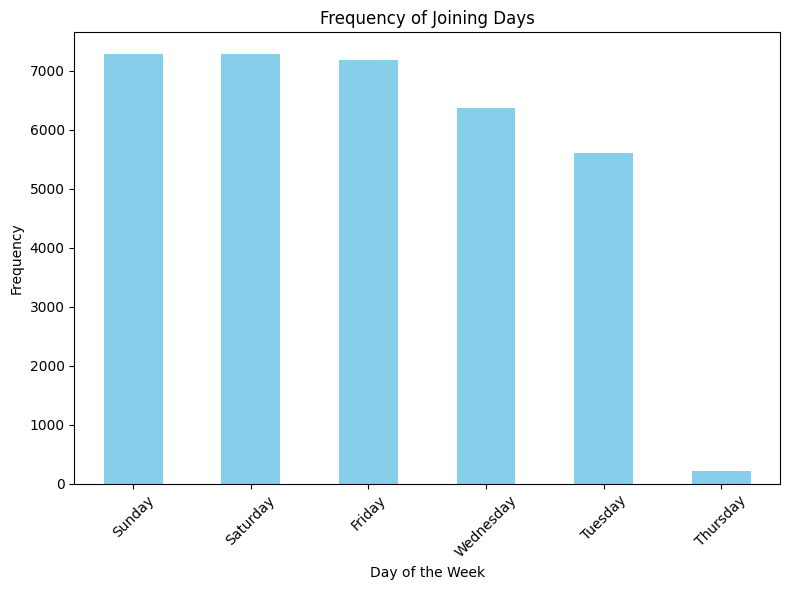

In [164]:
# Count the frequencies of each day
day_counts = df_ema['joining day'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
day_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Joining Days')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

#### Building survey length feature

In [165]:
start_column = '[2_MAQ_1] eating/drinking (other than water)'
end_column = '[17_MAQ_6] I wanted to please others who wanted me to eat it'

# Create a new column "survey length" and count non-NaN or non-None values for the specified range of columns
df_ema['survey length'] = df_ema.loc[:, start_column:end_column].count(axis=1)


In [166]:
df_ema['survey length'] = df_ema.loc[:, start_column:end_column].apply(lambda row: row.drop('src').count(), axis=1)


Survey_length - 4 is done to center the survey length feature

In [167]:
df_ema['survey length'] = df_ema['survey length'] - 4

In [168]:
df_ema['survey length'].describe()

count    33966.000000
mean         7.885444
std          7.963170
min         -4.000000
25%          1.000000
50%          7.000000
75%         13.000000
max         49.000000
Name: survey length, dtype: float64

#### Build "what have you been doing since last prompt?" - feature as fidelity-check, aka. First_question_length?

In [169]:
start_column = '[2_MAQ_1] eating/drinking (other than water)'
end_column = '[2_MAQ_13] praying/meditation'

# Create a new column "survey length" and count non-NaN or non-None values for the specified range of columns
df_ema['First_question_length'] = df_ema.loc[:, start_column:end_column].count(axis=1)


In [170]:
df_ema['nothing'] = df_ema['[2_MAQ_6] nothing\r'].map({True: 1, False: 0})

# Handling None values by replacing them with 0
df_ema['nothing'].fillna(0, inplace=True)

# Convert the column to integer type
df_ema['nothing'] = df_ema['nothing'].astype(int)


In [171]:
df_ema['nothing'].value_counts()

nothing
0    33001
1      965
Name: count, dtype: int64

In [172]:
df_try=df_ema.copy()

In [173]:
df_not = df_ema[df_ema['[2_MAQ_6] nothing\r'].notna()].copy()

In [174]:
df_not.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
10994        2023006-00508A     2023006-00508A            47636   
19238        2023006-00508A     2023006-00508A            47636   

              Device ID      Scheduled Time         Issued Time  \
10994  b5d6b06e3e3283eb 2022-01-22 16:48:33 2022-01-22 16:58:33   
19238  b5d6b06e3e3283eb 2022-01-23 08:07:07 2022-01-23 08:17:07   

            Response Time  \
10994 2022-01-22 17:19:50   
19238 2022-01-23 08:38:28   

       Duration (seconds) from scheduled to completion time  completion_time  \
10994                                           1877.930                43.0   
19238                                           1881.986               110.0   

       response delay             Location  \
10994        1234.930  1.340944 103.740910   
19238        1171.986  1.339017 103.735091   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
10994                                         None                      None   
19238                                         None                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
10994                        None                         True   
19238                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
10994                                               None         
19238                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
10994                True            None                       None   
19238                True            None                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
10994                                        True                 None   
19238                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
10994               None                           None   
19238               None                           None   

      [2_MAQ_13] praying/meditation [3_FFT] Please describe [4_MAQ_1] Meal  \
10994                          None                    None           None   
19238                          None                    None           None   

      [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
10994                     None            None         None   
19238                     None            None         None   

      [5_CAL]  What time did you eat your meal?  \
10994                                      None   
19238                                      None   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
10994                                              None   
19238                                              None   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
10994                                               None             
19238                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
10994                        None                None   
19238                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
10994                                               None        
19238                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
10994                                       None                 None   
19238                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
10994             None                               None   
19238             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puffs, samosas, French   \
10994                                               None          

In [175]:
df_not['First_question_length'].value_counts()

First_question_length
1    705
2    169
3     58
4     24
5      8
6      1
Name: count, dtype: int64

In [176]:
df_ema.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
21985               None                           None   
21984               None                           None   

      [2_MAQ_13] praying/meditation               [3_FFT] Please describe  \
21985                          None                                  None   
21984                          True  washing up/showering, brushing teeth   

      [4_MAQ_1] Meal [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
21985           None                     None            None         None   
21984           True                     None            True         None   

      [5_CAL]  What time did you eat your meal?  \
21985                                      None   
21984                             0/1/1900 8:30   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
21985                                              None   
21984                                              True   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
21985                                               None             
21984                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
21985                        None                None   
21984                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
21985                                               None        
21984                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
21985                                       None                 None   
21984                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
21985             None                               None   
21984             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puf

In [177]:
df_ema['First_question_length'].value_counts()

First_question_length
1     12786
2      8622
3      5273
0      4109
4      2229
5       681
6       190
7        52
8        19
9         3
10        2
Name: count, dtype: int64

#### Build Social setting feature

In [178]:
df_ema.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
21985               None                           None   
21984               None                           None   

      [2_MAQ_13] praying/meditation               [3_FFT] Please describe  \
21985                          None                                  None   
21984                          True  washing up/showering, brushing teeth   

      [4_MAQ_1] Meal [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
21985           None                     None            None         None   
21984           True                     None            True         None   

      [5_CAL]  What time did you eat your meal?  \
21985                                      None   
21984                             0/1/1900 8:30   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
21985                                              None   
21984                                              True   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
21985                                               None             
21984                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
21985                        None                None   
21984                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
21985                                               None        
21984                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
21985                                       None                 None   
21984                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
21985             None                               None   
21984             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puf

In [179]:
# Assuming df_ema is your DataFrame
# Replace column names accordingly if they are different

# Columns of interest
columns_25 = [ '[25_MAQ_8] other', '[25_MAQ_7] pet\r',
              '[25_MAQ_6] no one\r', '[25_MAQ_5] colleagues/fellow students', '[25_MAQ_4] friends\r',
              '[25_MAQ_3] other family members\r', '[25_MAQ_2] your children\r', '[25_MAQ_1] spouse/partner\r']

columns_60 = [ '[60_MAQ_8] other', '[60_MAQ_7] pet\r',
              '[60_MAQ_6] no one\r', '[60_MAQ_5] colleagues\r', '[60_MAQ_4] friends\r',
              '[60_MAQ_3] other family members\r', '[60_MAQ_2] your children\r', '[60_MAQ_1] spouse/partner\r']

columns_58 = [ '[58_MAQ_8] other', '[58_MAQ_7] pet\r',
              '[58_MAQ_6] no one\r', '[58_MAQ_5] colleagues\r', '[58_MAQ_4] friends\r',
              '[58_MAQ_3] other family members\r', '[58_MAQ_2] your children\r', '[58_MAQ_1] spouse/partner\r']

# Count the number of rows with values in only one column
count_only_25 = (df_ema[columns_25].notna().sum(axis=1) == 1).sum()
count_only_60 = (df_ema[columns_60].notna().sum(axis=1) == 1).sum()
count_only_58 = (df_ema[columns_58].notna().sum(axis=1) == 1).sum()

# Count the number of rows with values in two columns
count_in_25_and_60 = ((df_ema[columns_25].notna() & df_ema[columns_60].notna()).sum(axis=1) == 2).sum()
count_in_25_and_58 = ((df_ema[columns_25].notna() & df_ema[columns_58].notna()).sum(axis=1) == 2).sum()
count_in_60_and_58 = ((df_ema[columns_60].notna() & df_ema[columns_58].notna()).sum(axis=1) == 2).sum()

# Count the number of rows with values in all three columns
count_in_all = ((df_ema[columns_25].notna() & df_ema[columns_60].notna() & df_ema[columns_58].notna()).sum(axis=1) == 3).sum()

# Display the counts
print(f'Count of rows with values in only one column - 25: {count_only_25}')
print(f'Count of rows with values in only one column - 60: {count_only_60}')
print(f'Count of rows with values in only one column - 58: {count_only_58}')

print(f'Count of rows with values in two columns (25 and 60): {count_in_25_and_60}')
print(f'Count of rows with values in two columns (25 and 58): {count_in_25_and_58}')
print(f'Count of rows with values in two columns (60 and 58): {count_in_60_and_58}')

print(f'Count of rows with values in all three columns: {count_in_all}')


Count of rows with values in only one column - 25: 1626
Count of rows with values in only one column - 60: 833
Count of rows with values in only one column - 58: 355
Count of rows with values in two columns (25 and 60): 0
Count of rows with values in two columns (25 and 58): 0
Count of rows with values in two columns (60 and 58): 0
Count of rows with values in all three columns: 0


In [180]:
# Combine values for [MAQ_6] no one
df_ema['Social Setting: no one\r'] = df_ema['[25_MAQ_6] no one\r'].combine_first(df_ema['[60_MAQ_6] no one\r']).combine_first(df_ema['[58_MAQ_6] no one\r'])

# Combine values for [MAQ_5] colleagues/fellow students
df_ema['Social Setting: colleagues/fellow students'] = df_ema['[25_MAQ_5] colleagues/fellow students'].combine_first(df_ema['[60_MAQ_5] colleagues\r']).combine_first(df_ema['[58_MAQ_5] colleagues\r'])

# Combine values for [MAQ_4] friends
df_ema['Social Setting: friends\r'] = df_ema['[25_MAQ_4] friends\r'].combine_first(df_ema['[60_MAQ_4] friends\r']).combine_first(df_ema['[58_MAQ_4] friends\r'])

# Combine values for [MAQ_3] other family members
df_ema['Social Setting: other family members\r'] = df_ema['[25_MAQ_3] other family members\r'].combine_first(df_ema['[60_MAQ_3] other family members\r']).combine_first(df_ema['[58_MAQ_3] other family members\r'])

# Combine values for [MAQ_2] your children
df_ema['Social Setting: your children\r'] = df_ema['[25_MAQ_2] your children\r'].combine_first(df_ema['[60_MAQ_2] your children\r']).combine_first(df_ema['[58_MAQ_2] your children\r'])

# Combine values for [MAQ_1] spouse/partner
df_ema['Social Setting: spouse/partner\r'] = df_ema['[25_MAQ_1] spouse/partner\r'].combine_first(df_ema['[60_MAQ_1] spouse/partner\r']).combine_first(df_ema['[58_MAQ_1] spouse/partner\r'])

# Combine values for [MAQ_8] other
df_ema['Social Setting: other'] = df_ema['[25_MAQ_8] other'].combine_first(df_ema['[60_MAQ_8] other']).combine_first(df_ema['[58_MAQ_8] other'])

# Combine values for [MAQ_7] pet
df_ema['Social Setting: pet\r'] = df_ema['[25_MAQ_7] pet\r'].combine_first(df_ema['[60_MAQ_7] pet\r']).combine_first(df_ema['[58_MAQ_7] pet\r'])


In [181]:
# Check the number of rows with at least one value in one of the new columns
new_columns = ['Social Setting: no one\r', 'Social Setting: colleagues/fellow students', 
               'Social Setting: friends\r', 'Social Setting: other family members\r', 
               'Social Setting: your children\r', 'Social Setting: spouse/partner\r', 
               'Social Setting: other', 'Social Setting: pet\r']

rows_with_values = df_ema[new_columns].any(axis=1).sum()

print(f"Number of record with social settings data: {rows_with_values}")


Number of record with social settings data: 2852


In [182]:

# Describe the newly created columns
new_columns_description = df_ema[['Social Setting: no one\r', 'Social Setting: colleagues/fellow students', 
                                   'Social Setting: friends\r', 'Social Setting: other family members\r', 
                                   'Social Setting: your children\r', 'Social Setting: spouse/partner\r', 'Social Setting: other', 'Social Setting: pet\r']].describe()
new_columns_description.head(10)



Social Setting: no one\r Social Setting: colleagues/fellow students  \
count                      1538                                        133   
unique                        1                                          1   
top                        True                                       True   
freq                       1538                                        133   

       Social Setting: friends\r Social Setting: other family members\r  \
count                        430                                    282   
unique                         1                                      1   
top                         True                                   True   
freq                         430                                    282   

       Social Setting: your children\r Social Setting: spouse/partner\r  \
count                              239                              551   
unique                               1                                1   
top                               True                             True   
freq                               239                              551   

       Social Setting: other Social Setting: pet\r  
count                     14                    54  
unique                     1                     1  
top                     True                  True  
freq                      14                    54

As we can see above, there are several rows that have overlapping values

In [183]:
# Count the number of rows with values in the same columns
same_columns_count = df_ema[['[25_MAQ_7] pet\r', '[60_MAQ_7] pet\r', '[58_MAQ_7] pet\r']].count(axis=1)

# Count the number of rows with values in only one column
one_column_count = same_columns_count[same_columns_count == 1].count()

# Count the number of rows with values in two columns
two_columns_count = same_columns_count[same_columns_count == 2].count()

# Count the number of rows with values in all three columns
all_columns_count = same_columns_count[same_columns_count == 3].count()

print(f"Rows with values in the same columns: {all_columns_count}")
print(f"Rows with values in only one column: {one_column_count}")
print(f"Rows with values in two columns: {two_columns_count}")


Rows with values in the same columns: 0
Rows with values in only one column: 52
Rows with values in two columns: 2


In [184]:
df_ema['[60_MAQ_7] pet\r'].value_counts()

[60_MAQ_7] pet\r
True    20
Name: count, dtype: int64

In [185]:
df_ema['[58_MAQ_7] pet\r'].value_counts()

[58_MAQ_7] pet\r
True    4
Name: count, dtype: int64

In [186]:
df_ema['[25_MAQ_7] pet\r'].value_counts()

[25_MAQ_7] pet\r
True    32
Name: count, dtype: int64

In [187]:
df_ema.head(5)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   
23358        2023006-00146A     2023006-00146A            47144   
23359        2023006-00402A     2023006-00402A            47145   
28168        2023006-00402A     2023006-00402A            47145   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   
23358  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 11:31:06   
23359  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 11:52:51   
28168  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 13:35:19   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   
23358 2022-01-16 11:31:06 2022-01-16 11:41:35   
23359 2022-01-16 11:52:51 2022-01-16 12:52:51   
28168 2022-01-16 13:35:19 2022-01-16 14:20:35   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   
23358                                            629.781                16.0   
23359                                                NaN                 NaN   
28168                                           2716.115               118.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   
23358         613.781  1.321435 103.885358   
23359             NaN                 None   
28168        2598.115  1.289887 103.829771   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   
23358                                         None                      None   
23359                                         None                      None   
28168                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   
23358                        None                         True   
23359                        None                         None   
28168                        None                         None   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         
23358                                               None         
23359                                               None         
28168                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   
23358                None            None                       True   
23359                None            None                       None   
28168                None            None                       True   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   
23358                                        None                 None   
23359                                        None                 None   
28168                                        True                 None   

      [2_MAQ_11] h

Finding:
1. Values can only in of those 3 questions (questions can never be asked more than once, which avoids repetition or contradiction and is good). 
2. Only around 3000 rows have even values here, so quite a lot of missing data... --> Would multiple imputation be an option?


#### Build Location features

In [188]:
rows_with_values_in_both = df_ema[['[29_SAQ]  Where are you right now?', '[42_SAQ]  Where are you right now?']].notna().all(axis=1)

# Count the number of rows meeting the criteria
count_rows_with_both_values = rows_with_values_in_both.sum()

# Display the count
print(f'Count of rows with values in both columns: {count_rows_with_both_values}')


Count of rows with values in both columns: 20


In [189]:
rows_with_values_in_both = df_ema[['[29_SAQ]  Where are you right now?', '[42_SAQ]  Where are you right now?']].notna().all(axis=1)

# Create a new DataFrame with only the rows meeting the criteria
df_both_values = df_ema[rows_with_values_in_both].copy()

# Display the new DataFrame
print(df_both_values[['[29_SAQ]  Where are you right now?', '[42_SAQ]  Where are you right now?']])


       [29_SAQ]  Where are you right now?  [42_SAQ]  Where are you right now?
17181                                 7.0                                 2.0
26206                                 5.0                                 5.0
29065                                 7.0                                 7.0
26447                                 1.0                                 1.0
9241                                  1.0                                 1.0
14081                                 4.0                                 4.0
30568                                 3.0                                 3.0
15453                                 3.0                                 3.0
31253                                 3.0                                 3.0
8583                                  7.0                                 7.0
34688                                 4.0                                 4.0
29879                                 1.0                       

--> There seem to be 23 rows which have values in both columns [29_SAQ]  Where are you right now?  [42_SAQ]  Where are you right now? but in almost all instances, the entered values are the same. Therefore, merging both columns to Location_Q seems to have been successful and it can be used as Location-self-report feature. 

Legend labelling - Location Q:
1: in my home
2: at my work
3: somewhere on my commute to work or home
4: indoors elsewhere
5: outdoors around my home
6: outdoors in parks or green space
7: ?

In [190]:
column_29_SAQ = '[29_SAQ]  Where are you right now?'
column_42_SAQ = '[42_SAQ]  Where are you right now?'

# Create a new column Location_Q
df_ema['Location_Current_Ordinal'] = df_ema[column_29_SAQ].combine_first(df_ema[column_42_SAQ])


In [191]:

label_mapping = {
    1: 'in my home',
    2: 'at my work',
    3: 'somewhere on my commute to work or home',
    4: 'indoors elsewhere',
    5: 'outdoors around my home',
    6: 'outdoors in parks or green spaces',
    7: 'outdoors elsewhere',
    8: 'other (please describe)'
}

print(df_ema['Location_Current_Ordinal'].value_counts().rename(label_mapping))

Location_Current_Ordinal
in my home                                 1542
outdoors elsewhere                         1227
indoors elsewhere                           755
somewhere on my commute to work or home     631
at my work                                  407
outdoors around my home                     209
other (please describe)                     201
outdoors in parks or green spaces            70
Name: count, dtype: int64


In [192]:

# Mapping of categories
category_mapping = {
    1: 'location_current_home',
    2: 'location_current_work',
    3: 'location_current_commute',
    4: 'location_current_indoors_elsewhere',
    5: 'location_current_home_outside',
    6: 'location_current_green_spaces',
    7: 'location_current_outdoors_elsewhere',
    8: 'location_current_other'
}

# Create dummy variables with NA handling
dummy_columns = pd.get_dummies(df_ema['Location_Current_Ordinal'].map(category_mapping), dummy_na=True)

# Concatenate dummy variables to the original DataFrame
df_ema = pd.concat([df_ema, dummy_columns], axis=1)


In [193]:
df_ema['Location_Current_Ordinal'].isna().sum()

28924

In [194]:

print("Number of record with social settings data:", df_ema['Location_Current_Ordinal'].count())

Number of record with social settings data: 5042


#### Exclude all df_ema['time_of_the_day_categories'] = nighttime values as they mess up the auto-correlation analysis

In [195]:
df_ema = df_ema[df_ema['time_of_the_day_categories'] != 0 ] 

#### Export features df

In [196]:
df_ema['Duration (seconds) from scheduled to completion time'] = pd.to_numeric(df_ema['Duration (seconds) from scheduled to completion time'], errors='coerce')

In [197]:
df_ema.to_parquet(f'../outputs/targetsEMA_features.parquet', index=False)

#### Export clean

In [198]:
df_ema.head(2)

Subject_ID_Roman_left Subject_ID_Roman_x  ID - Ethica EMA  \
21985        2023006-00402A     2023006-00402A            47145   
21984        2023006-00146A     2023006-00146A            47144   

                              Device ID      Scheduled Time  \
21985  EC77B6EAED3341A088011364EFEFCD34 2022-01-16 08:12:27   
21984  4D7296C6632540CEB41546939C8F3EA2 2022-01-16 09:18:10   

              Issued Time       Response Time  \
21985 2022-01-16 08:12:27 2022-01-16 09:12:27   
21984 2022-01-16 09:18:10 2022-01-16 09:31:10   

       Duration (seconds) from scheduled to completion time  completion_time  \
21985                                                NaN               141.0   
21984                                            780.993               154.0   

       response delay             Location  \
21985             NaN  1.289632 103.829577   
21984         626.993  1.320884 103.885386   

      [2_MAQ_1] eating/drinking (other than water) [2_MAQ_2] sports/exercise  \
21985                                         None                      None   
21984                                         True                      None   

      [2_MAQ_3] going somewhere\r [2_MAQ_4] resting/sleeping\r  \
21985                        None                         True   
21984                        None                         True   

      [2_MAQ_5] using a screen (e.g., phone, tablet, computer)  \
21985                                               None         
21984                                               None         

      [2_MAQ_6] nothing\r [2_MAQ_7] Other [2_MAQ_8] working/studying  \
21985                None            None                       None   
21984                None            True                       None   

      [2_MAQ_9] household chores/cooking/shopping [2_MAQ_10] childcare  \
21985                                        None                 None   
21984                                        None                 None   

      [2_MAQ_11] hobbies [2_MAQ_12] talking/socialising  \
21985               None                           None   
21984               None                           None   

      [2_MAQ_13] praying/meditation               [3_FFT] Please describe  \
21985                          None                                  None   
21984                          True  washing up/showering, brushing teeth   

      [4_MAQ_1] Meal [4_MAQ_2] Snack/desserts [4_MAQ_3] Drink [4_MAQ_4] No  \
21985           None                     None            None         None   
21984           True                     None            True         None   

      [5_CAL]  What time did you eat your meal?  \
21985                                      None   
21984                             0/1/1900 8:30   

      [6_MAQ_1] white rice/noodles/pasta/bread/cereal\r  \
21985                                              None   
21984                                              True   

      [6_MAQ_2] brown or wholegrain rice/noodles/pasta/bread/cerea  \
21985                                               None             
21984                                               None             

      [6_MAQ_3] fish or seafood\r [6_MAQ_4] chicken\r  \
21985                        None                None   
21984                        None                None   

      [6_MAQ_5] other meat (e.g., Beef, pork, mutton, lamb)\r  \
21985                                               None        
21984                                               None        

      [6_MAQ_6] soy foods (e.g., tofu, tempeh)\r [6_MAQ_9] vegetables  \
21985                                       None                 None   
21984                                       None                 None   

      [6_MAQ_10] fruit [6_MAQ_11] milk, yoghurt or cheese  \
21985             None                               None   
21984             None                               None   

      [6_MAQ_12] any deep-fried food (e.g., puf

In [199]:
columns_to_keep = ['Subject_ID_Roman_x', 'initial_index_ema', 'Issued Time', 'response delay', 'response_delay_10min', 'compliance', 'completion_time',  'time of the day', 'hour', 'minute', 'time_in_minutes', 'time_of_the_day_categories', 'time_of_the_day_categories_dummy', 'time_of_the_day_categories_dummy_no_last_p' , 'sleep_quality', 'number_of_survey', 'day_of_monitoring', 'day_of_the_week', 'day_of_the_week_dummy', 'incentive_category', 'joining day', 'survey length', 'First_question_length', 'Social Setting: no one\r', 'Social Setting: colleagues/fellow students', 'Social Setting: friends\r', 'Social Setting: other family members\r', 'Social Setting: your children\r', 'Social Setting: spouse/partner\r', 'Social Setting: other', 'Social Setting: pet\r', '[36_VAS] How stressed do you feel right now?', '[37_VAS]  How hungry do you feel right now?', '[38_VAS] How tired do you feel right now?', '[39_VAS] How happy do you feel right now?','Location_Current_Ordinal', 'location_current_commute', 'location_current_green_spaces', 'location_current_home', 'location_current_home_outside', 'location_current_indoors_elsewhere', 'location_current_other', 'time_of_day_nighttime', 'time_of_day_8_to_930', 'time_of_day_1030_to_12', 'time_of_day_13_to_1430','time_of_day_1530_to_17','time_of_day_18_to_1930','time_of_day_2030_to_2130', 'day_of_week_monday', 'day_of_week_tuesday', 'day_of_week_wednesday', 'day_of_week_thursday', 'day_of_week_friday', 'day_of_week_saturday','day_of_week_sunday', 'day_of_the_week_binary', 'nothing']
df_ema = df_ema[columns_to_keep].copy()


In [200]:
df_ema.head(2)

Subject_ID_Roman_x  initial_index_ema         Issued Time  \
21985     2023006-00402A              21985 2022-01-16 08:12:27   
21984     2023006-00146A              21984 2022-01-16 09:18:10   

       response delay  response_delay_10min  compliance  completion_time  \
21985             NaN                   NaN           0            141.0   
21984         626.993                   NaN           1            154.0   

      time of the day  hour  minute  time_in_minutes  \
21985               8   8.0    12.0            492.0   
21984               9   9.0    18.0            558.0   

      time_of_the_day_categories time_of_the_day_categories_dummy  \
21985                          1                                1   
21984                          1                                1   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  \
21985                                          1            5.0   
21984                                          1            4.0   

       number_of_survey  day_of_monitoring  day_of_the_week  \
21985                 1                1.0                7   
21984                 1                1.0                7   

       day_of_the_week_dummy  incentive_category joining day  survey length  \
21985                    7.0                   1      Sunday              3   
21984                    7.0                   1      Sunday             26   

       First_question_length Social Setting: no one\r  \
21985                      1                     None   
21984                      4                     None   

      Social Setting: colleagues/fellow students Social Setting: friends\r  \
21985                                       None                      None   
21984                                       None                      None   

      Social Setting: other family members\r Social Setting: your children\r  \
21985                                   None                            None   
21984                                   None                            None   

      Social Setting: spouse/partner\r Social Setting: other  \
21985                             None                   NaN   
21984                             None                   NaN   

      Social Setting: pet\r  [36_VAS] How stressed do you feel right now?  \
21985                  None                                           1.0   
21984                  None                                           3.0   

       [37_VAS]  How hungry do you feel right now?  \
21985                                          1.0   
21984                                          1.0   

       [38_VAS] How tired do you feel right now?  \
21985                                        2.0   
21984                                        4.0   

       [39_VAS] How happy do you feel right now?  Location_Current_Ordinal  \
21985                                        5.0                       NaN   
21984                                        3.0                       NaN   

       location_current_commute  location_current_green_spaces  \
21985                     False                          False   
21984                     False                          False   

       location_current_home  location_current_home_outside  \
21985                  False                          False   
21984                  False                          False   

       location_current_indoors_elsewhere  location_current_other  \
21985                               False                   False   
21984                               False                   False   

       time_of_day_nighttime  time_of_day_8_to_930  time_of_day_1030_to_12  \
21985                  False                  True                   False   
21984                  False                  True                   False   

       time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
21985                   Fal

In [201]:
df_ema.rename(columns={
    '[36_VAS] How stressed do you feel right now?': 'stress',
    '[37_VAS]  How hungry do you feel right now?': 'hunger',
    '[38_VAS] How tired do you feel right now?': 'fatigue',
    '[39_VAS] How happy do you feel right now?': 'affect'
}, inplace=True)

# Now df_ema has the columns renamed


In [202]:
df_ema.head(2)

Subject_ID_Roman_x  initial_index_ema         Issued Time  \
21985     2023006-00402A              21985 2022-01-16 08:12:27   
21984     2023006-00146A              21984 2022-01-16 09:18:10   

       response delay  response_delay_10min  compliance  completion_time  \
21985             NaN                   NaN           0            141.0   
21984         626.993                   NaN           1            154.0   

      time of the day  hour  minute  time_in_minutes  \
21985               8   8.0    12.0            492.0   
21984               9   9.0    18.0            558.0   

      time_of_the_day_categories time_of_the_day_categories_dummy  \
21985                          1                                1   
21984                          1                                1   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  \
21985                                          1            5.0   
21984                                          1            4.0   

       number_of_survey  day_of_monitoring  day_of_the_week  \
21985                 1                1.0                7   
21984                 1                1.0                7   

       day_of_the_week_dummy  incentive_category joining day  survey length  \
21985                    7.0                   1      Sunday              3   
21984                    7.0                   1      Sunday             26   

       First_question_length Social Setting: no one\r  \
21985                      1                     None   
21984                      4                     None   

      Social Setting: colleagues/fellow students Social Setting: friends\r  \
21985                                       None                      None   
21984                                       None                      None   

      Social Setting: other family members\r Social Setting: your children\r  \
21985                                   None                            None   
21984                                   None                            None   

      Social Setting: spouse/partner\r Social Setting: other  \
21985                             None                   NaN   
21984                             None                   NaN   

      Social Setting: pet\r  stress  hunger  fatigue  affect  \
21985                  None     1.0     1.0      2.0     5.0   
21984                  None     3.0     1.0      4.0     3.0   

       Location_Current_Ordinal  location_current_commute  \
21985                       NaN                     False   
21984                       NaN                     False   

       location_current_green_spaces  location_current_home  \
21985                          False                  False   
21984                          False                  False   

       location_current_home_outside  location_current_indoors_elsewhere  \
21985                          False                               False   
21984                          False                               False   

       location_current_other  time_of_day_nighttime  time_of_day_8_to_930  \
21985                   False                  False                  True   
21984                   False                  False                  True   

       time_of_day_1030_to_12  time_of_day_13_to_1430  time_of_day_1530_to_17  \
21985                   False                   False                   False   
21984                   False                   False                   False   

       time_of_day_18_to_1930  time_of_day_2030_to_2130  day_of_week_monday  \
21985                   False                     False               False   
21984                   False                     False               False   

       day_of_week_tuesday  day_of_week_wednesday  day_of_week_thursday  \
21985                False                  False                 False   
21984                False                  False               

In [203]:
duplicate_columns = df_ema.columns[df_ema.columns.duplicated()]

print("Duplicate column names:", duplicate_columns)


Duplicate column names: Index([], dtype='object')


In [204]:
df_ema.to_parquet(f'../outputs/targetsEMA_features_clean.parquet', index=False)

In [205]:
df_ema.head()

Subject_ID_Roman_x  initial_index_ema         Issued Time  \
21985     2023006-00402A              21985 2022-01-16 08:12:27   
21984     2023006-00146A              21984 2022-01-16 09:18:10   
23358     2023006-00146A              23358 2022-01-16 11:31:06   
23359     2023006-00402A              23359 2022-01-16 11:52:51   
28168     2023006-00402A              28168 2022-01-16 13:35:19   

       response delay  response_delay_10min  compliance  completion_time  \
21985             NaN                   NaN           0            141.0   
21984         626.993                   NaN           1            154.0   
23358         613.781                   NaN           1             16.0   
23359             NaN                   NaN           0              NaN   
28168        2598.115                   NaN           1            118.0   

      time of the day  hour  minute  time_in_minutes  \
21985               8   8.0    12.0            492.0   
21984               9   9.0    18.0            558.0   
23358              11  11.0    31.0            691.0   
23359              11  11.0    52.0            712.0   
28168              13  13.0    35.0            815.0   

      time_of_the_day_categories time_of_the_day_categories_dummy  \
21985                          1                                1   
21984                          1                                1   
23358                          2                                2   
23359                          2                                2   
28168                          3                                3   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  \
21985                                          1            5.0   
21984                                          1            4.0   
23358                                          2            4.0   
23359                                          2            5.0   
28168                                          3            5.0   

       number_of_survey  day_of_monitoring  day_of_the_week  \
21985                 1                1.0                7   
21984                 1                1.0                7   
23358                 2                1.0                7   
23359                 2                1.0                7   
28168                 3                1.0                7   

       day_of_the_week_dummy  incentive_category joining day  survey length  \
21985                    7.0                   1      Sunday              3   
21984                    7.0                   1      Sunday             26   
23358                    7.0                   1      Sunday              2   
23359                    7.0                   1      Sunday             -4   
28168                    7.0                   1      Sunday             11   

       First_question_length Social Setting: no one\r  \
21985                      1                     None   
21984                      4                     None   
23358                      2                     None   
23359                      0                     None   
28168                      4                     None   

      Social Setting: colleagues/fellow students Social Setting: friends\r  \
21985                                       None                      None   
21984                                       None                      None   
23358                                       None                      None   
23359                                       None                      None   
28168                                       None                      None   

      Social Setting: other family members\r Social Setting: your children\r  \
21985                                   None                            None   
21984                                   None                            None   
23358                                   None                            None   
23359

# Questionnaire df

## Data Ingestion

In [206]:
df_questionnaire_sarah = pd.read_excel('../data_questionnaire/COBRA Baseline qn.xlsx')
df_questionnaires = pd.read_excel('../data_questionnaire/2023006_COBRA_20230811.xlsx')
df_id_mapping = pd.read_excel('../data_ema/COBRA ID Mapping for Roman.xlsx')
# df_targets = pd.read_parquet('../outputs/targets.parquet')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [207]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [208]:
df_questionnaires.head()

SubjectID  Int_Age  Gender  Derived_Race RaceOthers  a2 a2others  a3  \
0  2023006-00529A       36       2             1        NaN   1      NaN   8   
1  2023006-00023A       53       1             1        NaN   1      NaN   2   
2  2023006-00249A       58       1             1        NaN   1      NaN   2   
3  2023006-00068A       30       2             1        NaN   1      NaN   2   
4  2023006-00615A       28       2             1        NaN   1      NaN   2   

   a4  a5  a5_999  a6  a6_999  a7 a7others  a8 a8others  i1  i2  i3  i4  i41  \
0   1   1       0   1       0   1      NaN   1      NaN   1   5   2   2  4.0   
1   1  46       0   2       0   1      NaN   1      NaN   5   6   3   1  4.0   
2   1   1       0   1       0   1      NaN   1      NaN   2   7   2   2  4.0   
3   2   2       0   2       0   1      NaN   1      NaN   1   7   3   2  4.0   
4   2   2       0   2       0   1      NaN   1      NaN   2   7   1   2  6.0   

    i42  i43  i44  i5  i6  i7                           i7oth  i8  i9  i10  \
0   4.0  2.0  NaN   4   2   4                             NaN   1   2    0   
1  10.0  2.0  NaN   2   1   4                             NaN   2   0    1   
2   2.0  2.0  NaN   5   1   5                             NaN   1   5    0   
3  10.0  2.0  NaN   2   2   8  Rent a room in a private house   2   0    0   
4   5.0  2.0  NaN   5   2   3                             NaN   2   1    0   

   i11  i12  i13  i141  i142  i143  i144  i145  i14_none  i15a  i15b  i15c  \
0    2    2    4     2     2     2     2     2       NaN     6     6     6   
1    2    2    5     1     1     1     1     2       NaN     5     5     5   
2    1    2    4     1     1     2     2     2       NaN     6     6     6   
3    2    2    5     2     2     2     2     2       NaN     6     6     4   
4    2    2    3     2     1     2     2     2       NaN     7     7     7   

   i15d  i15e  i15f  i15g  i15h  i15i  i15j  i15k  i15l  c1  c2  c2a  c3  \
0     5     4     4     4     5     5     5     5     5   2 NaN  NaN NaN   
1     5     5     5     5     5     5     5     5     5   2 NaN  NaN NaN   
2     6     6     6     6     6     6     6     6     6   2 NaN  NaN NaN   
3     4     7     7     7     4     7     6     4     6   2 NaN  NaN NaN   
4     7     7     4     4     7     7     7     7     7   2 NaN  NaN NaN   

   c4age  c5age  c6  c7  c8  c9  c10  b1  b2a  b2b  b3  b4  b5  
0    NaN    NaN NaN NaN NaN NaN  1.0   2  2.0  NaN NaN NaN NaN  
1    NaN    NaN NaN NaN NaN NaN  1.0   1  NaN  NaN NaN NaN NaN  
2    NaN    NaN NaN NaN NaN NaN  2.0   1  NaN  NaN NaN NaN NaN  
3    NaN    NaN NaN NaN NaN NaN  1.0   1  NaN  NaN NaN NaN NaN  
4    NaN    NaN NaN NaN NaN NaN  2.0   1  NaN  NaN NaN NaN NaN

In [209]:
df_questionnaire_sarah.head()

Subject_ID date_enrolled  a1_personality  a2_personality  \
0  2023006-00159A    2022-03-05             4.0             4.0   
1  2023006-00047A    2022-02-08             4.0             4.0   
2  2023006-00141A    2022-02-21             3.0             3.0   
3  2023006-00514A    2022-08-16             3.0             4.0   
4  2023006-00592A    2022-02-08             3.0             3.0   

   a3_personality  a4_personality  a5_personality  a6_personality  \
0             3.0             2.0             4.0             2.0   
1             2.0             3.0             4.0             4.0   
2             2.0             3.0             3.0             4.0   
3             3.0             4.0             2.0             5.0   
4             1.0             3.0             2.0             3.0   

   a7_personality  a8_personality  a9_personality  a10_personality  \
0             3.0             4.0             4.0              3.0   
1             4.0             3.0             4.0              4.0   
2             3.0             4.0             3.0              4.0   
3             2.0             3.0             3.0              5.0   
4             1.0             3.0             1.0              3.0   

   e1_screen_hours  e1_screen_mins  e2_screen_hours  e2_screen_mins  \
0              1.0             0.0              0.0             0.0   
1              1.0            60.0              0.0             0.0   
2              0.0             0.0              0.0             0.0   
3              0.0             5.0              0.0             0.0   
4              1.0            15.0              1.0            20.0   

   e3_screen_hours  e3_screen_mins  e4_screen_hours  e4_screen_mins  \
0              9.0             0.0              2.0             0.0   
1              1.0             0.0              5.0             0.0   
2              5.0             0.0              3.0             0.0   
3              0.0             0.0              2.0             0.0   
4              2.0            15.0              1.0            30.0   

   e5_screen_hours  e5_screen_mins  e6_screen_hours  e6_screen_mins  \
0              0.0             0.0              2.0             0.0   
1              0.0             0.0              1.0             0.0   
2              1.0             0.0              0.0             0.0   
3              6.0             0.0              0.0             5.0   
4              1.0            30.0              1.0            30.0   

   e7_screen_hours  e7_screen_mins  e8_screen_hours  e8_screen_mins  \
0              0.0             0.0              6.0             0.0   
1              0.0             0.0              0.0             0.0   
2              1.0             0.0              1.0             0.0   
3              0.0             0.0              0.0             0.0   
4              2.0            30.0              2.0            25.0   

   e9_screen_hours  e9_screen_mins  e10_screen_hours  e10_screen_mins  
0              4.0             0.0               0.0              0.0  
1              4.0             0.0               0.0              0.0  
2              3.0             0.0               1.0              0.0  
3              3.0             0.0               7.0              0.0  
4              5.0            30.0               3.0             25.0

In [210]:
df_questionnaire_all = pd.merge(df_questionnaires, df_questionnaire_sarah, left_on='SubjectID', right_on='Subject_ID', how='right')


In [211]:
df_ema.head()

Subject_ID_Roman_x  initial_index_ema         Issued Time  \
21985     2023006-00402A              21985 2022-01-16 08:12:27   
21984     2023006-00146A              21984 2022-01-16 09:18:10   
23358     2023006-00146A              23358 2022-01-16 11:31:06   
23359     2023006-00402A              23359 2022-01-16 11:52:51   
28168     2023006-00402A              28168 2022-01-16 13:35:19   

       response delay  response_delay_10min  compliance  completion_time  \
21985             NaN                   NaN           0            141.0   
21984         626.993                   NaN           1            154.0   
23358         613.781                   NaN           1             16.0   
23359             NaN                   NaN           0              NaN   
28168        2598.115                   NaN           1            118.0   

      time of the day  hour  minute  time_in_minutes  \
21985               8   8.0    12.0            492.0   
21984               9   9.0    18.0            558.0   
23358              11  11.0    31.0            691.0   
23359              11  11.0    52.0            712.0   
28168              13  13.0    35.0            815.0   

      time_of_the_day_categories time_of_the_day_categories_dummy  \
21985                          1                                1   
21984                          1                                1   
23358                          2                                2   
23359                          2                                2   
28168                          3                                3   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  \
21985                                          1            5.0   
21984                                          1            4.0   
23358                                          2            4.0   
23359                                          2            5.0   
28168                                          3            5.0   

       number_of_survey  day_of_monitoring  day_of_the_week  \
21985                 1                1.0                7   
21984                 1                1.0                7   
23358                 2                1.0                7   
23359                 2                1.0                7   
28168                 3                1.0                7   

       day_of_the_week_dummy  incentive_category joining day  survey length  \
21985                    7.0                   1      Sunday              3   
21984                    7.0                   1      Sunday             26   
23358                    7.0                   1      Sunday              2   
23359                    7.0                   1      Sunday             -4   
28168                    7.0                   1      Sunday             11   

       First_question_length Social Setting: no one\r  \
21985                      1                     None   
21984                      4                     None   
23358                      2                     None   
23359                      0                     None   
28168                      4                     None   

      Social Setting: colleagues/fellow students Social Setting: friends\r  \
21985                                       None                      None   
21984                                       None                      None   
23358                                       None                      None   
23359                                       None                      None   
28168                                       None                      None   

      Social Setting: other family members\r Social Setting: your children\r  \
21985                                   None                            None   
21984                                   None                            None   
23358                                   None                            None   
23359

In [212]:
df_ema = pd.merge(df_ema, df_questionnaire_all, left_on='Subject_ID_Roman_x', right_on='SubjectID', how='inner')


In [213]:
df_ema.head(30000).tail(5)

Subject_ID_Roman_x  initial_index_ema         Issued Time  \
29995     2023006-00087A               4768 2023-03-29 10:51:34   
29996     2023006-00087A              24645 2023-03-29 14:04:05   
29997     2023006-00087A               2707 2023-03-29 16:13:22   
29998     2023006-00087A              19195 2023-03-29 19:27:35   
29999     2023006-00087A              12325 2023-03-29 20:36:48   

       response delay  response_delay_10min  compliance  completion_time  \
29995        1363.825                   NaN           1             38.0   
29996         620.924                   NaN           1             42.0   
29997         622.194                   NaN           1             13.0   
29998         888.086                   NaN           1             19.0   
29999             NaN                   NaN           0              NaN   

      time of the day  hour  minute  time_in_minutes  \
29995              10  10.0    51.0            651.0   
29996              14  14.0     4.0            844.0   
29997              16  16.0    13.0            973.0   
29998              19  19.0    27.0           1167.0   
29999              20  20.0    36.0           1236.0   

      time_of_the_day_categories time_of_the_day_categories_dummy  \
29995                          2                                2   
29996                          3                                3   
29997                          4                                4   
29998                          5                                5   
29999                          6                              NaN   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  \
29995                                          2            6.0   
29996                                          3            6.0   
29997                                          4            6.0   
29998                                        NaN            6.0   
29999                                        NaN            6.0   

       number_of_survey  day_of_monitoring  day_of_the_week  \
29995                26                5.0                3   
29996                27                5.0                3   
29997                28                5.0                3   
29998                29                5.0                3   
29999                30                5.0                3   

       day_of_the_week_dummy  incentive_category joining day  survey length  \
29995                    3.0                   0    Saturday              4   
29996                    3.0                   0    Saturday              3   
29997                    3.0                   0    Saturday              1   
29998                    3.0                   0    Saturday              1   
29999                    3.0                   0    Saturday             -4   

       First_question_length Social Setting: no one\r  \
29995                      2                     None   
29996                      1                     None   
29997                      1                     None   
29998                      1                     None   
29999                      0                     None   

      Social Setting: colleagues/fellow students Social Setting: friends\r  \
29995                                       None                      None   
29996                                       None                      None   
29997                                       None                      None   
29998                                       None                      None   
29999                                       None                      None   

      Social Setting: other family members\r Social Setting: your children\r  \
29995                                   None                            None   
29996                                   None                            None   
29997                                   None                            None   
29998

#### Build personality feature

Legend: 
a1_personality = is reserved
a2 = is generally trusting
a3 = tends to be lazy
a4 = is relaxed, handles stress well
a5 = has few artistic skills
a6 = is outgoing, sociable
a7 = tends to find faults with others
a8 = does a thorough job
a9 = gets nervous easily
a10 = has an active imagination



In [214]:
# Assuming df_ema is your DataFrame
df_ema['extraversion'] = (df_ema['a6_personality'] + (5 - df_ema['a1_personality']))/2
df_ema['agreeableness'] = (df_ema['a2_personality'] + (5 - df_ema['a7_personality']))/2
df_ema['conscientiousness'] = (df_ema['a8_personality'] + (5 - df_ema['a3_personality']))/2
df_ema['neuroticism'] = (df_ema['a9_personality'] + (5 - df_ema['a4_personality']))/2
df_ema['openness'] = (df_ema['a10_personality'] + (5 - df_ema['a5_personality']))/2

df_ema.head()


Subject_ID_Roman_x  initial_index_ema         Issued Time  response delay  \
0     2023006-00402A              21985 2022-01-16 08:12:27             NaN   
1     2023006-00402A              23359 2022-01-16 11:52:51             NaN   
2     2023006-00402A              28168 2022-01-16 13:35:19        2598.115   
3     2023006-00402A              17176 2022-01-16 16:58:46         736.668   
4     2023006-00402A               1375 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time time of the day  hour  \
0                   NaN           0            141.0               8   8.0   
1                   NaN           0              NaN              11  11.0   
2                   NaN           1            118.0              13  13.0   
3                   NaN           1            121.0              16  16.0   
4                   NaN           1             26.0              18  18.0   

   minute  time_in_minutes time_of_the_day_categories  \
0    12.0            492.0                          1   
1    52.0            712.0                          2   
2    35.0            815.0                          3   
3    58.0           1018.0                          4   
4    48.0           1128.0                          5   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  number_of_survey  day_of_monitoring  day_of_the_week  \
0            5.0                 1                1.0                7   
1            5.0                 2                1.0                7   
2            5.0                 3                1.0                7   
3            5.0                 4                1.0                7   
4            5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category joining day  survey length  \
0                    7.0                   1      Sunday              3   
1                    7.0                   1      Sunday             -4   
2                    7.0                   1      Sunday             11   
3                    7.0                   1      Sunday             10   
4                    7.0                   1      Sunday              2   

   First_question_length Social Setting: no one\r  \
0                      1                     None   
1                      0                     None   
2                      4                     None   
3                      2                     None   
4                      2                     None   

  Social Setting: colleagues/fellow students Social Setting: friends\r  \
0                                       None                      None   
1                                       None                      None   
2                                       None                      None   
3                                       None                      None   
4                                       None                      None   

  Social Setting: other family members\r Social Setting: your children\r  \
0                                   None                            None   
1                                   None                            None   
2                                   None                            None   
3                                   None                            None   
4                                   None                            None   

  Social Setting: spouse/partner\r Social Setting: other  \
0                             None                 

In [215]:
df_ema['a1_personality'].value_counts()

a1_personality
4.0    15444
3.0     9504
2.0     5832
5.0     1998
1.0     1134
Name: count, dtype: int64

In [216]:
df_ema['extraversion'].value_counts()

extraversion
2.5    8586
2.0    6696
3.0    5832
1.5    4752
3.5    4482
4.0    1674
1.0     972
4.5     648
0.5     270
Name: count, dtype: int64

In [217]:
df_ema['conscientiousness'].value_counts()

conscientiousness
3.5    9666
2.5    8154
3.0    7722
4.0    3186
2.0    2808
1.5    1026
4.5    1026
1.0     270
0.5      54
Name: count, dtype: int64

In [218]:
df_ema['agreeableness'].value_counts()

agreeableness
3.5    13014
3.0     8586
2.5     5076
4.0     4212
4.5     1566
2.0     1080
1.0      270
1.5      108
Name: count, dtype: int64

In [219]:
df_ema['neuroticism'].value_counts()

neuroticism
2.5    8370
1.5    7776
2.0    6750
3.0    5022
3.5    2970
1.0    1350
0.5     918
4.0     594
4.5     162
Name: count, dtype: int64

In [220]:
df_ema['openness'].value_counts()

openness
2.5    12366
3.0     6588
3.5     5508
2.0     5346
1.5     1782
4.0     1458
4.5      486
1.0      324
0.5       54
Name: count, dtype: int64

In [221]:

# Describe the newly created columns
new_columns_description = df_ema[['openness', 'neuroticism', 'conscientiousness', 'agreeableness', 'extraversion']].describe()
new_columns_description.head(10)



openness   neuroticism  conscientiousness  agreeableness  \
count  33912.000000  33912.000000       33912.000000   33912.000000   
mean       2.703822      2.254777           3.013535       3.257962   
std        0.665840      0.774542           0.697064       0.604807   
min        0.500000      0.500000           0.500000       1.000000   
25%        2.500000      1.500000           2.500000       3.000000   
50%        2.500000      2.500000           3.000000       3.500000   
75%        3.000000      3.000000           3.500000       3.500000   
max        4.500000      4.500000           4.500000       4.500000   

       extraversion  
count  33912.000000  
mean       2.532643  
std        0.804637  
min        0.500000  
25%        2.000000  
50%        2.500000  
75%        3.000000  
max        4.500000

#### Build screen time feature

In [222]:
df_ema['screen_time_weekday_tv_mins'] = (df_ema['e1_screen_hours'] * 60) + df_ema['e1_screen_mins']
df_ema['screen_time_weekday_tv_connected_mins'] = (df_ema['e2_screen_hours'] * 60) + df_ema['e2_screen_mins']
df_ema['screen_time_weekday_computer_mins'] = (df_ema['e3_screen_hours'] * 60) + df_ema['e3_screen_mins']
df_ema['screen_time_weekday_smartphone_mins'] = (df_ema['e4_screen_hours'] * 60) + df_ema['e4_screen_mins']
df_ema['screen_time_weekday_tablet_mins'] = (df_ema['e5_screen_hours'] * 60) + df_ema['e5_screen_mins']
df_ema['screen_time_weekend_tv_mins'] = (df_ema['e6_screen_hours'] * 60) + df_ema['e6_screen_mins']
df_ema['screen_time_weekend_tv_connected_mins'] = (df_ema['e7_screen_hours'] * 60) + df_ema['e7_screen_mins']
df_ema['screen_time_weekend_computer_mins'] = (df_ema['e8_screen_hours'] * 60) + df_ema['e8_screen_mins']
df_ema['screen_time_weekend_smartphone_mins'] = (df_ema['e9_screen_hours'] * 60) + df_ema['e9_screen_mins']
df_ema['screen_time_weekend_tablet_mins'] = (df_ema['e10_screen_hours'] * 60) + df_ema['e10_screen_mins']


##### Average daily screentime (average weekday & weekday) per device

In [223]:
df_ema['screen_time_average_tv_mins'] = (df_ema['screen_time_weekday_tv_mins']*5+df_ema['screen_time_weekend_tv_mins']*2)/7
df_ema['screen_time_average_tv_connected_mins'] = (df_ema['screen_time_weekday_tv_connected_mins']*2+df_ema['screen_time_weekend_tv_connected_mins']*2)/7
df_ema['screen_time_average_computer_mins'] = (df_ema['screen_time_weekday_computer_mins']*5+df_ema['screen_time_weekend_computer_mins']*2)/7
df_ema['screen_time_average_smartphone_mins'] = (df_ema['screen_time_weekday_smartphone_mins']*5+df_ema['screen_time_weekend_smartphone_mins']*2)/7
df_ema['screen_time_average_tablet_mins'] = (df_ema['screen_time_weekday_tablet_mins']*5+df_ema['screen_time_weekend_tablet_mins']*2)/7







##### Overall daily screentime (weekend vs. weekdays)

In [224]:
df_ema['screen_time_weekend_average'] = df_ema['screen_time_weekend_tv_mins'] + df_ema['screen_time_weekend_tv_connected_mins'] + df_ema['screen_time_weekend_computer_mins'] + df_ema['screen_time_weekend_smartphone_mins'] + df_ema['screen_time_weekend_tablet_mins']
df_ema['screen_time_weekday_average'] = df_ema['screen_time_weekday_tv_mins'] + df_ema['screen_time_weekday_tv_connected_mins'] + df_ema['screen_time_weekday_computer_mins'] + df_ema['screen_time_weekday_smartphone_mins'] + df_ema['screen_time_weekday_tablet_mins']


##### Overall daily screen time (all devices together and average weekend +weekdays)

In [225]:
df_ema['screen_time_average']= (df_ema['screen_time_weekend_average']*2 + df_ema['screen_time_weekday_average']*5)/7

In [226]:
df_ema['screen_time_average_tv_mins'].describe()

count    33912.000000
mean        98.046406
std        119.138775
min          0.000000
25%          0.000000
50%         60.000000
75%        158.571429
max        875.285714
Name: screen_time_average_tv_mins, dtype: float64

In [227]:
df_ema['screen_time_average_tv_connected_mins'].describe()

count    33912.000000
mean        27.418107
std         50.940099
min          0.000000
25%          0.000000
50%          0.000000
75%         34.857143
max        527.142857
Name: screen_time_average_tv_connected_mins, dtype: float64

In [228]:
df_ema['screen_time_average_computer_mins'].describe()

count    33912.000000
mean       276.529117
std        211.642623
min          0.000000
25%         92.142857
50%        274.285714
75%        411.428571
max       1801.000000
Name: screen_time_average_computer_mins, dtype: float64

In [229]:
df_ema['screen_time_average_smartphone_mins'].describe()

count    33912.000000
mean       313.763421
std        208.678648
min          0.000000
25%        180.000000
50%        257.142857
75%        411.428571
max       1302.857143
Name: screen_time_average_smartphone_mins, dtype: float64

In [230]:
df_ema['screen_time_average_tablet_mins'].describe()

count    33912.000000
mean        46.586670
std        146.360268
min          0.000000
25%          0.000000
50%          0.000000
75%         55.714286
max       2648.571429
Name: screen_time_average_tablet_mins, dtype: float64

In [231]:
df_ema['screen_time_weekend_average'].describe()

count    33912.000000
mean       708.496815
std        393.764423
min         15.000000
25%        480.000000
50%        630.000000
75%        840.000000
max       3600.000000
Name: screen_time_weekend_average, dtype: float64

In [232]:
df_ema['screen_time_weekday_average'].describe()

count    33912.000000
mean       811.974522
std        472.552162
min          0.000000
25%        540.000000
50%        750.000000
75%        990.000000
max       4385.000000
Name: screen_time_weekday_average, dtype: float64

In [233]:
df_ema['screen_time_average'].describe()

count    33912.000000
mean       782.409463
std        416.545869
min         57.857143
25%        518.035714
50%        720.000000
75%        951.428571
max       3510.714286
Name: screen_time_average, dtype: float64

In [234]:
# Assuming df_questionnaires is your DataFrame
df_ema.rename(columns={
    'Int_Age': 'age',
    'a2': 'ethnicity',
    'b1': 'alcohol_consumption',
    'c2a': 'smoking_occasionally_binary',
    'c3': 'smoking_daily_binary',
    'c7': 'smoking_amount',
    'i2': 'education_level',
    'i3': 'familiarity_digital_devices',
    'i4': 'employment_status',
    'i41': 'work_hours_per_week_(only_employed)',
    'i43': 'night_shifts_binary',
    'i5': 'household_income',
    'i6': 'owning_home_binary',
    'i7': 'accommodation_type',
}, inplace=True)


In [235]:
df_ema["age"].describe()

count    34020.000000
mean        41.317460
std         14.191672
min         21.000000
25%         29.000000
50%         37.500000
75%         55.000000
max         69.000000
Name: age, dtype: float64

Age - 20 is done to center the age distribution

In [236]:
df_ema["age"]= df_ema["age"]-20

In [237]:
df_ema["age"].describe()

count    34020.000000
mean        21.317460
std         14.191672
min          1.000000
25%          9.000000
50%         17.500000
75%         35.000000
max         49.000000
Name: age, dtype: float64

#### Make employement status variable binary (employed/not employed)

In [238]:
df_ema['employment_status'].value_counts()

employment_status
2    17874
3     5616
1     3834
4     1944
5     1890
6     1782
8      810
7      216
9       54
Name: count, dtype: int64

In [239]:
df_ema['employment_status_binary'] = df_ema['employment_status'].isin([1, 2, 3]).astype(int)
df_ema.loc[df_ema['employment_status'].isin([4, 5, 6, 7, 8, 9]), 'employment_status_binary'] = 1


In [240]:
df_ema.head()

Subject_ID_Roman_x  initial_index_ema         Issued Time  response delay  \
0     2023006-00402A              21985 2022-01-16 08:12:27             NaN   
1     2023006-00402A              23359 2022-01-16 11:52:51             NaN   
2     2023006-00402A              28168 2022-01-16 13:35:19        2598.115   
3     2023006-00402A              17176 2022-01-16 16:58:46         736.668   
4     2023006-00402A               1375 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time time of the day  hour  \
0                   NaN           0            141.0               8   8.0   
1                   NaN           0              NaN              11  11.0   
2                   NaN           1            118.0              13  13.0   
3                   NaN           1            121.0              16  16.0   
4                   NaN           1             26.0              18  18.0   

   minute  time_in_minutes time_of_the_day_categories  \
0    12.0            492.0                          1   
1    52.0            712.0                          2   
2    35.0            815.0                          3   
3    58.0           1018.0                          4   
4    48.0           1128.0                          5   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  number_of_survey  day_of_monitoring  day_of_the_week  \
0            5.0                 1                1.0                7   
1            5.0                 2                1.0                7   
2            5.0                 3                1.0                7   
3            5.0                 4                1.0                7   
4            5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category joining day  survey length  \
0                    7.0                   1      Sunday              3   
1                    7.0                   1      Sunday             -4   
2                    7.0                   1      Sunday             11   
3                    7.0                   1      Sunday             10   
4                    7.0                   1      Sunday              2   

   First_question_length Social Setting: no one\r  \
0                      1                     None   
1                      0                     None   
2                      4                     None   
3                      2                     None   
4                      2                     None   

  Social Setting: colleagues/fellow students Social Setting: friends\r  \
0                                       None                      None   
1                                       None                      None   
2                                       None                      None   
3                                       None                      None   
4                                       None                      None   

  Social Setting: other family members\r Social Setting: your children\r  \
0                                   None                            None   
1                                   None                            None   
2                                   None                            None   
3                                   None                            None   
4                                   None                            None   

  Social Setting: spouse/partner\r Social Setting: other  \
0                             None                 

In [241]:
df_ema.head()

Subject_ID_Roman_x  initial_index_ema         Issued Time  response delay  \
0     2023006-00402A              21985 2022-01-16 08:12:27             NaN   
1     2023006-00402A              23359 2022-01-16 11:52:51             NaN   
2     2023006-00402A              28168 2022-01-16 13:35:19        2598.115   
3     2023006-00402A              17176 2022-01-16 16:58:46         736.668   
4     2023006-00402A               1375 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time time of the day  hour  \
0                   NaN           0            141.0               8   8.0   
1                   NaN           0              NaN              11  11.0   
2                   NaN           1            118.0              13  13.0   
3                   NaN           1            121.0              16  16.0   
4                   NaN           1             26.0              18  18.0   

   minute  time_in_minutes time_of_the_day_categories  \
0    12.0            492.0                          1   
1    52.0            712.0                          2   
2    35.0            815.0                          3   
3    58.0           1018.0                          4   
4    48.0           1128.0                          5   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  number_of_survey  day_of_monitoring  day_of_the_week  \
0            5.0                 1                1.0                7   
1            5.0                 2                1.0                7   
2            5.0                 3                1.0                7   
3            5.0                 4                1.0                7   
4            5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category joining day  survey length  \
0                    7.0                   1      Sunday              3   
1                    7.0                   1      Sunday             -4   
2                    7.0                   1      Sunday             11   
3                    7.0                   1      Sunday             10   
4                    7.0                   1      Sunday              2   

   First_question_length Social Setting: no one\r  \
0                      1                     None   
1                      0                     None   
2                      4                     None   
3                      2                     None   
4                      2                     None   

  Social Setting: colleagues/fellow students Social Setting: friends\r  \
0                                       None                      None   
1                                       None                      None   
2                                       None                      None   
3                                       None                      None   
4                                       None                      None   

  Social Setting: other family members\r Social Setting: your children\r  \
0                                   None                            None   
1                                   None                            None   
2                                   None                            None   
3                                   None                            None   
4                                   None                            None   

  Social Setting: spouse/partner\r Social Setting: other  \
0                             None                 

#### Make smoking_minary feature cominign occasional and daily smoking

In [242]:
df_ema['smoking_binary'] = 2  # Default value for all rows
df_ema.loc[
    (df_ema['smoking_daily_binary'] == 1) | (df_ema['smoking_occasionally_binary'] == 1),
    'smoking_binary'
] = 1


### Get additional dummy variables

In [243]:
df_ema['Gender'] = df_ema['Gender'].replace({1: 0, 2: 1})
df_ema['night_shifts_binary'] = df_ema['night_shifts_binary'].replace({1: 0, 2: 1})
df_ema['owning_home_binary'] = df_ema['owning_home_binary'].replace({1: 0, 2: 1})
df_ema['smoking_daily_binary'] = df_ema['smoking_daily_binary'].replace({1: 0, 2: 1})
df_ema['smoking_binary'] = df_ema['smoking_binary'].replace({1: 0, 2: 1})


#### Ethnicity

In [244]:
# Assuming df_questionnaire_all is your DataFrame
# Use get_dummies function to one-hot encode 'ethnicity'
df_encoded = pd.get_dummies(df_ema['ethnicity'], prefix='ethnicity')

# Map the new column names to more descriptive labels
ethnicity_labels = {
    1: 'Chinese',
    2: 'Malay',
    3: 'Indian',
    4: 'Mixed Chinese/Indian',
    5: 'Mixed Chinese/Malay',
    6: 'Mixed Indian/Malay',
    7: 'Others'
}

# Set the column names during one-hot encoding
df_encoded.columns = [f'ethnicity_{ethnicity_labels.get(int(col.split("_")[1]), "Unknown")}'
                      for col in df_encoded.columns]

# Concatenate the new one-hot encoded columns with the original DataFrame
df_ema = pd.concat([df_ema, df_encoded], axis=1)


#### Income: Replace "prefer not to say" options with NA

In [245]:
df_ema['household_income'] = df_ema['household_income'].replace([888, 999], pd.NA)

## Exports

In [246]:
df_ema.head()

Subject_ID_Roman_x  initial_index_ema         Issued Time  response delay  \
0     2023006-00402A              21985 2022-01-16 08:12:27             NaN   
1     2023006-00402A              23359 2022-01-16 11:52:51             NaN   
2     2023006-00402A              28168 2022-01-16 13:35:19        2598.115   
3     2023006-00402A              17176 2022-01-16 16:58:46         736.668   
4     2023006-00402A               1375 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time time of the day  hour  \
0                   NaN           0            141.0               8   8.0   
1                   NaN           0              NaN              11  11.0   
2                   NaN           1            118.0              13  13.0   
3                   NaN           1            121.0              16  16.0   
4                   NaN           1             26.0              18  18.0   

   minute  time_in_minutes time_of_the_day_categories  \
0    12.0            492.0                          1   
1    52.0            712.0                          2   
2    35.0            815.0                          3   
3    58.0           1018.0                          4   
4    48.0           1128.0                          5   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  number_of_survey  day_of_monitoring  day_of_the_week  \
0            5.0                 1                1.0                7   
1            5.0                 2                1.0                7   
2            5.0                 3                1.0                7   
3            5.0                 4                1.0                7   
4            5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category joining day  survey length  \
0                    7.0                   1      Sunday              3   
1                    7.0                   1      Sunday             -4   
2                    7.0                   1      Sunday             11   
3                    7.0                   1      Sunday             10   
4                    7.0                   1      Sunday              2   

   First_question_length Social Setting: no one\r  \
0                      1                     None   
1                      0                     None   
2                      4                     None   
3                      2                     None   
4                      2                     None   

  Social Setting: colleagues/fellow students Social Setting: friends\r  \
0                                       None                      None   
1                                       None                      None   
2                                       None                      None   
3                                       None                      None   
4                                       None                      None   

  Social Setting: other family members\r Social Setting: your children\r  \
0                                   None                            None   
1                                   None                            None   
2                                   None                            None   
3                                   None                            None   
4                                   None                            None   

  Social Setting: spouse/partner\r Social Setting: other  \
0                             None                 

In [247]:
unique_columns = pd.unique(df_ema.columns)
df_ema = df_ema[unique_columns]

In [248]:

duplicate_ethnicity_columns = ['ethnicity_Chinese', 'ethnicity_Malay', 'ethnicity_Indian',
                               'ethnicity_Mixed Chinese/Malay', 'ethnicity_Mixed Indian/Malay', 'ethnicity_Others']

def deduplicate_columns(df, suffix='_dup'):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [dup + suffix if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols

deduplicate_columns(df_ema, suffix='_dup')


In [249]:
df_ema.to_parquet(f'../outputs/DependentEMA_questionnaire_features.parquet', index=False)

#### Export clean

In [250]:
selected_columns = ['Subject_ID_Roman_x', 'Issued Time', 'response delay', 'response_delay_10min', 'compliance', 'completion_time',  'time_of_the_day_categories', 'time_of_the_day_categories_dummy', 'time_of_the_day_categories_dummy_no_last_p', 'sleep_quality', 'stress', 'hunger', 'fatigue', 'affect', 'number_of_survey', 'day_of_monitoring', 'day_of_the_week',  'day_of_the_week_dummy', 'incentive_category', 'survey length', 'First_question_length', 'Location_Current_Ordinal', 'location_current_commute', 'location_current_green_spaces', 'location_current_home', 'location_current_home_outside', 'location_current_indoors_elsewhere', 'location_current_other', 'time_of_day_8_to_930', 'time_of_day_1030_to_12', 'time_of_day_13_to_1430', 'time_of_day_1530_to_17', 'time_of_day_18_to_1930', 'time_of_day_2030_to_2130', 'day_of_week_monday', 'day_of_week_tuesday', 'day_of_week_wednesday', 'day_of_week_thursday', 'day_of_week_friday', 'day_of_week_saturday', 'day_of_week_sunday', 'day_of_the_week_binary',  'age', 'Gender', 'ethnicity', 'education_level', 'familiarity_digital_devices', 'employment_status',  'night_shifts_binary', 'household_income', 'alcohol_consumption', 'extraversion', 'agreeableness', 'conscientiousness',  'neuroticism', 'openness', 'screen_time_average_smartphone_mins', 'screen_time_average', 'smoking_binary', 'employment_status_binary', 'nothing']
df_ema = df_ema[selected_columns]

In [251]:
df_ema.rename(columns={'Subject_ID_Roman_x': 'subject_id_roman_x', 'Issued Time': 'issued_time', 'survey length': 'survey_length'}, inplace=True)

In [252]:
df_ema.columns = df_ema.columns.str.lower()

#### Make inter-prompt interval feature (in mins)

In [253]:
df_ema['next_issued_time'] = df_ema['issued_time'].shift(-1)
df_ema['ipi'] = (df_ema['next_issued_time'] - df_ema['issued_time']).dt.total_seconds() / 60

#### Make feature in 10 mins responded (yes or no binary)

In [254]:
df_ema['response_ten_binary'] = df_ema['response_delay_10min'].notna().astype(int)
df_ema['response_ten_binary'].fillna(0, inplace=True)


In [255]:
df_ema['response_ten_binary'].value_counts()

response_ten_binary
0    21871
1    12149
Name: count, dtype: int64

#### Make next-prompt compliance feature

In [256]:
df_ema['next_prompt_compliance'] = df_ema['compliance'].shift(-1)

In [257]:
df_ema['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    30213
0.0     3806
Name: count, dtype: int64

#### Make completion_time per survey item outcome

In [258]:
df_ema['survey_length_n'] = df_ema['survey_length'] + 4

In [259]:
df_ema['survey_length_n'].value_counts()

survey_length_n
5     5302
0     3617
7     1801
8     1707
9     1521
14    1495
15    1465
12    1456
13    1438
11    1312
16    1249
6     1184
10    1171
17    1084
18    1054
19    1034
20     902
21     796
22     713
23     647
24     564
25     438
26     413
27     334
28     253
29     217
30     170
31     129
32     103
33      73
34      59
35      49
36      49
2       28
37      27
38      24
39      20
3       20
1       19
4       17
40      14
41      11
43       9
45       7
42       6
44       5
46       3
47       3
48       3
50       2
53       2
49       1
Name: count, dtype: int64

In [260]:
valid_surveys = df_ema[(df_ema['survey_length_n'] != 0) & ~df_ema['survey_length_n'].isna() & ~df_ema['completion_time'].isna()]

In [261]:
len(valid_surveys)

30403

In [262]:
valid_surveys['survey_length_n'].isna().sum()

0

In [263]:
valid_surveys['ct_per_survey_item'] = valid_surveys['completion_time'] / (valid_surveys['survey_length_n'] - 1)


/tmp/ipykernel_94075/1045838240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_surveys['ct_per_survey_item'] = valid_surveys['completion_time'] / (valid_surveys['survey_length_n'] - 1)


In [264]:
inf_rows = valid_surveys[valid_surveys['ct_per_survey_item'] == float('inf')]

In [265]:
len(inf_rows)

19

In [266]:
inf_rows['subject_id_roman_x'].nunique()

19

In [267]:
inf_rows.head(2)

subject_id_roman_x         issued_time  response delay  \
867      2023006-00642A 2022-02-20 16:18:15             NaN   
1010     2023006-00633A 2022-02-26 14:17:19             NaN   

      response_delay_10min  compliance  completion_time  \
867                    NaN           0             14.0   
1010                   NaN           0            599.0   

     time_of_the_day_categories time_of_the_day_categories_dummy  \
867                           4                                4   
1010                          3                                3   

     time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
867                                           4            4.0     NaN   
1010                                          3            4.0     NaN   

      hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
867      NaN      NaN     NaN                 4                1.0   
1010     NaN      NaN     NaN                39                7.0   

      day_of_the_week  day_of_the_week_dummy  incentive_category  \
867                 7                    7.0                   1   
1010                6                    6.0                   1   

      survey_length  first_question_length  location_current_ordinal  \
867              -3                      1                       NaN   
1010             -3                      1                       NaN   

      location_current_commute  location_current_green_spaces  \
867                      False                          False   
1010                     False                          False   

      location_current_home  location_current_home_outside  \
867                   False                          False   
1010                  False                          False   

      location_current_indoors_elsewhere  location_current_other  \
867                                False                   False   
1010                               False                   False   

      time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
867                  False                   False                   False   
1010                 False                   False                    True   

      time_of_day_1530_to_17  time_of_day_18_to_1930  \
867                     True                   False   
1010                   False                   False   

      time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
867                      False               False                False   
1010                     False               False                False   

      day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
867                   False                 False               False   
1010                  False                 False               False   

      day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
867                  False                True                     1.0   28   
1010                  True               False                     1.0   32   

      gender  ethnicity  education_level  familiarity_digital_devices  \
867        0          1                8                            2   
1010       0          1                7                            4   

      employment_status  night_shifts_binary household_income  \
867                   2                  1.0                4   
1010                  2                  1.0                5   

      alcohol_consumption  extraversion  agreeableness  conscientiousness  \
867                     2           2.0            3.5                3.0   
1010                    1           3.5            3.5                3.5   

      neuroticism  openness  screen_time_average_smartphone_mins  \
867           2.0       3.5                           171.428571   
1010          1.5       2.5                          1058.571429   

      screen_time_average  smoking_binary  empl

In [268]:
valid_surveys_indices = (df_ema['survey_length_n'] != 0) & ~df_ema['survey_length_n'].isna() & ~df_ema['completion_time'].isna()

# Calculate 'ct_per_survey_item' for valid surveys
df_ema.loc[valid_surveys_indices, 'ct_per_survey_item'] = df_ema.loc[valid_surveys_indices, 'completion_time'] / (df_ema.loc[valid_surveys_indices, 'survey_length_n'] - 1)

# Fill NA for invalid surveys
df_ema.loc[~valid_surveys_indices, 'ct_per_survey_item'] = np.nan


In [269]:
df_ema['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.040300e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [270]:
len(df_ema)

34020

In [271]:
df_ema['subject_id_roman_x'].nunique()

629

#### Make careless response feature

In [272]:
df_ema['careless_response'] = np.where(df_ema['ct_per_survey_item'] <= 2, 1, 0)

In [273]:
df_ema['careless_response_one'] = np.where(df_ema['ct_per_survey_item'] <= 1, 1, 0)

In [274]:
df_ema['careless_response_three'] = np.where(df_ema['ct_per_survey_item'] <= 3, 1, 0)

In [275]:
df_ema['careless_response_five'] = np.where(df_ema['ct_per_survey_item'] <= 5, 1, 0)

In [276]:
df_ema['careless_response_sub_two'] = np.where(df_ema['ct_per_survey_item'] < 2, 1, 0)

In [277]:
df_ema['careless_response_sub_one_point_five'] = np.where(df_ema['ct_per_survey_item'] < 1.5, 1, 0)

In [278]:
df_ema['careless_response_one_point_five'] = np.where(df_ema['ct_per_survey_item'] <= 1.5, 1, 0)

In [279]:
df_ema['careless_response'].value_counts()

careless_response
0    32032
1     1988
Name: count, dtype: int64

In [280]:
df_ema['careless_response_one_point_five'].value_counts()

careless_response_one_point_five
0    33406
1      614
Name: count, dtype: int64

In [281]:
df_ema['careless_response_sub_two'].value_counts()

careless_response_sub_two
0    32636
1     1384
Name: count, dtype: int64

In [282]:
df_ema['careless_response_one'].value_counts()

careless_response_one
0    33856
1      164
Name: count, dtype: int64

#### Make fast-response feature

In [283]:

df_ema['fast_response_one_three'] = np.where(
    (df_ema['ct_per_survey_item'] >= 1) & (df_ema['ct_per_survey_item'] <= 3),
    1,
    0
)

df_ema['fast_response_one_three'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['fast_response_one_three']
)


In [284]:
df_ema['fast_response_one_two'] = np.where(
    (df_ema['ct_per_survey_item'] >= 1) & (df_ema['ct_per_survey_item'] <= 2),
    1,
    0
)

df_ema['fast_response_one_two'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['fast_response_one_two']
)

In [285]:
df_ema['fast_response_one_sub_two'] = np.where(
    (df_ema['ct_per_survey_item'] >= 1) & (df_ema['ct_per_survey_item'] < 2),
    1,
    0
)

df_ema['fast_response_one_sub_two'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['fast_response_one_sub_two']
)

In [286]:
df_ema['fast_response_point_five_two'] = np.where(
    (df_ema['ct_per_survey_item'] >= 0.5) & (df_ema['ct_per_survey_item'] <= 2),
    1,
    0
)

df_ema['fast_response_point_five_two'] = np.where(
    df_ema['ct_per_survey_item'] < 0.5,
    np.nan,
    df_ema['fast_response_point_five_two']
)

In [287]:
df_ema['fast_response_point_five_three'] = np.where(
    (df_ema['ct_per_survey_item'] >= 0.5) & (df_ema['ct_per_survey_item'] <= 3),
    1,
    0
)

df_ema['fast_response_point_five_three'] = np.where(
    df_ema['ct_per_survey_item'] < 0.5,
    np.nan,
    df_ema['fast_response_point_five_three']
)

In [288]:
df_ema['fast_response_point_five_sub_two'] = np.where(
    (df_ema['ct_per_survey_item'] >= 0.5) & (df_ema['ct_per_survey_item'] < 2),
    1,
    0
)

df_ema['fast_response_point_five_sub_two'] = np.where(
    df_ema['ct_per_survey_item'] < 0.5,
    np.nan,
    df_ema['fast_response_point_five_sub_two']
)

In [289]:
df_ema['fast_response_two_four'] = np.where(
    (df_ema['ct_per_survey_item'] >= 2) & (df_ema['ct_per_survey_item'] <= 4),
    1,
   0
)

df_ema['fast_response_two_four'] = np.where(
    df_ema['ct_per_survey_item'] < 2,
    np.nan,
    df_ema['fast_response_two_four']
)

In [290]:
df_ema['fast_response_one_one_point_five'] = np.where(
    (df_ema['ct_per_survey_item'] >= 1) & (df_ema['ct_per_survey_item'] <= 1.5),
    1,
   0
)

df_ema['fast_response_one_one_point_five'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['fast_response_one_one_point_five']
)

In [291]:
df_ema['fast_response_one_one_point_five'].value_counts()

fast_response_one_one_point_five
0.0    33406
1.0      530
Name: count, dtype: int64

In [292]:

df_ema['fast_response_point_five_sub_two'].value_counts()

fast_response_point_five_sub_two
0.0    32636
1.0     1382
Name: count, dtype: int64

In [293]:
df_ema['fast_response_point_five_three'].value_counts()

fast_response_point_five_three
0.0    26929
1.0     7089
Name: count, dtype: int64

In [294]:
df_ema['fast_response_point_five_two'].value_counts()

fast_response_point_five_two
0.0    32032
1.0     1986
Name: count, dtype: int64

In [295]:
df_ema['fast_response_one_two'].value_counts()

fast_response_one_two
0.0    32032
1.0     1904
Name: count, dtype: int64

In [296]:
df_ema['fast_response_one_three'].value_counts()

fast_response_one_three
0.0    26929
1.0     7007
Name: count, dtype: int64

In [297]:
df_ema['fast_response_one_sub_two'].value_counts()

fast_response_one_sub_two
0.0    32636
1.0     1300
Name: count, dtype: int64

In [298]:
df_ema['fast_response_two_four'].value_counts()

fast_response_two_four
0.0    21205
1.0    11431
Name: count, dtype: int64

#### Make minimal engagement response

In [299]:
df_ema['length_zero_binary'] = np.where(
    (df_ema['first_question_length'] == 0),
    1,
   0
)


In [300]:
df_ema['length_zero_binary'].value_counts()

length_zero_binary
0    29911
1     4109
Name: count, dtype: int64

In [301]:
df_ema['length_zero_no_careless_one'] = np.where(
    (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['length_zero_no_careless_one'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['length_zero_no_careless_one']
)

In [302]:
df_ema['length_zero_no_careless_one'].value_counts()

length_zero_no_careless_one
0.0    29827
1.0     4109
Name: count, dtype: int64

In [303]:
df_ema['length_zero_no_careless_two'] = np.where(
    (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['length_zero_no_careless_two'] = np.where(
    df_ema['ct_per_survey_item'] < 2,
    np.nan,
    df_ema['length_zero_no_careless_two']
)

In [304]:
df_ema['length_zero_no_careless_two'].value_counts()

length_zero_no_careless_two
0.0    28536
1.0     4100
Name: count, dtype: int64

In [305]:
df_ema['length_zero_no_careless_one_point_five'] = np.where(
    (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['length_zero_no_careless_one_point_five'] = np.where(
    df_ema['ct_per_survey_item'] < 1.5,
    np.nan,
    df_ema['length_zero_no_careless_one_point_five']
)

In [306]:
df_ema['length_zero_no_careless_one_point_five'].value_counts()

length_zero_no_careless_one_point_five
0.0    29512
1.0     4108
Name: count, dtype: int64

In [307]:
df_ema['nothing_no_careless_one'] = np.where(
    (df_ema['nothing'] == 1),
    1,
   0
)

df_ema['nothing_no_careless_one'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['nothing_no_careless_one']
)

In [308]:
df_ema['nothing_no_careless_one_point_five'] = np.where(
    (df_ema['nothing'] == 1),
    1,
   0
)

df_ema['nothing_no_careless_one_point_five'] = np.where(
    df_ema['ct_per_survey_item'] < 1.5,
    np.nan,
    df_ema['nothing_no_careless_one_point_five']
)

In [309]:
df_ema['nothing_no_careless_two'] = np.where(
    (df_ema['nothing'] == 1),
    1,
   0
)

df_ema['nothing_no_careless_two'] = np.where(
    df_ema['ct_per_survey_item'] < 2,
    np.nan,
    df_ema['nothing_no_careless_two']
)

In [310]:
df_ema['nothing_no_careless_one_nulllength'] = np.where(
    (df_ema['nothing'] == 1) | (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['nothing_no_careless_one_nulllength'] = np.where(
    df_ema['ct_per_survey_item'] < 1,
    np.nan,
    df_ema['nothing_no_careless_one_nulllength']
)

In [311]:
df_ema['nothing_no_careless_one_point_five_nulllength'] = np.where(
    (df_ema['nothing'] == 1) | (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['nothing_no_careless_one_point_five_nulllength'] = np.where(
    df_ema['ct_per_survey_item'] < 1.5,
    np.nan,
    df_ema['nothing_no_careless_one_point_five_nulllength']
)

In [312]:
df_ema['nothing_no_careless_two_nulllength'] = np.where(
    (df_ema['nothing'] == 1) | (df_ema['first_question_length'] == 0),
    1,
   0
)

df_ema['nothing_no_careless_two_nulllength'] = np.where(
    df_ema['ct_per_survey_item'] < 2,
    np.nan,
    df_ema['nothing_no_careless_two_nulllength']
)

In [313]:
df_ema['nothing_no_careless_one'].value_counts()

nothing_no_careless_one
0.0    32974
1.0      962
Name: count, dtype: int64

In [314]:
df_ema['nothing_no_careless_one_point_five'].value_counts()

nothing_no_careless_one_point_five
0.0    32673
1.0      947
Name: count, dtype: int64

In [315]:
df_ema['nothing_no_careless_two'].value_counts()

nothing_no_careless_two
0.0    31735
1.0      901
Name: count, dtype: int64

In [316]:
df_ema['nothing_no_careless_one_nulllength'].value_counts()

nothing_no_careless_one_nulllength
0.0    28865
1.0     5071
Name: count, dtype: int64

In [317]:
df_ema['nothing_no_careless_two_nulllength'].value_counts()

nothing_no_careless_two_nulllength
0.0    27635
1.0     5001
Name: count, dtype: int64

In [318]:
df_ema['nothing_no_careless_one_point_five_nulllength'].value_counts()

nothing_no_careless_one_point_five_nulllength
0.0    28565
1.0     5055
Name: count, dtype: int64

In [319]:
df_ema.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00402A 2022-01-16 08:12:27             NaN   
1     2023006-00402A 2022-01-16 11:52:51             NaN   
2     2023006-00402A 2022-01-16 13:35:19        2598.115   
3     2023006-00402A 2022-01-16 16:58:46         736.668   
4     2023006-00402A 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time  \
0                   NaN           0            141.0   
1                   NaN           0              NaN   
2                   NaN           1            118.0   
3                   NaN           1            121.0   
4                   NaN           1             26.0   

  time_of_the_day_categories time_of_the_day_categories_dummy  \
0                          1                                1   
1                          2                                2   
2                          3                                3   
3                          4                                4   
4                          5                                5   

  time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
0                                          1            5.0     1.0     1.0   
1                                          2            5.0     NaN     NaN   
2                                          3            5.0     1.0     3.0   
3                                          4            5.0     1.0     2.0   
4                                        NaN            5.0     1.0     4.0   

   fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
0      2.0     5.0                 1                1.0                7   
1      NaN     NaN                 2                1.0                7   
2      1.0     1.0                 3                1.0                7   
3      1.0     4.0                 4                1.0                7   
4      2.0     5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category  survey_length  \
0                    7.0                   1              3   
1                    7.0                   1             -4   
2                    7.0                   1             11   
3                    7.0                   1             10   
4                    7.0                   1              2   

   first_question_length  location_current_ordinal  location_current_commute  \
0                      1                       NaN                     False   
1                      0                       NaN                     False   
2                      4                       NaN                     False   
3                      2                       NaN                     False   
4                      2                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False        

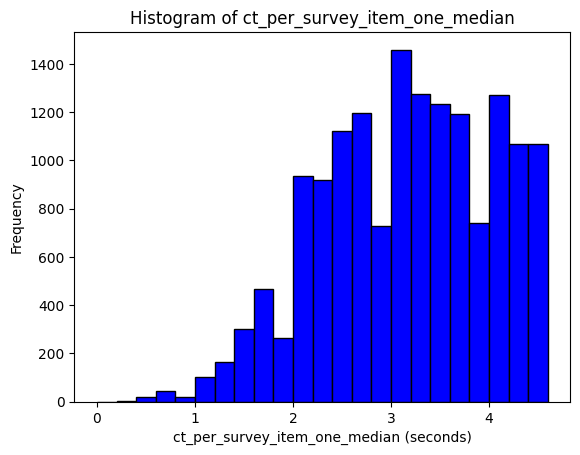

In [320]:
data_to_plot = df_ema['ct_per_survey_item'].dropna()

# Define the range for the histogram
hist_range = (0, 4.6)

# Create histogram with specified range
plt.hist(data_to_plot, bins=23, range=hist_range, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('ct_per_survey_item_one_median (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of ct_per_survey_item_one_median')

# Show plot
plt.show()


In [321]:
df_ema['subject_id_roman_x'].nunique()

629

#### Make completion time per survey item intervals

In [322]:
df_ema['ct_per_survey_item_one_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_one_median'] < 1) | (df_ema['ct_per_survey_item_one_median'] > 4.5), 'ct_per_survey_item_one_median'] = pd.NA


In [323]:
df_ema['ct_per_survey_item_one_point_five_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_one_point_five_median'] < 1.5) | (df_ema['ct_per_survey_item_one_point_five_median'] > 4.5), 'ct_per_survey_item_one_point_five_median'] = pd.NA


In [324]:
df_ema['ct_per_survey_item_two_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_two_median'] < 2) | (df_ema['ct_per_survey_item_two_median'] > 4.5), 'ct_per_survey_item_two_median'] = pd.NA

In [325]:
df_ema['ct_per_survey_item_two_point_five_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_two_point_five_median'] < 2.5) | (df_ema['ct_per_survey_item_two_point_five_median'] > 4.5), 'ct_per_survey_item_two_point_five_median'] = pd.NA


In [326]:
df_ema['ct_per_survey_item_three_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_three_median'] < 3) | (df_ema['ct_per_survey_item_three_median'] > 4.5), 'ct_per_survey_item_three_median'] = pd.NA


In [327]:
df_ema['ct_per_survey_item_three_point_five_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_three_point_five_median'] < 3.5) | (df_ema['ct_per_survey_item_three_point_five_median'] > 4.5), 'ct_per_survey_item_three_point_five_median'] = pd.NA


In [328]:
df_ema['ct_per_survey_item_four_median'] = df_ema['ct_per_survey_item']
df_ema.loc[(df_ema['ct_per_survey_item_four_median'] < 4) | (df_ema['ct_per_survey_item_four_median'] > 4.5), 'ct_per_survey_item_four_median'] = pd.NA


In [329]:
df_ema['ct_per_survey_item_one_median'].describe()

count    15169.000000
mean         3.124570
std          0.833551
min          1.000000
25%          2.500000
50%          3.166667
75%          3.800000
max          4.500000
Name: ct_per_survey_item_one_median, dtype: float64

In [330]:
df_ema['ct_per_survey_item_one_point_five_median'].describe()

count    14853.000000
mean         3.165216
std          0.793616
min          1.500000
25%          2.500000
50%          3.200000
75%          3.812500
max          4.500000
Name: ct_per_survey_item_one_point_five_median, dtype: float64

In [331]:
df_ema['ct_per_survey_item_two_median'].describe()

count    13869.000000
mean         3.269000
std          0.714598
min          2.000000
25%          2.714286
50%          3.250000
75%          3.857143
max          4.500000
Name: ct_per_survey_item_two_median, dtype: float64

In [332]:
df_ema['ct_per_survey_item_two_point_five_median'].describe()

count    11698.000000
mean         3.467833
std          0.590380
min          2.500000
25%          3.000000
50%          3.466667
75%          4.000000
max          4.500000
Name: ct_per_survey_item_two_point_five_median, dtype: float64

In [333]:
df_ema['ct_per_survey_item_three_median'].describe()

count    8968.000000
mean        3.703331
std         0.459458
min         3.000000
25%         3.285714
50%         3.695652
75%         4.095238
max         4.500000
Name: ct_per_survey_item_three_median, dtype: float64

In [334]:
df_ema['ct_per_survey_item_three_point_five_median'].describe()

count    5803.000000
mean        3.979576
std         0.312324
min         3.500000
25%         3.714286
50%         4.000000
75%         4.250000
max         4.500000
Name: ct_per_survey_item_three_point_five_median, dtype: float64

In [335]:
df_ema['ct_per_survey_item_four_median'].describe()

count    3067.000000
mean        4.234420
std         0.170964
min         4.000000
25%         4.076923
50%         4.250000
75%         4.384615
max         4.500000
Name: ct_per_survey_item_four_median, dtype: float64

#### Make longstring feature

In [336]:
df_ema['longstring'] = np.nan

# Check if all specified columns have the same value in each row
same_values_mask = (df_ema['fatigue'] == df_ema['stress']) & \
                   (df_ema['fatigue'] == df_ema['hunger']) & \
                   (df_ema['fatigue'] == df_ema['affect'])

# Assign 1 to 'longstring' where all values are the same, otherwise 0
df_ema.loc[same_values_mask, 'longstring'] = 1
df_ema.loc[~same_values_mask, 'longstring'] = 0

In [337]:
df_ema['longstring'].value_counts()

longstring
0.0    32406
1.0     1614
Name: count, dtype: int64

In [338]:
df_ema.head(5)

subject_id_roman_x         issued_time  response delay  \
0     2023006-00402A 2022-01-16 08:12:27             NaN   
1     2023006-00402A 2022-01-16 11:52:51             NaN   
2     2023006-00402A 2022-01-16 13:35:19        2598.115   
3     2023006-00402A 2022-01-16 16:58:46         736.668   
4     2023006-00402A 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time  \
0                   NaN           0            141.0   
1                   NaN           0              NaN   
2                   NaN           1            118.0   
3                   NaN           1            121.0   
4                   NaN           1             26.0   

  time_of_the_day_categories time_of_the_day_categories_dummy  \
0                          1                                1   
1                          2                                2   
2                          3                                3   
3                          4                                4   
4                          5                                5   

  time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
0                                          1            5.0     1.0     1.0   
1                                          2            5.0     NaN     NaN   
2                                          3            5.0     1.0     3.0   
3                                          4            5.0     1.0     2.0   
4                                        NaN            5.0     1.0     4.0   

   fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
0      2.0     5.0                 1                1.0                7   
1      NaN     NaN                 2                1.0                7   
2      1.0     1.0                 3                1.0                7   
3      1.0     4.0                 4                1.0                7   
4      2.0     5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category  survey_length  \
0                    7.0                   1              3   
1                    7.0                   1             -4   
2                    7.0                   1             11   
3                    7.0                   1             10   
4                    7.0                   1              2   

   first_question_length  location_current_ordinal  location_current_commute  \
0                      1                       NaN                     False   
1                      0                       NaN                     False   
2                      4                       NaN                     False   
3                      2                       NaN                     False   
4                      2                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False        

In [339]:
df_no_longstrings = df_ema[df_ema['longstring'] == 0]

In [340]:
df_no_longstrings['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    2.878900e+04
mean              inf
std               NaN
min      5.000000e-01
25%      3.250000e+00
50%      4.600000e+00
75%      6.894737e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [341]:
df_no_longstrings['survey_length_n'].describe()

count    32406.000000
mean        11.936000
std          8.058299
min          0.000000
25%          5.000000
50%         11.000000
75%         17.000000
max         53.000000
Name: survey_length_n, dtype: float64

In [342]:
df_no_longstrings['first_question_length'].describe()

count    32406.000000
mean         1.771339
std          1.261853
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: first_question_length, dtype: float64

In [343]:
df_no_longstrings['completion_time'].describe()

count    28789.000000
mean        89.541561
std        158.289903
min          2.000000
25%         24.000000
50%         53.000000
75%        103.000000
max       3591.000000
Name: completion_time, dtype: float64

In [344]:
df_no_longstrings.head(1)

subject_id_roman_x         issued_time  response delay  \
0     2023006-00402A 2022-01-16 08:12:27             NaN   

   response_delay_10min  compliance  completion_time  \
0                   NaN           0            141.0   

  time_of_the_day_categories time_of_the_day_categories_dummy  \
0                          1                                1   

  time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
0                                          1            5.0     1.0     1.0   

   fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
0      2.0     5.0                 1                1.0                7   

   day_of_the_week_dummy  incentive_category  survey_length  \
0                    7.0                   1              3   

   first_question_length  location_current_ordinal  location_current_commute  \
0                      1                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   

   time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
0                   False                   False                   False   

   time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
0                     False               False                False   

   day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
0                  False                 False               False   

   day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
0                 False                True                     1.0   34   

   gender  ethnicity  education_level  familiarity_digital_devices  \
0       1          1                6                            2   

   employment_status  night_shifts_binary household_income  \
0                  2                  1.0                4   

   alcohol_consumption  extraversion  agreeableness  conscientiousness  \
0                    2           3.0            2.0                2.5   

   neuroticism  openness  screen_time_average_smartphone_mins  \
0          1.5       2.5                                180.0   

   screen_time_average  smoking_binary  employment_status_binary  nothing  \
0                900.0               1                         1        0   

     next_issued_time    ipi  response_ten_binary  next_prompt_compliance  \
0 2022-01-16 11:52:51  220.4                    0                     0.0   

   survey_length_n  ct_per_survey_item  careless_response  \
0                7                23.5                  0   

   careless_response_one  careless_response_three  careless_response_five  \
0                      0                        0                       0   

   careless_response_sub_two  careless_response_sub_one_point_five  \
0                          0                                     0   

   careless_response_one_point_five  fast_response_one_three  \
0                                 0                      0.0   

   fast_response_one_two  fast_response_one_sub_two  \
0                    0.0                        0.0   

   fast_response_point_five_two  fast_response_point_five_three  \
0                           0.0                             0.0   

   fast_response_point_five_sub_two  fast_response_two_four  \
0                               0.0                     0.0   

   fast_response_one_one_point_five  length_zero_binary  \
0                               0.0                   0   

   length_zero_no_careless_one  length_zero_no_careless_two  \
0                          0.0                          0.0   

   le

In [345]:
df_longstrings = df_ema[df_ema['longstring'] == 1]

In [346]:
df_longstrings.head(225).tail(1)

subject_id_roman_x         issued_time  response delay  \
4782     2023006-00673A 2022-04-18 08:11:52        2231.838   

      response_delay_10min  compliance  completion_time  \
4782                   NaN           1             14.0   

     time_of_the_day_categories time_of_the_day_categories_dummy  \
4782                          1                                1   

     time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
4782                                          1            1.0     1.0   

      hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
4782     1.0      1.0     1.0                31                6.0   

      day_of_the_week  day_of_the_week_dummy  incentive_category  \
4782                1                    NaN                   1   

      survey_length  first_question_length  location_current_ordinal  \
4782              3                      1                       NaN   

      location_current_commute  location_current_green_spaces  \
4782                     False                          False   

      location_current_home  location_current_home_outside  \
4782                  False                          False   

      location_current_indoors_elsewhere  location_current_other  \
4782                               False                   False   

      time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
4782                  True                   False                   False   

      time_of_day_1530_to_17  time_of_day_18_to_1930  \
4782                   False                   False   

      time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
4782                     False                True                False   

      day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
4782                  False                 False               False   

      day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
4782                 False               False                     0.0   17   

      gender  ethnicity  education_level  familiarity_digital_devices  \
4782       1          1                7                            2   

      employment_status  night_shifts_binary household_income  \
4782                  2                  1.0                3   

      alcohol_consumption  extraversion  agreeableness  conscientiousness  \
4782                    1           2.0            3.0                2.5   

      neuroticism  openness  screen_time_average_smartphone_mins  \
4782          2.0       2.5                           308.571429   

      screen_time_average  smoking_binary  employment_status_binary  nothing  \
4782           805.714286               1                         1        0   

        next_issued_time    ipi  response_ten_binary  next_prompt_compliance  \
4782 2022-04-18 12:01:04  229.2                    0                     1.0   

      survey_length_n  ct_per_survey_item  careless_response  \
4782                7            2.333333                  0   

      careless_response_one  careless_response_three  careless_response_five  \
4782                      0                        1                       1   

      careless_response_sub_two  careless_response_sub_one_point_five  \
4782                          0                                     0   

      careless_response_one_point_five  fast_response_one_three  \
4782                                 0                      1.0   

      fast_response_one_two  fast_response_one_sub_two  \
4782                    0.0                        0.0   

      fast_response_point_five_two  fast_response_point_five_three  \
4782                           0.0                             1.0   

      fast_response_point_five_sub_two  fast_response_two_four  \
4782                               0.0                     1.0   

      fast_response_one_one_point_five  length_zero_binary  \
4782         

In [347]:
df_longstrings["stress"].value_counts()

stress
3.0    1037
2.0     234
1.0     185
4.0      54
0.0      53
5.0      47
6.0       4
Name: count, dtype: int64

#### Make Longstring_careless_one feature

In [348]:
df_ema['longstring'] = df_ema['longstring'].astype(int)
df_ema['careless_response_one'] = df_ema['careless_response_one'].astype(int)

In [349]:
df_ema['longstring_careless_one'] = (df_ema['longstring'] | df_ema['careless_response_one']).astype(int)


In [350]:
df_ema['longstring_careless_one'].value_counts()

longstring_careless_one
0    32316
1     1704
Name: count, dtype: int64

#### Longstring values per participant

In [351]:
participant_counts = df_ema[df_ema['longstring'] == 1].groupby('subject_id_roman_x').size()

# Map the participant counts back to the original DataFrame
df_ema['longstrings_per_participant'] = df_ema['subject_id_roman_x'].map(participant_counts)

# Fill NaN values with 0 for participants with no records
df_ema['longstrings_per_participant'].fillna(0, inplace=True)


In [352]:
df_ema['longstrings_per_participant'].describe()

count    34020.000000
mean         2.561905
std          6.480969
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         44.000000
Name: longstrings_per_participant, dtype: float64

#### Make longstrings per participants that have at least 2 or 3 instances of longstrings

In [353]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_two'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0 nor 1
mask = (df_ema['longstring'] == 1) & (df_ema['longstrings_per_participant'].isin([0, 1]) == False)
df_ema.loc[mask, 'longstring_two'] = 1


In [354]:
df_ema['longstring_two'].value_counts()

longstring_two
0    32515
1     1505
Name: count, dtype: int64

In [355]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_three'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0, 1, nor 2
mask = (df_ema['longstring'] == 1) & (~df_ema['longstrings_per_participant'].isin([0, 1, 2]))
df_ema.loc[mask, 'longstring_three'] = 1


In [356]:
df_ema['longstring_three'].value_counts()

longstring_three
0    32611
1     1409
Name: count, dtype: int64

In [357]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_four'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0, 1, nor 2
mask = (df_ema['longstring'] == 1) & (~df_ema['longstrings_per_participant'].isin([0, 1, 2,3]))
df_ema.loc[mask, 'longstring_four'] = 1


In [358]:
df_ema['longstring_four'].value_counts()

longstring_four
0    32674
1     1346
Name: count, dtype: int64

In [359]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_five'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0, 1, nor 2
mask = (df_ema['longstring'] == 1) & (~df_ema['longstrings_per_participant'].isin([0, 1, 2,3, 4]))
df_ema.loc[mask, 'longstring_five'] = 1


In [360]:
df_ema['longstring_five'].value_counts()

longstring_five
0    32746
1     1274
Name: count, dtype: int64

In [361]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_six'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0, 1, nor 2
mask = (df_ema['longstring'] == 1) & (~df_ema['longstrings_per_participant'].isin([0, 1, 2,3, 4, 5]))
df_ema.loc[mask, 'longstring_six'] = 1


In [362]:
df_ema['longstring_six'].value_counts()

longstring_six
0    32766
1     1254
Name: count, dtype: int64

In [363]:
# Creating a new column 'longstring_two' and assigning initial value as 0
df_ema['longstring_seven'] = 0

# Conditionally assign 1 to rows where 'longstring' is 1 and 'Longstrings_per_participant' is neither 0, 1, nor 2
mask = (df_ema['longstring'] == 1) & (~df_ema['longstrings_per_participant'].isin([0, 1, 2,3, 4, 5, 6]))
df_ema.loc[mask, 'longstring_seven'] = 1


In [364]:
df_ema['longstring_seven'].value_counts()

longstring_seven
0    32814
1     1206
Name: count, dtype: int64

#### Make longstring & limit completion time feature

In [365]:
df_ema['longstring_no_three'] = 0

# Update the values based on conditions
df_ema.loc[(df_ema['longstring'] == 1) & (df_ema['stress'] != 3), 'longstring_no_three'] = 1


In [366]:
df_ema['longstring_comp_ti_six_point_eight'] = 0
df_ema.loc[(df_ema['longstring'] == 1) & (df_ema['ct_per_survey_item'] <= 6.8), 'longstring_comp_ti_six_point_eight'] = 1


In [367]:
df_ema['longstring_comp_ti_four_point_five'] = 0
df_ema.loc[(df_ema['longstring'] == 1) & (df_ema['ct_per_survey_item'] <= 4.5), 'longstring_comp_ti_four_point_five'] = 1


In [368]:
df_ema['longstring_comp_ti_three'] = 0
df_ema.loc[(df_ema['longstring'] == 1) & (df_ema['ct_per_survey_item'] <= 3), 'longstring_comp_ti_three'] = 1


In [369]:
df_ema['longstring_comp_ti_two'] = 0
df_ema.loc[(df_ema['longstring'] == 1) & (df_ema['ct_per_survey_item'] <= 2), 'longstring_comp_ti_two'] = 1


In [370]:
df_ema['longstring_comp_ti_six_point_eight'].value_counts()

longstring_comp_ti_six_point_eight
0    32589
1     1431
Name: count, dtype: int64

In [371]:
df_ema['longstring_comp_ti_four_point_five'].value_counts()

longstring_comp_ti_four_point_five
0    32843
1     1177
Name: count, dtype: int64

In [372]:
df_ema['longstring_comp_ti_three'].value_counts()

longstring_comp_ti_three
0    33224
1      796
Name: count, dtype: int64

In [373]:
df_ema['longstring_comp_ti_two'].value_counts()

longstring_comp_ti_two
0    33595
1      425
Name: count, dtype: int64

In [374]:
df_ema['longstring_no_three'].value_counts()

longstring_no_three
0    33443
1      577
Name: count, dtype: int64

In [375]:
df_ema['longstring'].value_counts()

longstring
0    32406
1     1614
Name: count, dtype: int64

In [376]:
df_ema['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.040300e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [377]:
df_new = df_ema.copy()

In [378]:
df_new = df_new[df_new['longstring'] == 1]

#### Combine longstring and non-compliance

In [379]:
df_ema['long_no_comp'] = ((df_ema['longstring'] == 1) | (df_ema['compliance'] == 0)).astype(int)

In [380]:
df_ema['long_no_comp'].value_counts()

long_no_comp
0    28599
1     5421
Name: count, dtype: int64

In [381]:
df_ema['longstring'].value_counts()

longstring
0    32406
1     1614
Name: count, dtype: int64

In [382]:
df_ema['compliance'].value_counts()

compliance
1    30213
0     3807
Name: count, dtype: int64

#### Make next-prompt careless feature

In [383]:
df_ema['next_prompt_long_no_comp'] = df_ema['long_no_comp'].shift(-1)

In [384]:
df_ema['next_prompt_careless'] = df_ema['careless_response'].shift(-1)

In [385]:
df_ema['next_prompt_careless_one'] = df_ema['careless_response_one'].shift(-1)

In [386]:
df_ema['next_prompt_careless_one_point_five'] = df_ema['careless_response_one_point_five'].shift(-1)

In [387]:
df_ema['next_prompt_fast_one_two'] = df_ema['fast_response_one_two'].shift(-1)

In [388]:
df_ema['next_prompt_longstring'] = df_ema['longstring'].shift(-1)

In [389]:
df_ema['next_prompt_longstring_two'] = df_ema['longstring_two'].shift(-1)

In [390]:
df_ema['next_prompt_longstring_three'] = df_ema['longstring_three'].shift(-1)

In [391]:
df_ema['next_prompt_longstring_four'] = df_ema['longstring_four'].shift(-1)

In [392]:
df_ema['next_prompt_longstring_five'] = df_ema['longstring_five'].shift(-1)

In [393]:
df_ema['next_prompt_longstring_six'] = df_ema['longstring_six'].shift(-1)

In [394]:
df_ema['next_prompt_longstring_careless_one'] = df_ema['longstring_careless_one'].shift(-1)

In [395]:
df_ema['next_prompt_longstring_comp_ti_six_point_eight'] = df_ema['longstring_comp_ti_six_point_eight'].shift(-1)

In [396]:
df_ema['next_prompt_longstring_comp_ti_four_point_five'] = df_ema['longstring_comp_ti_four_point_five'].shift(-1)

In [397]:
df_ema['next_prompt_longstring_comp_ti_three'] = df_ema['longstring_comp_ti_three'].shift(-1)

In [398]:
df_ema['next_prompt_longstring_comp_ti_two'] = df_ema['longstring_comp_ti_two'].shift(-1)

In [399]:
df_ema['next_prompt_longstring_no_three'] = df_ema['longstring_no_three'].shift(-1)

In [400]:
df_ema['next_prompt_ct_per_survey_item'] = df_ema['ct_per_survey_item'].shift(-1)

In [401]:
df_ema['next_prompt_completion_time'] = df_ema['completion_time'].shift(-1)

In [402]:
df_ema['next_prompt_ct_per_survey_item'].isna().sum()

3618

In [403]:
df_ema['ct_per_survey_item'].isna().sum()

3617

In [404]:
df_ema['next_prompt_compliance'].isna().sum()

1

In [405]:
df_ema['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    30213
0.0     3806
Name: count, dtype: int64

In [406]:
df_ema['compliance'].value_counts()

compliance
1    30213
0     3807
Name: count, dtype: int64

In [407]:
df_ema.head(102).tail(0)

Empty DataFrame
Columns: [subject_id_roman_x, issued_time, response delay, response_delay_10min, compliance, completion_time, time_of_the_day_categories, time_of_the_day_categories_dummy, time_of_the_day_categories_dummy_no_last_p, sleep_quality, stress, hunger, fatigue, affect, number_of_survey, day_of_monitoring, day_of_the_week, day_of_the_week_dummy, incentive_category, survey_length, first_question_length, location_current_ordinal, location_current_commute, location_current_green_spaces, location_current_home, location_current_home_outside, location_current_indoors_elsewhere, location_current_other, time_of_day_8_to_930, time_of_day_1030_to_12, time_of_day_13_to_1430, time_of_day_1530_to_17, time_of_day_18_to_1930, time_of_day_2030_to_2130, day_of_week_monday, day_of_week_tuesday, day_of_week_wednesday, day_of_week_thursday, day_of_week_friday, day_of_week_saturday, day_of_week_sunday, day_of_the_week_binary, age, gender, ethnicity, education_level, familiarity_digital_devices, employment_status, night_shifts_binary, household_income, alcohol_consumption, extraversion, agreeableness, conscientiousness, neuroticism, openness, screen_time_average_smartphone_mins, screen_time_average, smoking_binary, employment_status_binary, nothing, next_issued_time, ipi, response_ten_binary, next_prompt_compliance, survey_length_n, ct_per_survey_item, careless_response, careless_response_one, careless_response_three, careless_response_five, careless_response_sub_two, careless_response_sub_one_point_five, careless_response_one_point_five, fast_response_one_three, fast_response_one_two, fast_response_one_sub_two, fast_response_point_five_two, fast_response_point_five_three, fast_response_point_five_sub_two, fast_response_two_four, fast_response_one_one_point_five, length_zero_binary, length_zero_no_careless_one, length_zero_no_careless_two, length_zero_no_careless_one_point_five, nothing_no_careless_one, nothing_no_careless_one_point_five, nothing_no_careless_two, nothing_no_careless_one_nulllength, nothing_no_careless_one_point_five_nulllength, nothing_no_careless_two_nulllength, ct_per_survey_item_one_median, ct_per_survey_item_one_point_five_median, ct_per_survey_item_two_median, ct_per_survey_item_two_point_five_median, ct_per_survey_item_three_median, ct_per_survey_item_three_point_five_median, ct_per_survey_item_four_median, longstring, ...]
Index: []

In [408]:
df_t = df_ema[df_ema['completion_time'].isna()]

In [409]:
len(df_ema)

34020

In [410]:
df_t.head()

subject_id_roman_x         issued_time  response delay  \
1       2023006-00402A 2022-01-16 11:52:51             NaN   
76      2023006-00146A 2022-01-19 19:11:01             NaN   
85      2023006-00146A 2022-01-21 10:41:29             NaN   
145     2023006-00508A 2022-01-25 10:53:53             NaN   
154     2023006-00508A 2022-01-26 19:28:21             NaN   

     response_delay_10min  compliance  completion_time  \
1                     NaN           0              NaN   
76                    NaN           0              NaN   
85                    NaN           0              NaN   
145                   NaN           0              NaN   
154                   NaN           0              NaN   

    time_of_the_day_categories time_of_the_day_categories_dummy  \
1                            2                                2   
76                           5                                5   
85                           2                                2   
145                          2                                2   
154                          5                                5   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
1                                            2            5.0     NaN     NaN   
76                                         NaN            5.0     NaN     NaN   
85                                           2            1.0     NaN     NaN   
145                                          2            5.0     NaN     NaN   
154                                        NaN            5.0     NaN     NaN   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
1        NaN     NaN                 2                1.0                7   
76       NaN     NaN                23                4.0                3   
85       NaN     NaN                32                6.0                5   
145      NaN     NaN                38                7.0                2   
154      NaN     NaN                47                8.0                3   

     day_of_the_week_dummy  incentive_category  survey_length  \
1                      7.0                   1             -4   
76                     3.0                   1             -4   
85                     5.0                   1             -4   
145                    2.0                   1             -4   
154                    3.0                   1             -4   

     first_question_length  location_current_ordinal  \
1                        0                       NaN   
76                       0                       NaN   
85                       0                       NaN   
145                      0                       NaN   
154                      0                       NaN   

     location_current_commute  location_current_green_spaces  \
1                       False                          False   
76                      False                          False   
85                      False                          False   
145                     False                          False   
154                     False                          False   

     location_current_home  location_current_home_outside  \
1                    False                          False   
76                   False                          False   
85                   False                          False   
145                  False                          False   
154                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
1                                 False                   False   
76                                False                   False   
85                                False                   False   
145                               False                   False   
154                               False                   False   

     time_of_day_8_to_930  time_of_day_1

#### Make next-prompt careless or non-compliant feature

In [411]:
df_ema['next_prompt_invalid'] = np.where((df_ema['next_prompt_careless'] == 1) | (df_ema['next_prompt_compliance'] == 0), 1, 0)

In [412]:
df_ema['next_prompt_invalid'].value_counts()

next_prompt_invalid
0    28228
1     5792
Name: count, dtype: int64

In [413]:
df_ema.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00402A 2022-01-16 08:12:27             NaN   
1     2023006-00402A 2022-01-16 11:52:51             NaN   
2     2023006-00402A 2022-01-16 13:35:19        2598.115   
3     2023006-00402A 2022-01-16 16:58:46         736.668   
4     2023006-00402A 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time  \
0                   NaN           0            141.0   
1                   NaN           0              NaN   
2                   NaN           1            118.0   
3                   NaN           1            121.0   
4                   NaN           1             26.0   

  time_of_the_day_categories time_of_the_day_categories_dummy  \
0                          1                                1   
1                          2                                2   
2                          3                                3   
3                          4                                4   
4                          5                                5   

  time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
0                                          1            5.0     1.0     1.0   
1                                          2            5.0     NaN     NaN   
2                                          3            5.0     1.0     3.0   
3                                          4            5.0     1.0     2.0   
4                                        NaN            5.0     1.0     4.0   

   fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
0      2.0     5.0                 1                1.0                7   
1      NaN     NaN                 2                1.0                7   
2      1.0     1.0                 3                1.0                7   
3      1.0     4.0                 4                1.0                7   
4      2.0     5.0                 5                1.0                7   

   day_of_the_week_dummy  incentive_category  survey_length  \
0                    7.0                   1              3   
1                    7.0                   1             -4   
2                    7.0                   1             11   
3                    7.0                   1             10   
4                    7.0                   1              2   

   first_question_length  location_current_ordinal  location_current_commute  \
0                      1                       NaN                     False   
1                      0                       NaN                     False   
2                      4                       NaN                     False   
3                      2                       NaN                     False   
4                      2                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False        

In [414]:
df = df_ema.copy()

In [415]:
df['original_time_of_the_day'] = df['time_of_the_day_categories']

In [416]:
df.set_index('time_of_the_day_categories', inplace=True)

In [417]:
df.index.name = None

In [418]:
df['time_of_the_day_categories'] = df['original_time_of_the_day'].copy()

In [419]:
df.head(7)


subject_id_roman_x         issued_time  response delay  \
1     2023006-00402A 2022-01-16 08:12:27             NaN   
2     2023006-00402A 2022-01-16 11:52:51             NaN   
3     2023006-00402A 2022-01-16 13:35:19        2598.115   
4     2023006-00402A 2022-01-16 16:58:46         736.668   
5     2023006-00402A 2022-01-16 18:48:18         645.281   
6     2023006-00402A 2022-01-16 20:30:55         560.831   
1     2023006-00402A 2022-01-17 08:29:58        1486.922   

   response_delay_10min  compliance  completion_time  \
1                   NaN           0            141.0   
2                   NaN           0              NaN   
3                   NaN           1            118.0   
4                   NaN           1            121.0   
5                   NaN           1             26.0   
6               560.831           1            199.0   
1                   NaN           1            175.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
1                                1                                          1   
2                                2                                          2   
3                                3                                          3   
4                                4                                          4   
5                                5                                        NaN   
6                              NaN                                        NaN   
1                                1                                          1   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
1            5.0     1.0     1.0      2.0     5.0                 1   
2            5.0     NaN     NaN      NaN     NaN                 2   
3            5.0     1.0     3.0      1.0     1.0                 3   
4            5.0     1.0     2.0      1.0     4.0                 4   
5            5.0     1.0     4.0      2.0     5.0                 5   
6            5.0     1.0     0.0      1.0     5.0                 6   
1            4.0     1.0     4.0      1.0     5.0                 7   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   
5                1.0                7                    7.0   
6                1.0                7                    7.0   
1                2.0                1                    NaN   

   incentive_category  survey_length  first_question_length  \
1                   1              3                      1   
2                   1             -4                      0   
3                   1             11                      4   
4                   1             10                      2   
5                   1              2                      2   
6                   1             11                      1   
1                   1             14                      1   

   location_current_ordinal  location_current_commute  \
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   
5                       NaN                     False   
6                       NaN                     False   
1                       NaN                     False   

   location_current_green_spaces  location_current_home  \
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   
5                          False                  False   
6                        

In [420]:
valid_surveys['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.040300e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [421]:
df['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.040300e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [422]:
df.head()

subject_id_roman_x         issued_time  response delay  \
1     2023006-00402A 2022-01-16 08:12:27             NaN   
2     2023006-00402A 2022-01-16 11:52:51             NaN   
3     2023006-00402A 2022-01-16 13:35:19        2598.115   
4     2023006-00402A 2022-01-16 16:58:46         736.668   
5     2023006-00402A 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time  \
1                   NaN           0            141.0   
2                   NaN           0              NaN   
3                   NaN           1            118.0   
4                   NaN           1            121.0   
5                   NaN           1             26.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
1                                1                                          1   
2                                2                                          2   
3                                3                                          3   
4                                4                                          4   
5                                5                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
1            5.0     1.0     1.0      2.0     5.0                 1   
2            5.0     NaN     NaN      NaN     NaN                 2   
3            5.0     1.0     3.0      1.0     1.0                 3   
4            5.0     1.0     2.0      1.0     4.0                 4   
5            5.0     1.0     4.0      2.0     5.0                 5   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   
5                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
1                   1              3                      1   
2                   1             -4                      0   
3                   1             11                      4   
4                   1             10                      2   
5                   1              2                      2   

   location_current_ordinal  location_current_commute  \
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   
5                       NaN                     False   

   location_current_green_spaces  location_current_home  \
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   
5                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   
5                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
1                   False                  True                   False   
2                   False                 False                    True   
3                   False                 False                   False   
4                   False                 False                   False   
5                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_

In [423]:
df['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.040300e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

#### New Autocorrelation Feature

In [424]:
# Function to perform the specified steps
def process_data(df):
    prev_time_of_the_day_category = -1
    obscomp_steps_counter = 0  # Counter for obscomp_steps

    def calculate_obscomp_steps(row):
        # use outer variables instead of creating new ones
        nonlocal prev_time_of_the_day_category, obscomp_steps_counter

        time_of_the_day_categories = row['time_of_the_day_categories']
        compliance = row['compliance']

        # reset counter if next day
        if time_of_the_day_categories <= prev_time_of_the_day_category:
            obscomp_steps_counter = 0

        prev_time_of_the_day_category = time_of_the_day_categories
        if compliance == 1:
            obscomp_steps = obscomp_steps_counter
            obscomp_steps_counter = 0
            return obscomp_steps
        if compliance == 0:
            # set to nan if compliance is zero, use other default if desired
            obscomp_steps_counter += 1
            return np.nan
        raise ValueError(f"Unknown compliance value: {compliance}")

    df['obscomp_steps'] = df.apply(calculate_obscomp_steps, axis=1)
process_data(df)


In [425]:
# Function to perform the specified steps
def process_data(df):
    prev_time_of_the_day_category = -1
    obscomp_steps_counter = 0  # Counter for obscomp_steps

    def calculate_obscomp_steps(row):
        # use outer variables instead of creating new ones
        nonlocal prev_time_of_the_day_category, obscomp_steps_counter

        time_of_the_day_categories = row['time_of_the_day_categories']
        compliance = row['response_ten_binary']

        # reset counter if next day
        if time_of_the_day_categories <= prev_time_of_the_day_category:
            obscomp_steps_counter = 0

        prev_time_of_the_day_category = time_of_the_day_categories
        if compliance == 1:
            obscomp_steps = obscomp_steps_counter
            obscomp_steps_counter = 0
            return obscomp_steps
        if compliance == 0:
            # set to nan if compliance is zero, use other default if desired
            obscomp_steps_counter += 1
            return np.nan
        raise ValueError(f"Unknown compliance value: {compliance}")

    df['obscomp_steps_ten'] = df.apply(calculate_obscomp_steps, axis=1)
process_data(df)


In [426]:
df['obscomp_steps'].value_counts()

obscomp_steps
0.0    27956
1.0     1876
2.0      290
3.0       74
4.0       10
5.0        7
Name: count, dtype: int64

In [427]:
len(df)

34020

In [428]:
df['obscomp_steps_ten'].value_counts()

obscomp_steps_ten
0.0    7622
1.0    2516
2.0    1030
3.0     531
4.0     259
5.0     191
Name: count, dtype: int64

The Autocorrelation calculation of the code below is correct (without iterating over participants). Iterating over participants is not necessary as every last survey per day anyway receives the value NA, so every day over all participants can be regarded as being calculated independently

Debugging obscomp steps below -> Delete again afterwards

In [429]:
df['obscomp_steps'].value_counts()

obscomp_steps
0.0    27956
1.0     1876
2.0      290
3.0       74
4.0       10
5.0        7
Name: count, dtype: int64

In [430]:
df['obscomp_steps_ten'].value_counts()

obscomp_steps_ten
0.0    7622
1.0    2516
2.0    1030
3.0     531
4.0     259
5.0     191
Name: count, dtype: int64

In the Autocorrelation logic, the value for Obcomp_steps of the first survey of the day always has to be 0 because there cannot be any missed surveys before this. Therefore, the next row sets all Obcomp_step values of the first survey of the day to 0. 


In [431]:
df.loc[df['time_of_the_day_categories'] == 1, 'obscomp_steps'] = 0

(Caveat: I think i would need to also calculate the obscomp-steps feature for cases where the count is 6, because I have this also in the logic for the case of response delay and completion time!)

Do not change anything above this cell as this will also affect the response_delay and completion time dataset!!

##### Impute sleep quality median for all sleep quality nas if the participant has at least 3 valid entries

In [432]:
df['sleep_quality'].isna().sum()

4644

In [433]:
len(df)

34020

In [434]:
df.head(6)

subject_id_roman_x         issued_time  response delay  \
1     2023006-00402A 2022-01-16 08:12:27             NaN   
2     2023006-00402A 2022-01-16 11:52:51             NaN   
3     2023006-00402A 2022-01-16 13:35:19        2598.115   
4     2023006-00402A 2022-01-16 16:58:46         736.668   
5     2023006-00402A 2022-01-16 18:48:18         645.281   
6     2023006-00402A 2022-01-16 20:30:55         560.831   

   response_delay_10min  compliance  completion_time  \
1                   NaN           0            141.0   
2                   NaN           0              NaN   
3                   NaN           1            118.0   
4                   NaN           1            121.0   
5                   NaN           1             26.0   
6               560.831           1            199.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
1                                1                                          1   
2                                2                                          2   
3                                3                                          3   
4                                4                                          4   
5                                5                                        NaN   
6                              NaN                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
1            5.0     1.0     1.0      2.0     5.0                 1   
2            5.0     NaN     NaN      NaN     NaN                 2   
3            5.0     1.0     3.0      1.0     1.0                 3   
4            5.0     1.0     2.0      1.0     4.0                 4   
5            5.0     1.0     4.0      2.0     5.0                 5   
6            5.0     1.0     0.0      1.0     5.0                 6   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   
5                1.0                7                    7.0   
6                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
1                   1              3                      1   
2                   1             -4                      0   
3                   1             11                      4   
4                   1             10                      2   
5                   1              2                      2   
6                   1             11                      1   

   location_current_ordinal  location_current_commute  \
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   
5                       NaN                     False   
6                       NaN                     False   

   location_current_green_spaces  location_current_home  \
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   
5                          False                  False   
6                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   
5                          False                         

In [435]:
df['sleep_quality'].describe()

count    29376.000000
mean         3.791871
std          1.312273
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: sleep_quality, dtype: float64

#### Median Imputation

In [436]:
# Identify unique participants with at least two rows where time_of_the_day_categories is 1 and sleep_quality is not NA
valid_participants = df[(df['time_of_the_day_categories'] == 1) & ~df['sleep_quality'].isna()]\
    ['subject_id_roman_x'].value_counts()[lambda x: x >= 3].index

# Filter the DataFrame to include only rows from valid participants
df_filtered = df[df['subject_id_roman_x'].isin(valid_participants)]



In [437]:
df_filtered_removed_parts_sleep = df[~df['subject_id_roman_x'].isin(valid_participants)]

In [438]:
df_filtered_removed_parts_sleep['subject_id_roman_x'].nunique()

7

In [439]:
unique_participant_ids = df_filtered_removed_parts_sleep['subject_id_roman_x'].unique()

# Print the unique participant IDs
print("Unique Participant IDs in df_filtered_parts_sleep:")
print(unique_participant_ids)

# Print the count of unique participant IDs
print("Number of Unique Participant IDs:", len(unique_participant_ids))

Unique Participant IDs in df_filtered_parts_sleep:
['2023006-00613A' '2023006-00529A' '2023006-00373A' '2023006-00578A'
 '2023006-00177A' '2023006-00363A' '2023006-00184A']
Number of Unique Participant IDs: 7


In [440]:
unique_participant_ids = pd.DataFrame(unique_participant_ids)
unique_participant_ids.to_csv(f'../outputs/participants_sub_3_first_prompt_responses.csv', index=False)

In [441]:
len(df_filtered)

33642

In [442]:
df_filtered['subject_id_roman_x'].nunique()

622

In [443]:
df_filtered['sleep_quality'].isna().sum()

4302

7 participants have less than 3 unique sleep quality values (in the first survey of the day) and were thus excluded from the imputation process and from the dataset (582-7 = 575 participants)

In [444]:
df = df_filtered.copy()

###### This participant has duplicate rows, therefore one set of duplicates is removed here

In [445]:
# Get the count of rows for each unique participant ID
id_counts = df['subject_id_roman_x'].value_counts()

# Check if any participant ID has a count different from 54
for participant_id, count in id_counts.items():
    if count != 54:
        print(f"Participant ID {participant_id} has {count} rows instead of 54.")


Participant ID 2023006-00015A has 108 rows instead of 54.


In [446]:
# df_duplicate = df[df['subject_id_roman_x'] == '2023006-00015A']

In [447]:
# Identify the participant ID with duplicate rows
duplicate_id = '2023006-00015A'

# Create a boolean mask to identify rows to keep
mask = (df['subject_id_roman_x'] != duplicate_id) | (df.groupby('subject_id_roman_x').cumcount() % 2 == 0)

# Apply the mask to the dataframe to exclude every second row for the duplicate participant
df = df[mask]


In [448]:
df['subject_id_roman_x'].nunique()

622

In [449]:
len(df)

33588

In [450]:

# Adapted code to count unique participants
df_cleaned = df.dropna(subset=['sleep_quality'])

# Filter rows where time_of_the_day_categories is 1
df_filtered = df_cleaned[df_cleaned['time_of_the_day_categories'] == 1]

# Group by participant ID and count occurrences
participant_counts = df_filtered.groupby('subject_id_roman_x').size()

# Filter participants with at least two rows
participants_with_two_rows = participant_counts[participant_counts >= 3]

# Display the result
print("Number of unique participants with at least three rows where time_of_the_day_categories is 1 and sleep_quality is not NA:",
      len(participants_with_two_rows))

Number of unique participants with at least three rows where time_of_the_day_categories is 1 and sleep_quality is not NA: 622


In [451]:
df['sleep_quality_median'] = df.groupby('subject_id_roman_x')['sleep_quality'].transform('median')

In [452]:
df['sleep_quality_median'].describe()

count    33588.000000
mean         3.838424
std          1.081512
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: sleep_quality_median, dtype: float64

In [453]:
df.reset_index(drop=True, inplace=True)


In [454]:
df['sleep_quality'] = df['sleep_quality'].fillna(df['sleep_quality_median'])


In [455]:
df.head(100000).tail(2)

subject_id_roman_x         issued_time  response delay  \
33586     2023006-00324A 2023-07-09 19:21:39           9.985   
33587     2023006-00324A 2023-07-09 21:03:28         614.541   

       response_delay_10min  compliance  completion_time  \
33586                 9.985           1             16.0   
33587                   NaN           1             37.0   

      time_of_the_day_categories_dummy  \
33586                                5   
33587                              NaN   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
33586                                        NaN            4.0     4.0   
33587                                        NaN            4.0     4.0   

       hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
33586     3.0      3.0     3.0                53                9.0   
33587     3.0      3.0     3.0                54                9.0   

       day_of_the_week  day_of_the_week_dummy  incentive_category  \
33586                7                    7.0                   0   
33587                7                    7.0                   0   

       survey_length  first_question_length  location_current_ordinal  \
33586              6                      2                       NaN   
33587             10                      3                       NaN   

       location_current_commute  location_current_green_spaces  \
33586                     False                          False   
33587                     False                          False   

       location_current_home  location_current_home_outside  \
33586                  False                          False   
33587                  False                          False   

       location_current_indoors_elsewhere  location_current_other  \
33586                               False                   False   
33587                               False                   False   

       time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
33586                 False                   False                   False   
33587                 False                   False                   False   

       time_of_day_1530_to_17  time_of_day_18_to_1930  \
33586                   False                    True   
33587                   False                   False   

       time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
33586                     False               False                False   
33587                      True               False                False   

       day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
33586                  False                 False               False   
33587                  False                 False               False   

       day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
33586                 False                True                     1.0    4   
33587                 False                True                     1.0    4   

       gender  ethnicity  education_level  familiarity_digital_devices  \
33586       1          7                5                            1   
33587       1          7                5                            1   

       employment_status  night_shifts_binary household_income  \
33586                  3                  1.0                5   
33587                  3                  1.0                5   

       alcohol_consumption  extraversion  agreeableness  conscientiousness  \
33586                    2           3.0            3.0                2.5   
33587                    2           3.0            3.0                2.5   

       neuroticism  openness  screen_time_average_smartphone_mins  \
33586          2.5       2.5                           514.285714   
33587          2.5       2.5                           514.285714   

       screen_time_average  smoking_binary  employment_status_binary  no

In [456]:
df = df.reset_index(drop=True)

In [457]:
df['sleep_quality'].describe()

count    33588.000000
mean         3.786620
std          1.300655
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          6.000000
Name: sleep_quality, dtype: float64

In [458]:
df['sleep_quality'].isna().sum()

0

In [459]:
df_test = df[df['sleep_quality'].isna()]

In [460]:
df['subject_id_roman_x'].nunique()

622

In [461]:
len(df)

33588

#### Frequencies for analysis

In [462]:
df['next_prompt_compliance'].describe()

count    33587.000000
mean         0.894007
std          0.307834
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: next_prompt_compliance, dtype: float64

In [463]:
df['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    30027
0.0     3560
Name: count, dtype: int64

In [464]:
df['compliance'].value_counts()

compliance
1    30033
0     3555
Name: count, dtype: int64

In [465]:
df['longstring'].value_counts()

longstring
0    31974
1     1614
Name: count, dtype: int64

In [466]:
df['response delay'].describe()

count    30033.000000
mean       782.462802
std        712.853577
min          1.707000
25%        230.342000
50%        615.778000
75%       1171.518000
max       3586.666000
Name: response delay, dtype: float64

In [467]:
df['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3.022200e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.166667e+00
50%      4.500000e+00
75%      6.800000e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [468]:
df.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00402A 2022-01-16 08:12:27             NaN   
1     2023006-00402A 2022-01-16 11:52:51             NaN   
2     2023006-00402A 2022-01-16 13:35:19        2598.115   
3     2023006-00402A 2022-01-16 16:58:46         736.668   
4     2023006-00402A 2022-01-16 18:48:18         645.281   

   response_delay_10min  compliance  completion_time  \
0                   NaN           0            141.0   
1                   NaN           0              NaN   
2                   NaN           1            118.0   
3                   NaN           1            121.0   
4                   NaN           1             26.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            5.0     1.0     1.0      2.0     5.0                 1   
1            5.0     NaN     NaN      NaN     NaN                 2   
2            5.0     1.0     3.0      1.0     1.0                 3   
3            5.0     1.0     2.0      1.0     4.0                 4   
4            5.0     1.0     4.0      2.0     5.0                 5   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1              3                      1   
1                   1             -4                      0   
2                   1             11                      4   
3                   1             10                      2   
4                   1              2                      2   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False                 False                   False   
4                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_

##### Remove any participants that still have missing values in any of the predictors

In [469]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Filter the DataFrame to include only rows where compliance is not equal to 0
df_filtered = df[df['compliance'] != 0]

# Identify subject_id_roman_x values with missing values in specified columns
subjects_with_missing_values = df_filtered[df_filtered[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Creating a new DataFrame without rows containing missing values in specified columns and for the identified subjects
df_predict = df_filtered[~df_filtered['subject_id_roman_x'].isin(subjects_with_missing_values)]

# Check for NaN values in the specified columns
nan_values = df_predict[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to include only rows with NaN values in at least one column
filtered_df = df_predict[nan_values]

# Count the number of unique participant IDs in the filtered DataFrame
unique_participant_count = filtered_df['subject_id_roman_x'].nunique()
print(f"Number of unique participant IDs with NaN values in at least one column: {unique_participant_count}")

# Get all unique participant IDs from filtered_df
unique_participant_ids = filtered_df['subject_id_roman_x'].unique()

# Print the unique participant IDs
print("Unique Participant IDs in df_missing_predictors:")
print(unique_participant_ids)

# Print the count of unique participant IDs
print("Number of Unique Participant IDs:", len(unique_participant_ids))

unique_participant_ids = pd.DataFrame(unique_participant_ids)
unique_participant_ids.to_csv(f'../outputs/participant_missing_predictors.csv', index=False)


Number of unique participant IDs with NaN values in at least one column: 0
Unique Participant IDs in df_missing_predictors:
[]
Number of Unique Participant IDs: 0


In [470]:

# Get the participant IDs with NaN values in at least one column
participants_with_nan = df_predict[df_predict[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Drop rows corresponding to the participant IDs with NaN values
df_no_nan_values = df_predict[~df_predict['subject_id_roman_x'].isin(participants_with_nan)]
df_with_nan_values = df_predict[df_predict['subject_id_roman_x'].isin(participants_with_nan)]

# Print the shape of the original and filtered DataFrames for comparison
print("Original DataFrame shape:", df.shape)
print("DataFrame after dropping rows with NaN values shape:", df_no_nan_values.shape)

print("Number of unique participants in df_no_nan_values:", df_no_nan_values['subject_id_roman_x'].nunique())


Original DataFrame shape: (33588, 138)
DataFrame after dropping rows with NaN values shape: (29797, 138)
Number of unique participants in df_no_nan_values: 617


In [471]:
subjects_with_missing_values

array(['2023006-00402A', '2023006-00079A', '2023006-00258A',
       '2023006-00517A', '2023006-00031A'], dtype=object)

In [472]:
len(df_filtered)

30033

In [473]:
len(df)

33588

In [474]:
df = df[~df['subject_id_roman_x'].isin(subjects_with_missing_values)]

In [475]:
len(df)

33318

In [476]:
participants_with_nan

array([], dtype=object)

In [477]:
df_no_nan_values.head()

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   
56     2023006-00146A 2022-01-16 13:40:18         613.323   
57     2023006-00146A 2022-01-16 15:35:15         613.173   
58     2023006-00146A 2022-01-16 19:12:40         934.251   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   
56                   NaN           1             37.0   
57                   NaN           1             18.0   
58                   NaN           1             20.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   
56                                3   
57                                4   
58                                5   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   
56                                          3            4.0     4.0     2.0   
57                                          4            4.0     2.0     5.0   
58                                        NaN            4.0     4.0     3.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   
56      3.0     3.0                 3                1.0                7   
57      3.0     3.0                 4                1.0                7   
58      5.0     3.0                 5                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   
56                    7.0                   1              9   
57                    7.0                   1              2   
58                    7.0                   1              3   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   
56                      4                       NaN                     False   
57                      2                       NaN                     False   
58                      3                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   
56                          False                  False   
57                          False                  False   
58                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   
56                          False                               False   
57                          False                               False   
58                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   
56                   False                 False                   False   
57                   False                 False                   False   
58                   False                 False              

In [478]:
df['ct_per_survey_item'].describe()

/home/rkvm1/miniconda3/envs/feasibility/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    2.998400e+04
mean              inf
std               NaN
min      3.333333e-01
25%      3.153846e+00
50%      4.500000e+00
75%      6.778986e+00
max               inf
Name: ct_per_survey_item, dtype: float64

In [479]:
df['subject_id_roman_x'].nunique()

617

In [480]:
inf_rows = df[df['ct_per_survey_item'] == float('inf')]

In [481]:
inf_rows.head()

subject_id_roman_x         issued_time  response delay  \
867      2023006-00642A 2022-02-20 16:18:15             NaN   
1010     2023006-00633A 2022-02-26 14:17:19             NaN   
3996     2023006-00249A 2022-03-27 08:44:35             NaN   
5836     2023006-00291A 2022-05-08 18:31:54             NaN   
7860     2023006-00293A 2022-06-06 09:12:54             NaN   

      response_delay_10min  compliance  completion_time  \
867                    NaN           0             14.0   
1010                   NaN           0            599.0   
3996                   NaN           0            597.0   
5836                   NaN           0            825.0   
7860                   NaN           0           2418.0   

     time_of_the_day_categories_dummy  \
867                                 4   
1010                                3   
3996                                1   
5836                                5   
7860                                1   

     time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
867                                           4            4.0     NaN   
1010                                          3            4.0     NaN   
3996                                          1            4.0     NaN   
5836                                        NaN            5.0     NaN   
7860                                          1            4.0     NaN   

      hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
867      NaN      NaN     NaN                 4                1.0   
1010     NaN      NaN     NaN                39                7.0   
3996     NaN      NaN     NaN                 1                1.0   
5836     NaN      NaN     NaN                 5                1.0   
7860     NaN      NaN     NaN                31                6.0   

      day_of_the_week  day_of_the_week_dummy  incentive_category  \
867                 7                    7.0                   1   
1010                6                    6.0                   1   
3996                7                    7.0                   1   
5836                7                    7.0                   1   
7860                1                    NaN                   1   

      survey_length  first_question_length  location_current_ordinal  \
867              -3                      1                       NaN   
1010             -3                      1                       NaN   
3996             -3                      0                       NaN   
5836             -3                      1                       NaN   
7860             -3                      0                       NaN   

      location_current_commute  location_current_green_spaces  \
867                      False                          False   
1010                     False                          False   
3996                     False                          False   
5836                     False                          False   
7860                     False                          False   

      location_current_home  location_current_home_outside  \
867                   False                          False   
1010                  False                          False   
3996                  False                          False   
5836                  False                          False   
7860                  False                          False   

      location_current_indoors_elsewhere  location_current_other  \
867                                False                   False   
1010                               False                   False   
3996                               False                   False   
5836                               False                   False   
7860                               False                   False   

      time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
867                  False                   False               

In [482]:
df.to_csv(f'../outputs/Full_df_final_descriptives.csv', index=False)

##### Remove all non-compliant columns

In [483]:
len(df)

33318

In [484]:
df['compliance'].value_counts()

compliance
1    29797
0     3521
Name: count, dtype: int64

In [485]:
df = df[df['compliance'] != 0]

In [486]:
df['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

In [487]:
len(df)

29797

In [488]:
df['subject_id_roman_x'].nunique()

617

In [489]:
df['obscomp_steps'].value_counts()

obscomp_steps
0.0    27611
1.0     1835
2.0      275
3.0       65
4.0        8
5.0        3
Name: count, dtype: int64

In [490]:
df['obscomp_steps'].describe()

count    29797.000000
mean         0.088163
std          0.342311
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: obscomp_steps, dtype: float64

In [491]:
df['next_prompt_compliance'].isna().sum()

1

In [492]:
df_p = df[df['next_prompt_completion_time'].isna()]

In [493]:
df_p.head()

subject_id_roman_x         issued_time  response delay  \
75      2023006-00146A 2022-01-19 15:50:28         605.554   
84      2023006-00146A 2022-01-21 09:17:15         616.245   
144     2023006-00508A 2022-01-25 09:05:52          79.356   
153     2023006-00508A 2022-01-26 16:49:48          52.859   
161     2023006-00508A 2022-01-27 21:18:46         190.250   

     response_delay_10min  compliance  completion_time  \
75                    NaN           1             76.0   
84                    NaN           1             78.0   
144                79.356           1            179.0   
153                52.859           1             35.0   
161               190.250           1             49.0   

    time_of_the_day_categories_dummy  \
75                                 4   
84                                 1   
144                                1   
153                                4   
161                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
75                                           4            5.0     1.0     4.0   
84                                           1            1.0     2.0     0.0   
144                                          1            5.0     2.0     2.0   
153                                          4            5.0     3.0     3.0   
161                                        NaN            5.0     1.0     1.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
75       5.0     3.0                22                4.0                3   
84       4.0     3.0                31                6.0                5   
144      1.0     4.0                37                7.0                2   
153      3.0     3.0                46                8.0                3   
161      2.0     5.0                54                9.0                4   

     day_of_the_week_dummy  incentive_category  survey_length  \
75                     3.0                   1             20   
84                     5.0                   1             25   
144                    2.0                   1             26   
153                    3.0                   1              8   
161                    4.0                   1              7   

     first_question_length  location_current_ordinal  \
75                       3                       NaN   
84                       2                       NaN   
144                      5                       2.0   
153                      3                       NaN   
161                      3                       4.0   

     location_current_commute  location_current_green_spaces  \
75                      False                          False   
84                      False                          False   
144                     False                          False   
153                     False                          False   
161                     False                          False   

     location_current_home  location_current_home_outside  \
75                   False                          False   
84                   False                          False   
144                  False                          False   
153                  False                          False   
161                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
75                                False                   False   
84                                False                   False   
144                               False                   False   
153                               False                   False   
161                                True                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
75                  False                   False                   False   
84                   True                   Fals

In [494]:
len(df)

29797

In [495]:
df.to_csv(f'../outputs/Full_df_final_descriptives_no_non-compliant.csv', index=False)

#### Make careless_response column

In [496]:
df['careless_response'].value_counts()

careless_response
0    27821
1     1976
Name: count, dtype: int64

### Changes for next-prompt compliance outcome  (For response delay and completion time, skip these sections)

In [497]:
df_ema = df.copy()

Also, the last survey of each day will afterwards be removed, therefore we assign those surveys the value NA in the obscomp steps column

In [498]:
df_ema.loc[df_ema['time_of_the_day_categories'] == 6, 'obscomp_steps'] = np.nan

Since there are still a couple of compliance = 0 rows, which do not have an obscomp_step value of na, I manually change this in the row below to make sure all compliance = 0 rows are also having obscomp_steps = 0: 

In [499]:
df_ema.head()

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   
56     2023006-00146A 2022-01-16 13:40:18         613.323   
57     2023006-00146A 2022-01-16 15:35:15         613.173   
58     2023006-00146A 2022-01-16 19:12:40         934.251   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   
56                   NaN           1             37.0   
57                   NaN           1             18.0   
58                   NaN           1             20.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   
56                                3   
57                                4   
58                                5   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   
56                                          3            4.0     4.0     2.0   
57                                          4            4.0     2.0     5.0   
58                                        NaN            4.0     4.0     3.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   
56      3.0     3.0                 3                1.0                7   
57      3.0     3.0                 4                1.0                7   
58      5.0     3.0                 5                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   
56                    7.0                   1              9   
57                    7.0                   1              2   
58                    7.0                   1              3   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   
56                      4                       NaN                     False   
57                      2                       NaN                     False   
58                      3                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   
56                          False                  False   
57                          False                  False   
58                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   
56                          False                               False   
57                          False                               False   
58                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   
56                   False                 False                   False   
57                   False                 False                   False   
58                   False                 False              

In [500]:
df_ema.loc[df_ema['compliance'] == 0, 'obscomp_steps'] = np.nan

In [501]:
df_ema.head(60).tail(3)

subject_id_roman_x         issued_time  response delay  \
113     2023006-00508A 2022-01-19 21:12:45          51.784   
114     2023006-00508A 2022-01-20 09:18:48         277.442   
115     2023006-00508A 2022-01-20 10:48:30          60.397   

     response_delay_10min  compliance  completion_time  \
113                51.784           1            192.0   
114               277.442           1            228.0   
115                60.397           1             53.0   

    time_of_the_day_categories_dummy  \
113                              NaN   
114                                1   
115                                2   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
113                                        NaN            5.0     1.0     1.0   
114                                          1            5.0     2.0     2.0   
115                                          2            5.0     2.0     2.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
113      2.0     6.0                 6                1.0                3   
114      2.0     4.0                 7                2.0                4   
115      2.0     5.0                 8                2.0                4   

     day_of_the_week_dummy  incentive_category  survey_length  \
113                    3.0                   1             17   
114                    4.0                   1             19   
115                    4.0                   1              8   

     first_question_length  location_current_ordinal  \
113                      4                       NaN   
114                      2                       NaN   
115                      3                       NaN   

     location_current_commute  location_current_green_spaces  \
113                     False                          False   
114                     False                          False   
115                     False                          False   

     location_current_home  location_current_home_outside  \
113                  False                          False   
114                  False                          False   
115                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
113                               False                   False   
114                               False                   False   
115                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
113                 False                   False                   False   
114                  True                   False                   False   
115                 False                    True                   False   

     time_of_day_1530_to_17  time_of_day_18_to_1930  time_of_day_2030_to_2130  \
113                   False                   False                      True   
114                   False                   False                     False   
115                   False                   False                     False   

     day_of_week_monday  day_of_week_tuesday  day_of_week_wednesday  \
113               False                False                   True   
114               False                False                  False   
115               False                False                  False   

     day_of_week_thursday  day_of_week_friday  day_of_week_saturday  \
113                 False               False                 False   
114                  True               False                 False   
115                  True               False                 False   

     day_of_week_sunday  day_of_the_week_binary  age  gender  ethnicity  \
113               False                     0.0   34       0          2   
114               False                     0.0   34       0          2   
115               False              

In [502]:
len(df_ema)

29797

In [503]:
df_ema.head(2)

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   

    time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
54                   False                   False                   False   
55                   False                   False                   False   

    time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
54                     False               False                False   
55                     False               False                False   

    day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
54                  False                 False               False   
55                  False                 False               False   

    day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
54                 False                True                     1.0    1   
55                 False                True                     1.0    1   

    gender  ethnicity  education_level  familiarity_digital_devices  \
54       1          1                5                            1   
55       1          1                5                            1   

    employment_status  night_shifts_binary household_income  \
54                  4                  NaN                2   
55                  4                  NaN                2   

    alcohol_consumption  extraversion  agreeableness  conscientiousness  \
54                    1           0.5            4.0                3.0   
55                    1           0.5            4.0                3.0   

    neuroticism  openness  screen_time_average_smartphone_mins  \
54          4.0       4.5                                120.0   
55          4.0       4.5                                120.0   

    screen_time_average  smoking_binary  employment_status_binary  nothing  \
54                630.0               1                         1        0   
55                630.0               1                         1        0   

      next_issued_time  

In [504]:
df_nextprompt_na = df_ema[df_ema['next_prompt_compliance'].isna()]

In [505]:
df_ema['next_prompt_compliance'].isna().sum()

1

In [506]:
df_nextprompt_na.head()

subject_id_roman_x         issued_time  response delay  \
33587     2023006-00324A 2023-07-09 21:03:28         614.541   

       response_delay_10min  compliance  completion_time  \
33587                   NaN           1             37.0   

      time_of_the_day_categories_dummy  \
33587                              NaN   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
33587                                        NaN            4.0     4.0   

       hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
33587     3.0      3.0     3.0                54                9.0   

       day_of_the_week  day_of_the_week_dummy  incentive_category  \
33587                7                    7.0                   0   

       survey_length  first_question_length  location_current_ordinal  \
33587             10                      3                       NaN   

       location_current_commute  location_current_green_spaces  \
33587                     False                          False   

       location_current_home  location_current_home_outside  \
33587                  False                          False   

       location_current_indoors_elsewhere  location_current_other  \
33587                               False                   False   

       time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
33587                 False                   False                   False   

       time_of_day_1530_to_17  time_of_day_18_to_1930  \
33587                   False                   False   

       time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
33587                      True               False                False   

       day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
33587                  False                 False               False   

       day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
33587                 False                True                     1.0    4   

       gender  ethnicity  education_level  familiarity_digital_devices  \
33587       1          7                5                            1   

       employment_status  night_shifts_binary household_income  \
33587                  3                  1.0                5   

       alcohol_consumption  extraversion  agreeableness  conscientiousness  \
33587                    2           3.0            3.0                2.5   

       neuroticism  openness  screen_time_average_smartphone_mins  \
33587          2.5       2.5                           514.285714   

       screen_time_average  smoking_binary  employment_status_binary  nothing  \
33587          1071.428571               1                         1        0   

      next_issued_time  ipi  response_ten_binary  next_prompt_compliance  \
33587              NaT  NaN                    0                     NaN   

       survey_length_n  ct_per_survey_item  careless_response  \
33587               14            2.846154                  0   

       careless_response_one  careless_response_three  careless_response_five  \
33587                      0                        1                       1   

       careless_response_sub_two  careless_response_sub_one_point_five  \
33587                          0                                     0   

       careless_response_one_point_five  fast_response_one_three  \
33587                                 0                      1.0   

       fast_response_one_two  fast_response_one_sub_two  \
33587                    0.0                        0.0   

       fast_response_point_five_two  fast_response_point_five_three  \
33587                           0.0                             1.0   

       fast_response_point_five_sub_two  fast_response_two_four  \
33587                               0.0                     1.0   

       fast_response_one_one_point_five  length_zero_binary  \
33587                

In [507]:
df_ema.head(60).tail(2)

subject_id_roman_x         issued_time  response delay  \
114     2023006-00508A 2022-01-20 09:18:48         277.442   
115     2023006-00508A 2022-01-20 10:48:30          60.397   

     response_delay_10min  compliance  completion_time  \
114               277.442           1            228.0   
115                60.397           1             53.0   

    time_of_the_day_categories_dummy  \
114                                1   
115                                2   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
114                                          1            5.0     2.0     2.0   
115                                          2            5.0     2.0     2.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
114      2.0     4.0                 7                2.0                4   
115      2.0     5.0                 8                2.0                4   

     day_of_the_week_dummy  incentive_category  survey_length  \
114                    4.0                   1             19   
115                    4.0                   1              8   

     first_question_length  location_current_ordinal  \
114                      2                       NaN   
115                      3                       NaN   

     location_current_commute  location_current_green_spaces  \
114                     False                          False   
115                     False                          False   

     location_current_home  location_current_home_outside  \
114                  False                          False   
115                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
114                               False                   False   
115                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
114                  True                   False                   False   
115                 False                    True                   False   

     time_of_day_1530_to_17  time_of_day_18_to_1930  time_of_day_2030_to_2130  \
114                   False                   False                     False   
115                   False                   False                     False   

     day_of_week_monday  day_of_week_tuesday  day_of_week_wednesday  \
114               False                False                  False   
115               False                False                  False   

     day_of_week_thursday  day_of_week_friday  day_of_week_saturday  \
114                  True               False                 False   
115                  True               False                 False   

     day_of_week_sunday  day_of_the_week_binary  age  gender  ethnicity  \
114               False                     0.0   34       0          2   
115               False                     0.0   34       0          2   

     education_level  familiarity_digital_devices  employment_status  \
114                4                            3                  2   
115                4                            3                  2   

     night_shifts_binary household_income  alcohol_consumption  extraversion  \
114                  1.0                4                    1           2.0   
115                  1.0                4                    1           2.0   

     agreeableness  conscientiousness  neuroticism  openness  \
114            3.0                2.5          2.5       2.5   
115            3.0                2.5          2.5       2.5   

     screen_time_average_smartphone_mins  screen_time_average  smoking_binary  \
114                           514.285714           771.428571               0   
115                           514.285714           771.428571               0   

     employment_status_binary  nothing    next_issued_time         ipi  \

In [508]:
df_ema['obscomp_steps'].value_counts()

obscomp_steps
0.0    23068
1.0     1517
2.0      219
3.0       45
4.0        5
Name: count, dtype: int64

In [509]:
df_ema['next_prompt_compliance'].describe()

count    29796.000000
mean         0.910592
std          0.285337
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: next_prompt_compliance, dtype: float64

In [510]:
df_ema['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    27132
0.0     2664
Name: count, dtype: int64

In [511]:
df_ema['obscomp_steps'].notna().sum()

24854

In [512]:
df_ema['obscomp_steps'].isna().sum()

4943

In [513]:
df_ema['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

In [514]:
len(df_ema)

29797

In [515]:
df_ema['subject_id_roman_x'].nunique()

617

#### Export clean

In [516]:
df_ema.head(35000).tail(5)

subject_id_roman_x         issued_time  response delay  \
33583     2023006-00324A 2023-07-09 11:10:59           5.650   
33584     2023006-00324A 2023-07-09 14:20:30         609.786   
33585     2023006-00324A 2023-07-09 16:43:16         612.064   
33586     2023006-00324A 2023-07-09 19:21:39           9.985   
33587     2023006-00324A 2023-07-09 21:03:28         614.541   

       response_delay_10min  compliance  completion_time  \
33583                 5.650           1             56.0   
33584                   NaN           1             74.0   
33585                   NaN           1             45.0   
33586                 9.985           1             16.0   
33587                   NaN           1             37.0   

      time_of_the_day_categories_dummy  \
33583                                2   
33584                                3   
33585                                4   
33586                                5   
33587                              NaN   

      time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  \
33583                                          2            4.0     2.0   
33584                                          3            4.0     2.0   
33585                                          4            4.0     4.0   
33586                                        NaN            4.0     4.0   
33587                                        NaN            4.0     4.0   

       hunger  fatigue  affect  number_of_survey  day_of_monitoring  \
33583     2.0      2.0     3.0                50                9.0   
33584     1.0      2.0     3.0                51                9.0   
33585     3.0      3.0     3.0                52                9.0   
33586     3.0      3.0     3.0                53                9.0   
33587     3.0      3.0     3.0                54                9.0   

       day_of_the_week  day_of_the_week_dummy  incentive_category  \
33583                7                    7.0                   0   
33584                7                    7.0                   0   
33585                7                    7.0                   0   
33586                7                    7.0                   0   
33587                7                    7.0                   0   

       survey_length  first_question_length  location_current_ordinal  \
33583             14                      2                       NaN   
33584             14                      2                       NaN   
33585              7                      2                       NaN   
33586              6                      2                       NaN   
33587             10                      3                       NaN   

       location_current_commute  location_current_green_spaces  \
33583                     False                          False   
33584                     False                          False   
33585                     False                          False   
33586                     False                          False   
33587                     False                          False   

       location_current_home  location_current_home_outside  \
33583                  False                          False   
33584                  False                          False   
33585                  False                          False   
33586                  False                          False   
33587                  False                          False   

       location_current_indoors_elsewhere  location_current_other  \
33583                               False                   False   
33584                               False                   False   
33585                               False                   False   
33586                               False                   False   
33587                               False                   False   

       time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
33583

#### Set next-prompt compleiton time of last survey of the study to NAN 

In [517]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_ct_per_survey_item'] = float('nan')


In [518]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_completion_time'] = float('nan')


In [519]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_long_no_comp'] = float('nan')


#### Set ipi of last survey of the study to NAN 

In [520]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'ipi'] = float('nan')


#### Set longstring and longstring_careless one_of the lats survey of the study to NAN 

In [521]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_careless_one'] = float('nan')

In [522]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring'] = float('nan')

In [523]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_two'] = float('nan')

In [524]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_three'] = float('nan')

In [525]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_four'] = float('nan')

In [526]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_five'] = float('nan')

In [527]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_longstring_six'] = float('nan')

#### Set next-prompt compliance of last survey of the study to NAN 

In [528]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_compliance'] = float('nan')


#### Set next-prompt careless of last survey of the study to NAN 

In [529]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_careless'] = float('nan')


#### Set next-prompt invalid of last survey of the study to NAN 

In [530]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_invalid'] = float('nan')


#### Set next-prompt fast response between one and two of last survey of the study to NAN 

In [531]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_careless_one'] = float('nan')


In [532]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_careless_one_point_five'] = float('nan')


#### Set next-prompt invalid of last survey of the study to NAN 

In [533]:
df_ema.loc[df_ema['number_of_survey'] == 54, 'next_prompt_fast_one_two'] = float('nan')


In [534]:
df_ema.to_csv(f'../outputs/DependentEMA_questionnaire_features_clean.csv', index=False)

In [535]:
df_ema['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

In [536]:
df_ema['next_prompt_compliance'].describe()

count    29248.000000
mean         0.912575
std          0.282461
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: next_prompt_compliance, dtype: float64

In [537]:
df_ema['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    26691
0.0     2557
Name: count, dtype: int64

In [538]:
df_ema['next_prompt_compliance'].isna().sum()

549

In [539]:
df_parts_characters = df_ema.copy()

In [540]:
unique_df = df_parts_characters.drop_duplicates(subset=['subject_id_roman_x'])
filtered_df = unique_df.copy()
numeric_df = filtered_df.select_dtypes(include='number')
categorical_df = filtered_df.select_dtypes(include='object').drop(columns=['subject_id_roman_x'])
mean_values = numeric_df.mean()
std_dev_values = numeric_df.std()
median_values = numeric_df.median()
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_dev_values,
    'Median': median_values
})
num_numeric_vars = len(numeric_df.columns)
value_counts_dict = {col: categorical_df[col].value_counts() for col in categorical_df.columns}
print("Mean and Standard Deviation of all numeric columns:")
print(stats_df)
print(f"\nNumber of numeric variables included: {num_numeric_vars}")

print("\nValue counts for all categorical columns (excluding 'subject_id_roman_x'):")
for col, counts in value_counts_dict.items():
    print(f"\nColumn: {col}")
    print(counts)


Mean and Standard Deviation of all numeric columns:
                                                      Mean  \
response delay                                  818.772546   
response_delay_10min                            204.817616   
compliance                                        1.000000   
completion_time                                 175.685575   
sleep_quality                                     4.123987   
stress                                            1.450567   
hunger                                            1.659643   
fatigue                                           2.095624   
affect                                            3.622366   
number_of_survey                                  1.327391   
day_of_monitoring                                 1.012966   
day_of_the_week                                   4.753647   
day_of_the_week_dummy                             4.771987   
incentive_category                                0.520259   
survey_length     

In [541]:
unique_df = df_parts_characters.drop_duplicates(subset=['subject_id_roman_x'])

filtered_df = unique_df.copy()

numeric_df = filtered_df.select_dtypes(include='number')
categorical_df = filtered_df.select_dtypes(include='object').drop(columns=['subject_id_roman_x'])

mean_values = numeric_df.mean()
std_dev_values = numeric_df.std()

stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_dev_values
})

num_numeric_vars = len(numeric_df.columns)

value_counts_dict = {col: categorical_df[col].value_counts() for col in categorical_df.columns}

value_counts_df = pd.concat(value_counts_dict, axis=1)

combined_df = pd.concat([stats_df, value_counts_df], axis=1)

combined_df.to_csv('../outputs/Part_characteristics.csv', index=True)

print("Mean and Standard Deviation of all numeric columns:")
print(stats_df)
print(f"\nNumber of numeric variables included: {num_numeric_vars}")

print("\nValue counts for all categorical columns (excluding 'subject_id_roman_x'):")
for col, counts in value_counts_dict.items():
    print(f"\nColumn: {col}")
    print(counts)


Mean and Standard Deviation of all numeric columns:
                                                      Mean  Standard Deviation
response delay                                  818.772546          741.298731
response_delay_10min                            204.817616          189.351537
compliance                                        1.000000            0.000000
completion_time                                 175.685575          190.775302
sleep_quality                                     4.123987            1.163058
stress                                            1.450567            1.398481
hunger                                            1.659643            1.491603
fatigue                                           2.095624            1.658977
affect                                            3.622366            1.346599
number_of_survey                                  1.327391            1.239152
day_of_monitoring                                 1.012966            0.160641


In [542]:
unique_df = df_parts_characters.drop_duplicates(subset=['subject_id_roman_x'])
filtered_df = unique_df.copy()
numeric_df = filtered_df.select_dtypes(include='number')
categorical_columns = [
    'incentive_category',
    'first_question_length',
    'location_current_ordinal',
    'gender',
    'ethnicity',
    'education_level',
    'familiarity_digital_devices',
    'employment_status',
    'night_shifts_binary',
    'alcohol_consumption',
    'smoking_binary',
    'employment_status_binary',
    'household_income'
]

categorical_df = filtered_df[categorical_columns]
mean_values = numeric_df.mean()
std_dev_values = numeric_df.std()
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_dev_values
})

num_numeric_vars = len(numeric_df.columns)
value_counts_dict = {col: categorical_df[col].value_counts() for col in categorical_df.columns}

value_counts_df = pd.concat(value_counts_dict, axis=1)

combined_df = pd.concat([stats_df, value_counts_df], axis=1)

combined_df.to_csv('../outputs/Part_characteristics.csv', index=True)

print("Mean and Standard Deviation of all numeric columns:")
print(stats_df)
print(f"\nNumber of numeric variables included: {num_numeric_vars}")

print("\nValue counts for specified categorical columns:")
for col, counts in value_counts_dict.items():
    print(f"\nColumn: {col}")
    print(counts)


Mean and Standard Deviation of all numeric columns:
                                                      Mean  Standard Deviation
response delay                                  818.772546          741.298731
response_delay_10min                            204.817616          189.351537
compliance                                        1.000000            0.000000
completion_time                                 175.685575          190.775302
sleep_quality                                     4.123987            1.163058
stress                                            1.450567            1.398481
hunger                                            1.659643            1.491603
fatigue                                           2.095624            1.658977
affect                                            3.622366            1.346599
number_of_survey                                  1.327391            1.239152
day_of_monitoring                                 1.012966            0.160641


In [543]:
unique_df = df_parts_characters.drop_duplicates(subset=['subject_id_roman_x'])

filtered_df = unique_df.copy()

numeric_df = filtered_df.select_dtypes(include='number')

categorical_columns = [
    'incentive_category',
    'first_question_length',
    'location_current_ordinal',
    'gender',
    'ethnicity',
    'education_level',
    'familiarity_digital_devices',
    'employment_status',
    'night_shifts_binary',
    'alcohol_consumption',
    'smoking_binary',
    'employment_status_binary'
]

categorical_df = filtered_df[categorical_columns]

mean_values = numeric_df.mean()
std_dev_values = numeric_df.std()

stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_dev_values
})

num_numeric_vars = len(numeric_df.columns)

value_counts_dict = {col: categorical_df[col].value_counts() for col in categorical_df.columns}

value_counts_df = pd.concat(value_counts_dict, axis=1)

stats_df.to_csv('../outputs/Part_characteristics_numeric_stats.csv', index=True)

value_counts_df.to_csv('../outputs/Part_characteristics_value_counts.csv', index=True)

print("Mean and Standard Deviation of all numeric columns:")
print(stats_df)
print(f"\nNumber of numeric variables included: {num_numeric_vars}")

print("\nValue counts for specified categorical columns:")
for col, counts in value_counts_dict.items():
    print(f"\nColumn: {col}")
    print(counts)


Mean and Standard Deviation of all numeric columns:
                                                      Mean  Standard Deviation
response delay                                  818.772546          741.298731
response_delay_10min                            204.817616          189.351537
compliance                                        1.000000            0.000000
completion_time                                 175.685575          190.775302
sleep_quality                                     4.123987            1.163058
stress                                            1.450567            1.398481
hunger                                            1.659643            1.491603
fatigue                                           2.095624            1.658977
affect                                            3.622366            1.346599
number_of_survey                                  1.327391            1.239152
day_of_monitoring                                 1.012966            0.160641


# Cleaning Model Ready df

In [544]:
df_full = df_ema.copy()


In [545]:
df_full = df_full.reset_index(drop=True)

In [546]:
df_full.head(4)

subject_id_roman_x         issued_time  response delay  \
0     2023006-00146A 2022-01-16 09:18:10         626.993   
1     2023006-00146A 2022-01-16 11:31:06         613.781   
2     2023006-00146A 2022-01-16 13:40:18         613.323   
3     2023006-00146A 2022-01-16 15:35:15         613.173   

   response_delay_10min  compliance  completion_time  \
0                   NaN           1            154.0   
1                   NaN           1             16.0   
2                   NaN           1             37.0   
3                   NaN           1             18.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            4.0     3.0     1.0      4.0     3.0                 1   
1            4.0     1.0     1.0      1.0     2.0                 2   
2            4.0     4.0     2.0      3.0     3.0                 3   
3            4.0     2.0     5.0      3.0     3.0                 4   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1             26                      4   
1                   1              2                      2   
2                   1              9                      4   
3                   1              2                      2   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
0                   False                   False                   False   
1                   False                   False                   False   
2                    True                   False                   False   
3                   False                    True                   False   

   time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
0                     False               False                False   
1                     False               False                False   
2                     False               False                False   
3                     False 

In [547]:
df_full['ipi'].describe()

count    29248.000000
mean       230.190285
std        204.552052
min          0.000000
25%        124.266667
50%        154.200000
75%        191.670833
max        805.350000
Name: ipi, dtype: float64

In [548]:
len(df_full)

29797

In [549]:
df_full.head(2)

subject_id_roman_x         issued_time  response delay  \
0     2023006-00146A 2022-01-16 09:18:10         626.993   
1     2023006-00146A 2022-01-16 11:31:06         613.781   

   response_delay_10min  compliance  completion_time  \
0                   NaN           1            154.0   
1                   NaN           1             16.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            4.0     3.0     1.0      4.0     3.0                 1   
1            4.0     1.0     1.0      1.0     2.0                 2   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1             26                      4   
1                   1              2                      2   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   

   time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
0                   False                   False                   False   
1                   False                   False                   False   

   time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
0                     False               False                False   
1                     False               False                False   

   day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
0                  False                 False               False   
1                  False                 False               False   

   day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
0                 False                True                     1.0    1   
1                 False                True                     1.0    1   

   gender  ethnicity  education_level  familiarity_digital_devices  \
0       1          1                5                            1   
1       1          1                5                            1   

   employment_status  night_shifts_binary household_income  \
0                  4                  NaN                2   
1                  4                  NaN                2   

   alcohol_consumption  extraversion  agreeableness  conscientiousness  \
0                    1           0.5            4.0                3.0   
1                    1           0.5            4.0                3.0   

   neuroticism  openness  screen_time_average_smartphone_mins  \
0          4.0       4.5                                120.0   
1          4.0       4.5                                120.0   

   screen_time_average  smoking_binary  employment_status_binary  nothing  \
0                630.0               1                         1        0   
1                630.0               1                         1        0   

     next_issued_time         ipi  response_ten_binary  \
0 2022-01-16 11:31:06 

### Make a survey number categorization from 1-54 (excluding the ones that were at the last timepoint)

#### Exclude any surveys that are larger than 54

In [550]:
mask = df_full['number_of_survey'] <= 54

# Apply the mask to filter the DataFrame
df_full = df_full[mask]

In [551]:
df_full.head(930).tail(2)

subject_id_roman_x         issued_time  response delay  \
928     2023006-00090A 2022-03-01 19:37:57         611.272   
929     2023006-00090A 2022-03-01 21:13:56          23.779   

     response_delay_10min  compliance  completion_time  \
928                   NaN           1             12.0   
929                23.779           1             19.0   

    time_of_the_day_categories_dummy  \
928                                5   
929                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
928                                        NaN            2.0     0.0     0.0   
929                                        NaN            2.0     0.0     0.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
928      0.0     6.0                41                7.0                2   
929      0.0     6.0                42                7.0                2   

     day_of_the_week_dummy  incentive_category  survey_length  \
928                    2.0                   1              1   
929                    2.0                   1              3   

     first_question_length  location_current_ordinal  \
928                      1                       NaN   
929                      1                       1.0   

     location_current_commute  location_current_green_spaces  \
928                     False                          False   
929                     False                          False   

     location_current_home  location_current_home_outside  \
928                  False                          False   
929                   True                          False   

     location_current_indoors_elsewhere  location_current_other  \
928                               False                   False   
929                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
928                 False                   False                   False   
929                 False                   False                   False   

     time_of_day_1530_to_17  time_of_day_18_to_1930  time_of_day_2030_to_2130  \
928                   False                    True                     False   
929                   False                   False                      True   

     day_of_week_monday  day_of_week_tuesday  day_of_week_wednesday  \
928               False                 True                  False   
929               False                 True                  False   

     day_of_week_thursday  day_of_week_friday  day_of_week_saturday  \
928                 False               False                 False   
929                 False               False                 False   

     day_of_week_sunday  day_of_the_week_binary  age  gender  ethnicity  \
928               False                     0.0   40       1          1   
929               False                     0.0   40       1          1   

     education_level  familiarity_digital_devices  employment_status  \
928                5                            1                  6   
929                5                            1                  6   

     night_shifts_binary household_income  alcohol_consumption  extraversion  \
928                  NaN                5                    1           3.0   
929                  NaN                5                    1           3.0   

     agreeableness  conscientiousness  neuroticism  openness  \
928            3.5                4.0          2.0       3.5   
929            3.5                4.0          2.0       3.5   

     screen_time_average_smartphone_mins  screen_time_average  smoking_binary  \
928                                270.0           947.142857               1   
929                                270.0           947.142857               1   

     employment_status_binary  nothing    next_issued_time         ipi  \

Because the variable above has two participants with a missing 54th survey, the number_of_survey_wo_54 factor does not include the 54th survey

In [552]:
mask = df_full['number_of_survey'] <= 53

# Create the new column 'number_of_survey_wo_54' based on the mask
df_full['number_of_survey_wo_54'] = df_full['number_of_survey'][mask]

In [553]:
df_full['number_of_survey_wo_54'].value_counts()

number_of_survey_wo_54
29.0    570
14.0    570
45.0    567
17.0    567
26.0    566
11.0    565
28.0    565
10.0    564
23.0    563
15.0    563
50.0    561
27.0    561
22.0    561
8.0     560
21.0    560
38.0    559
53.0    558
32.0    558
40.0    557
39.0    557
12.0    556
24.0    556
34.0    556
20.0    555
42.0    555
51.0    555
4.0     555
41.0    553
33.0    553
48.0    552
13.0    551
46.0    551
35.0    551
5.0     551
16.0    551
52.0    549
3.0     549
31.0    548
7.0     547
9.0     546
47.0    546
19.0    545
30.0    545
2.0     545
18.0    545
6.0     543
44.0    542
36.0    542
25.0    539
43.0    532
49.0    517
37.0    514
1.0     501
Name: count, dtype: int64

In [554]:
df_full['number_of_survey'].value_counts()

number_of_survey
29    570
14    570
45    567
17    567
26    566
11    565
28    565
10    564
23    563
15    563
50    561
27    561
22    561
8     560
21    560
38    559
53    558
32    558
39    557
40    557
34    556
24    556
12    556
42    555
20    555
51    555
4     555
41    553
33    553
48    552
46    551
35    551
5     551
13    551
16    551
52    549
54    549
3     549
31    548
7     547
9     546
47    546
19    545
30    545
2     545
18    545
6     543
44    542
36    542
25    539
43    532
49    517
37    514
1     501
Name: count, dtype: int64

In [555]:
print(df_full['number_of_survey'].value_counts())

number_of_survey
29    570
14    570
45    567
17    567
26    566
11    565
28    565
10    564
23    563
15    563
50    561
27    561
22    561
8     560
21    560
38    559
53    558
32    558
39    557
40    557
34    556
24    556
12    556
42    555
20    555
51    555
4     555
41    553
33    553
48    552
46    551
35    551
5     551
13    551
16    551
52    549
54    549
3     549
31    548
7     547
9     546
47    546
19    545
30    545
2     545
18    545
6     543
44    542
36    542
25    539
43    532
49    517
37    514
1     501
Name: count, dtype: int64


In [556]:
print(df_full['number_of_survey'].value_counts())


number_of_survey
29    570
14    570
45    567
17    567
26    566
11    565
28    565
10    564
23    563
15    563
50    561
27    561
22    561
8     560
21    560
38    559
53    558
32    558
39    557
40    557
34    556
24    556
12    556
42    555
20    555
51    555
4     555
41    553
33    553
48    552
46    551
35    551
5     551
13    551
16    551
52    549
54    549
3     549
31    548
7     547
9     546
47    546
19    545
30    545
2     545
18    545
6     543
44    542
36    542
25    539
43    532
49    517
37    514
1     501
Name: count, dtype: int64


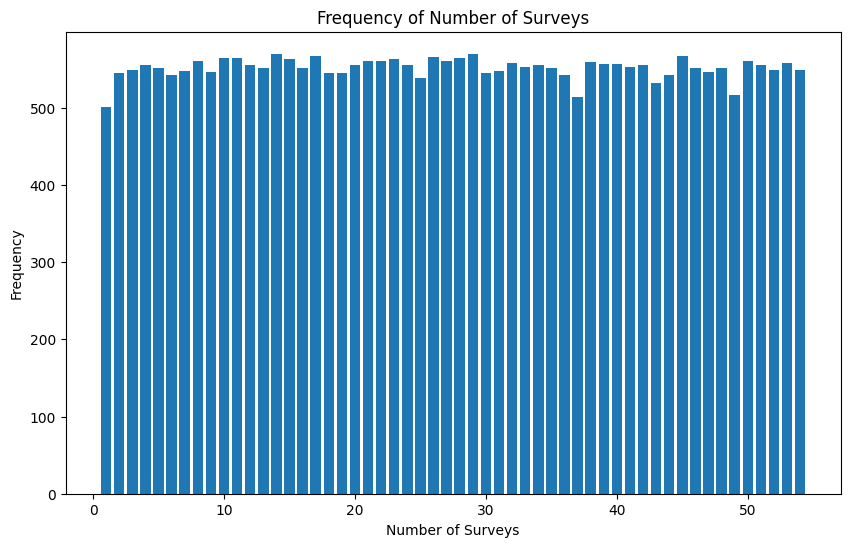

In [557]:
counts = df_full['number_of_survey'].value_counts().reset_index()

counts.columns = ['survey_number_wo_last', 'frequency']

plt.figure(figsize=(10, 6))
plt.bar(counts['survey_number_wo_last'], counts['frequency'])
plt.xlabel('Number of Surveys')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Surveys')
plt.show()



In [558]:
df_full['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    26691
0.0     2557
Name: count, dtype: int64

#### Select a random sample of 100 and 50 participants respectively

In [559]:

random_participant_ids = df_full['subject_id_roman_x'].sample(n=100, random_state=42).tolist()
df_100 = df_full[df_full['subject_id_roman_x'].isin(random_participant_ids)]


In [560]:
random_participant_ids = df_full['subject_id_roman_x'].sample(n=50, random_state=42).tolist()
df_50 = df_full[df_full['subject_id_roman_x'].isin(random_participant_ids)]


In [561]:
df_100.to_parquet(f'../outputs/Model_ready_df/df_100.parquet', index=False)

In [562]:
df_50.to_parquet(f'../outputs/Model_ready_df/df_50.parquet', index=False)

### Excluding any rows that have a non-completed survey before

In [563]:
df_full.head(60).tail(10)

subject_id_roman_x         issued_time  response delay  \
50     2023006-00146A 2022-01-24 18:05:45         608.353   
51     2023006-00146A 2022-01-24 20:47:38         604.074   
52     2023006-00508A 2022-01-19 09:07:30          33.712   
53     2023006-00508A 2022-01-19 11:24:26        1643.586   
54     2023006-00508A 2022-01-19 13:46:58         428.002   
55     2023006-00508A 2022-01-19 16:55:42         892.798   
56     2023006-00508A 2022-01-19 18:20:34         138.364   
57     2023006-00508A 2022-01-19 21:12:45          51.784   
58     2023006-00508A 2022-01-20 09:18:48         277.442   
59     2023006-00508A 2022-01-20 10:48:30          60.397   

    response_delay_10min  compliance  completion_time  \
50                   NaN           1             32.0   
51                   NaN           1             82.0   
52                33.712           1            413.0   
53                   NaN           1             68.0   
54               428.002           1             35.0   
55                   NaN           1             31.0   
56               138.364           1             74.0   
57                51.784           1            192.0   
58               277.442           1            228.0   
59                60.397           1             53.0   

   time_of_the_day_categories_dummy  \
50                                5   
51                              NaN   
52                                1   
53                                2   
54                                3   
55                                4   
56                                5   
57                              NaN   
58                                1   
59                                2   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
50                                        NaN            4.0     2.0     6.0   
51                                        NaN            4.0     2.0     1.0   
52                                          1            5.0     1.0     1.0   
53                                          2            5.0     2.0     1.0   
54                                          3            5.0     2.0     1.0   
55                                          4            5.0     1.0     2.0   
56                                        NaN            5.0     2.0     3.0   
57                                        NaN            5.0     1.0     1.0   
58                                          1            5.0     2.0     2.0   
59                                          2            5.0     2.0     2.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
50      6.0     3.0                53                9.0                1   
51      2.0     3.0                54                9.0                1   
52      1.0     5.0                 1                1.0                3   
53      1.0     5.0                 2                1.0                3   
54      2.0     4.0                 3                1.0                3   
55      2.0     5.0                 4                1.0                3   
56      2.0     5.0                 5                1.0                3   
57      2.0     6.0                 6                1.0                3   
58      2.0     4.0                 7                2.0                4   
59      2.0     5.0                 8                2.0                4   

    day_of_the_week_dummy  incentive_category  survey_length  \
50                    NaN                   1              8   
51                    NaN                   1             29   
52                    3.0                   1             25   
53                    3.0                   1              8   
54                    3.0                   1              2   
55                    3.0                   1              2   
56                    3.0                   1              4   
57                    3.0       

In [564]:
df_full.head(930).tail(10)

subject_id_roman_x         issued_time  response delay  \
920     2023006-00090A 2022-02-27 21:19:41          38.125   
921     2023006-00090A 2022-02-28 11:06:32          46.459   
922     2023006-00090A 2022-02-28 16:25:34          83.072   
923     2023006-00090A 2022-02-28 18:44:56          42.181   
924     2023006-00090A 2022-03-01 09:10:11         468.608   
925     2023006-00090A 2022-03-01 11:49:30        1274.348   
926     2023006-00090A 2022-03-01 13:25:03         287.782   
927     2023006-00090A 2022-03-01 16:49:21         617.387   
928     2023006-00090A 2022-03-01 19:37:57         611.272   
929     2023006-00090A 2022-03-01 21:13:56          23.779   

     response_delay_10min  compliance  completion_time  \
920                38.125           1             18.0   
921                46.459           1             22.0   
922                83.072           1             39.0   
923                42.181           1             16.0   
924               468.608           1             37.0   
925                   NaN           1             14.0   
926               287.782           1             63.0   
927                   NaN           1             21.0   
928                   NaN           1             12.0   
929                23.779           1             19.0   

    time_of_the_day_categories_dummy  \
920                              NaN   
921                                2   
922                                4   
923                                5   
924                                1   
925                                2   
926                                3   
927                                4   
928                                5   
929                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
920                                        NaN            4.0     0.0     0.0   
921                                          2            4.0     0.0     0.0   
922                                          4            4.0     0.0     0.0   
923                                        NaN            4.0     0.0     0.0   
924                                          1            2.0     0.0     0.0   
925                                          2            2.0     0.0     0.0   
926                                          3            2.0     0.0     0.0   
927                                          4            2.0     0.0     0.0   
928                                        NaN            2.0     0.0     0.0   
929                                        NaN            2.0     0.0     0.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
920      0.0     6.0                30                5.0                7   
921      0.0     6.0                32                6.0                1   
922      2.0     6.0                34                6.0                1   
923      2.0     6.0                35                6.0                1   
924      1.0     6.0                37                7.0                2   
925      2.0     6.0                38                7.0                2   
926      0.0     6.0                39                7.0                2   
927      0.0     6.0                40                7.0                2   
928      0.0     6.0                41                7.0                2   
929      0.0     6.0                42                7.0                2   

     day_of_the_week_dummy  incentive_category  survey_length  \
920                    7.0                   1              2   
921                    NaN                   1              6   
922                    NaN                   1              6   
923                    NaN                   1              1   
924                    2.0                   1              4   
925                    2.0                   1              1   
926                    2.0         

In [565]:
len(df_full)

29797

In [566]:
df_full['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    26691
0.0     2557
Name: count, dtype: int64

In [567]:
df_full['next_prompt_compliance'].isna().sum()

549

In [568]:
df_full['obscomp_steps'].value_counts()

obscomp_steps
0.0    23068
1.0     1517
2.0      219
3.0       45
4.0        5
Name: count, dtype: int64

In [569]:
df_full['obscomp_steps'].notna().sum()

24854

In [570]:
df_full['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

In [571]:
df_full['obscomp_steps'].isna().sum()

4943

In [572]:
df_full['compliance'].isna().sum()

0

full_surveys is actually not necessary since all surveys with an NA in compliance have already been excluded before

#### Remove all last prompt of day surveys

In [573]:
df_no_lapro = df_full[df_full['time_of_the_day_categories'] != 6]

In [574]:
len(df_no_lapro)

24854

In [575]:
df_no_lapro['next_prompt_compliance'].describe()

count    24854.000000
mean         0.918041
std          0.274307
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: next_prompt_compliance, dtype: float64

In [576]:
df_no_lapro['obscomp_steps'].value_counts()

obscomp_steps
0.0    23068
1.0     1517
2.0      219
3.0       45
4.0        5
Name: count, dtype: int64

In [577]:
df_no_lapro['obscomp_steps'].notna().sum()

24854

In [578]:
df_no_lapro['obscomp_steps'].isna().sum()

0

In [579]:
df_no_lapro['compliance'].notna().sum()

24854

In [580]:
df_no_lapro['compliance'].isna().sum()

0

In [581]:
df_no_lapro['next_prompt_compliance'].notna().sum()

24854

In [582]:
df_no_lapro['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    22817
0.0     2037
Name: count, dtype: int64

In [583]:
df_no_lapro['compliance'].value_counts()

compliance
1    24854
Name: count, dtype: int64

In [584]:
len(df_no_lapro)

24854

It turns out that the labelling of na rows in the obscomp_steps column did not work as desired for all! compliance = 0 columns, where obscomp steps should actually be 0 

In [585]:
df_no_lapro.head(60).tail(5)

subject_id_roman_x         issued_time  response delay  \
66     2023006-00508A 2022-01-21 13:59:25         154.384   
67     2023006-00508A 2022-01-21 16:47:36         632.440   
68     2023006-00508A 2022-01-21 18:35:34         112.995   
70     2023006-00508A 2022-01-22 09:30:19        1226.784   
71     2023006-00508A 2022-01-22 11:27:52         178.172   

    response_delay_10min  compliance  completion_time  \
66               154.384           1             97.0   
67                   NaN           1             53.0   
68               112.995           1             27.0   
70                   NaN           1            370.0   
71               178.172           1             21.0   

   time_of_the_day_categories_dummy  \
66                                3   
67                                4   
68                                5   
70                                1   
71                                2   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
66                                          3            5.0     2.0     1.0   
67                                          4            5.0     1.0     2.0   
68                                        NaN            5.0     1.0     2.0   
70                                          1            4.0     2.0     2.0   
71                                          2            4.0     3.0     2.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
66      2.0     4.0                15                3.0                5   
67      3.0     5.0                16                3.0                5   
68      3.0     5.0                17                3.0                5   
70      2.0     4.0                19                4.0                6   
71      3.0     4.0                20                4.0                6   

    day_of_the_week_dummy  incentive_category  survey_length  \
66                    5.0                   1             10   
67                    5.0                   1              5   
68                    5.0                   1              4   
70                    6.0                   1             14   
71                    6.0                   1              1   

    first_question_length  location_current_ordinal  location_current_commute  \
66                      3                       7.0                     False   
67                      2                       3.0                      True   
68                      1                       1.0                     False   
70                      3                       NaN                     False   
71                      1                       NaN                     False   

    location_current_green_spaces  location_current_home  \
66                          False                  False   
67                          False                  False   
68                          False                   True   
70                          False                  False   
71                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
66                          False                               False   
67                          False                               False   
68                          False                               False   
70                          False                               False   
71                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
66                   False                 False                   False   
67                   False                 False                   False   
68                   False                 False                   False   
70                   False                  True                   False   
71                   False                 False              

In [586]:
df_no_lapro['ct_per_survey_item'].describe()

count    24854.000000
mean         6.103259
std          8.440939
min          0.333333
25%          3.100000
50%          4.466667
75%          6.714286
max        316.250000
Name: ct_per_survey_item, dtype: float64

In [587]:
df_full.to_parquet(f'../outputs/Model_ready_df/df_full_surveys_incl_next_prompt_0.parquet', index=False)

In [588]:
df_no_lapro.to_parquet(f'../outputs/Model_ready_df/df_no_lapro.parquet', index=False)

#### Drop any rows where obscopm steps = na (esentially any rows where compliance is = 0)

In [589]:
df_no_lapro_noobsc = df_no_lapro[df_no_lapro['obscomp_steps'].notna()].copy()


In [590]:
df_no_lapro_noobsc['compliance'].value_counts()

compliance
1    24854
Name: count, dtype: int64

In [591]:
df_no_lapro_noobsc['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    22817
0.0     2037
Name: count, dtype: int64

In [592]:
df_no_lapro_noobsc['next_prompt_compliance'].notna().sum()

24854

In [593]:
df_no_lapro_noobsc['compliance'].isna().sum()

0

In [594]:
df_no_lapro_noobsc['compliance'].notna().sum()

24854

In [595]:
df_no_lapro_noobsc['obscomp_steps'].notna().sum()

24854

In [596]:
df_no_lapro_noobsc['obscomp_steps'].isna().sum()

0

In [597]:
df_no_lapro_noobsc['obscomp_steps'].value_counts()

obscomp_steps
0.0    23068
1.0     1517
2.0      219
3.0       45
4.0        5
Name: count, dtype: int64

In [598]:
df_no_lapro_noobsc['obscomp_steps'].describe()

count    24854.000000
mean         0.084896
std          0.329535
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: obscomp_steps, dtype: float64

In [599]:
len(df_no_lapro_noobsc)

24854

In [600]:
df_no_lapro_noobsc.to_parquet(f'../outputs/Model_ready_df/df_full_no_last_prompt_full_surveys.parquet', index=False)

##### Frequencies next-prompt compliance outcome

In [601]:
columns_of_interest = ['next_prompt_compliance', 'sleep_quality', 'stress', 'affect', 'hunger', 'fatigue', 'obscomp_steps', 
                       'age', 'gender', 'day_of_monitoring', 'time_of_the_day_categories_dummy', 'day_of_the_week_binary', 'ipi', 
                       'subject_id_roman_x']

# Calculating descriptive statistics
descriptive_stats = df_no_lapro_noobsc[columns_of_interest].describe()

descriptive_stats_transposed = descriptive_stats.transpose()

In [602]:
descriptive_stats_transposed

count        mean        std  min         25%  \
next_prompt_compliance  24854.0    0.918041   0.274307  0.0    1.000000   
sleep_quality           24854.0    3.779412   1.303220  0.0    3.000000   
stress                  24854.0    1.656474   1.406153  0.0    1.000000   
affect                  24854.0    3.579826   1.333846  0.0    3.000000   
hunger                  24854.0    1.657842   1.424423  0.0    1.000000   
fatigue                 24854.0    2.257665   1.515753  0.0    1.000000   
obscomp_steps           24854.0    0.084896   0.329535  0.0    0.000000   
age                     24854.0   20.914501  14.048673  1.0    9.000000   
gender                  24854.0    0.660940   0.473400  0.0    0.000000   
day_of_monitoring       24854.0    4.995252   2.572362  1.0    3.000000   
day_of_the_week_binary  24854.0    0.310735   0.462804  0.0    0.000000   
ipi                     24854.0  145.711472  37.199836  0.0  119.383333   

                               50%       75%         max  
next_prompt_compliance    1.000000    1.0000    1.000000  
sleep_quality             4.000000    5.0000    6.000000  
stress                    1.000000    3.0000    6.000000  
affect                    3.000000    5.0000    6.000000  
hunger                    1.000000    3.0000    6.000000  
fatigue                   2.000000    3.0000    6.000000  
obscomp_steps             0.000000    0.0000    4.000000  
age                      17.000000   34.0000   49.000000  
gender                    1.000000    1.0000    1.000000  
day_of_monitoring         5.000000    7.0000    9.000000  
day_of_the_week_binary    0.000000    1.0000    1.000000  
ipi                     145.983333  171.7625  246.166667

In [603]:
descriptive_stats_transposed.to_csv('../outputs/for_draft/frequency_tables/frequencies_next_prompt_compliance.csv')

In [604]:
df_no_lapro_noobsc.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00146A 2022-01-16 09:18:10         626.993   
1     2023006-00146A 2022-01-16 11:31:06         613.781   
2     2023006-00146A 2022-01-16 13:40:18         613.323   
3     2023006-00146A 2022-01-16 15:35:15         613.173   
4     2023006-00146A 2022-01-16 19:12:40         934.251   

   response_delay_10min  compliance  completion_time  \
0                   NaN           1            154.0   
1                   NaN           1             16.0   
2                   NaN           1             37.0   
3                   NaN           1             18.0   
4                   NaN           1             20.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            4.0     3.0     1.0      4.0     3.0                 1   
1            4.0     1.0     1.0      1.0     2.0                 2   
2            4.0     4.0     2.0      3.0     3.0                 3   
3            4.0     2.0     5.0      3.0     3.0                 4   
4            4.0     4.0     3.0      5.0     3.0                 5   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1             26                      4   
1                   1              2                      2   
2                   1              9                      4   
3                   1              2                      2   
4                   1              3                      3   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False                 False                   False   
4                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_

In [605]:
unique_subjects_with_nan_sleep_quality = df_no_lapro_noobsc.loc[df_no_lapro_noobsc['sleep_quality'].isna(), 'subject_id_roman_x'].nunique()

print("Number of unique subject_id_roman_x values where sleep_quality is NaN:", unique_subjects_with_nan_sleep_quality)


Number of unique subject_id_roman_x values where sleep_quality is NaN: 0


In [606]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Identify subject_id_roman_x values with missing values in specified columns
subjects_with_missing_values = df_no_lapro_noobsc[df_no_lapro_noobsc[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Creating a new DataFrame without rows containing missing values in specified columns and for the identified subjects
df_no_lapro_noobscpredict = df_no_lapro_noobsc[~df_no_lapro_noobsc['subject_id_roman_x'].isin(subjects_with_missing_values)]




In [607]:
print(subjects_with_missing_values)

[]


In [608]:
import pandas as pd

# Assuming df_no_lapro_noobsc is your DataFrame and columns_to_check is the list of columns
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Check for NaN values in the specified columns
nan_values = df_no_lapro_noobsc[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to include only rows with NaN values in at least one column
filtered_df = df_no_lapro_noobsc[nan_values]

# Count the number of unique participant IDs in the filtered DataFrame
unique_participant_count = filtered_df['subject_id_roman_x'].nunique()

print(f"Number of unique participant IDs with NaN values in at least one column: {unique_participant_count}")


Number of unique participant IDs with NaN values in at least one column: 0


In [609]:
filtered_df.head()

Empty DataFrame
Columns: [subject_id_roman_x, issued_time, response delay, response_delay_10min, compliance, completion_time, time_of_the_day_categories_dummy, time_of_the_day_categories_dummy_no_last_p, sleep_quality, stress, hunger, fatigue, affect, number_of_survey, day_of_monitoring, day_of_the_week, day_of_the_week_dummy, incentive_category, survey_length, first_question_length, location_current_ordinal, location_current_commute, location_current_green_spaces, location_current_home, location_current_home_outside, location_current_indoors_elsewhere, location_current_other, time_of_day_8_to_930, time_of_day_1030_to_12, time_of_day_13_to_1430, time_of_day_1530_to_17, time_of_day_18_to_1930, time_of_day_2030_to_2130, day_of_week_monday, day_of_week_tuesday, day_of_week_wednesday, day_of_week_thursday, day_of_week_friday, day_of_week_saturday, day_of_week_sunday, day_of_the_week_binary, age, gender, ethnicity, education_level, familiarity_digital_devices, employment_status, night_shifts_binary, household_income, alcohol_consumption, extraversion, agreeableness, conscientiousness, neuroticism, openness, screen_time_average_smartphone_mins, screen_time_average, smoking_binary, employment_status_binary, nothing, next_issued_time, ipi, response_ten_binary, next_prompt_compliance, survey_length_n, ct_per_survey_item, careless_response, careless_response_one, careless_response_three, careless_response_five, careless_response_sub_two, careless_response_sub_one_point_five, careless_response_one_point_five, fast_response_one_three, fast_response_one_two, fast_response_one_sub_two, fast_response_point_five_two, fast_response_point_five_three, fast_response_point_five_sub_two, fast_response_two_four, fast_response_one_one_point_five, length_zero_binary, length_zero_no_careless_one, length_zero_no_careless_two, length_zero_no_careless_one_point_five, nothing_no_careless_one, nothing_no_careless_one_point_five, nothing_no_careless_two, nothing_no_careless_one_nulllength, nothing_no_careless_one_point_five_nulllength, nothing_no_careless_two_nulllength, ct_per_survey_item_one_median, ct_per_survey_item_one_point_five_median, ct_per_survey_item_two_median, ct_per_survey_item_two_point_five_median, ct_per_survey_item_three_median, ct_per_survey_item_three_point_five_median, ct_per_survey_item_four_median, longstring, longstring_careless_one, ...]
Index: []

In [610]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Get the participant IDs with NaN values in at least one column
participants_with_nan = df_no_lapro_noobsc[df_no_lapro_noobsc[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Drop rows corresponding to the participant IDs with NaN values
df_no_nan_values = df_no_lapro_noobsc[~df_no_lapro_noobsc['subject_id_roman_x'].isin(participants_with_nan)]

# Print the shape of the original and filtered DataFrames for comparison
print("Original DataFrame shape:", df_no_lapro_noobsc.shape)
print("DataFrame after dropping rows with NaN values shape:", df_no_nan_values.shape)


Original DataFrame shape: (24854, 139)
DataFrame after dropping rows with NaN values shape: (24854, 139)


Remove rows from 5 participants because they still have missing values in one of the 5 main variables

In [611]:
df_no_nan_values['subject_id_roman_x'].nunique()

617

In [612]:
df_no_nan_values.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00146A 2022-01-16 09:18:10         626.993   
1     2023006-00146A 2022-01-16 11:31:06         613.781   
2     2023006-00146A 2022-01-16 13:40:18         613.323   
3     2023006-00146A 2022-01-16 15:35:15         613.173   
4     2023006-00146A 2022-01-16 19:12:40         934.251   

   response_delay_10min  compliance  completion_time  \
0                   NaN           1            154.0   
1                   NaN           1             16.0   
2                   NaN           1             37.0   
3                   NaN           1             18.0   
4                   NaN           1             20.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            4.0     3.0     1.0      4.0     3.0                 1   
1            4.0     1.0     1.0      1.0     2.0                 2   
2            4.0     4.0     2.0      3.0     3.0                 3   
3            4.0     2.0     5.0      3.0     3.0                 4   
4            4.0     4.0     3.0      5.0     3.0                 5   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1             26                      4   
1                   1              2                      2   
2                   1              9                      4   
3                   1              2                      2   
4                   1              3                      3   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False                 False                   False   
4                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_

In [613]:
df_missing_sleep_quality = df_no_lapro_noobsc[df_no_lapro_noobsc['sleep_quality'].isnull()]



In [614]:
df_missing_sleep_quality.head(1)

Empty DataFrame
Columns: [subject_id_roman_x, issued_time, response delay, response_delay_10min, compliance, completion_time, time_of_the_day_categories_dummy, time_of_the_day_categories_dummy_no_last_p, sleep_quality, stress, hunger, fatigue, affect, number_of_survey, day_of_monitoring, day_of_the_week, day_of_the_week_dummy, incentive_category, survey_length, first_question_length, location_current_ordinal, location_current_commute, location_current_green_spaces, location_current_home, location_current_home_outside, location_current_indoors_elsewhere, location_current_other, time_of_day_8_to_930, time_of_day_1030_to_12, time_of_day_13_to_1430, time_of_day_1530_to_17, time_of_day_18_to_1930, time_of_day_2030_to_2130, day_of_week_monday, day_of_week_tuesday, day_of_week_wednesday, day_of_week_thursday, day_of_week_friday, day_of_week_saturday, day_of_week_sunday, day_of_the_week_binary, age, gender, ethnicity, education_level, familiarity_digital_devices, employment_status, night_shifts_binary, household_income, alcohol_consumption, extraversion, agreeableness, conscientiousness, neuroticism, openness, screen_time_average_smartphone_mins, screen_time_average, smoking_binary, employment_status_binary, nothing, next_issued_time, ipi, response_ten_binary, next_prompt_compliance, survey_length_n, ct_per_survey_item, careless_response, careless_response_one, careless_response_three, careless_response_five, careless_response_sub_two, careless_response_sub_one_point_five, careless_response_one_point_five, fast_response_one_three, fast_response_one_two, fast_response_one_sub_two, fast_response_point_five_two, fast_response_point_five_three, fast_response_point_five_sub_two, fast_response_two_four, fast_response_one_one_point_five, length_zero_binary, length_zero_no_careless_one, length_zero_no_careless_two, length_zero_no_careless_one_point_five, nothing_no_careless_one, nothing_no_careless_one_point_five, nothing_no_careless_two, nothing_no_careless_one_nulllength, nothing_no_careless_one_point_five_nulllength, nothing_no_careless_two_nulllength, ct_per_survey_item_one_median, ct_per_survey_item_one_point_five_median, ct_per_survey_item_two_median, ct_per_survey_item_two_point_five_median, ct_per_survey_item_three_median, ct_per_survey_item_three_point_five_median, ct_per_survey_item_four_median, longstring, longstring_careless_one, ...]
Index: []

In [615]:
len(df_no_lapro_noobscpredict)

24854

In [616]:
df_no_lapro_noobscpredict['subject_id_roman_x'].nunique()

617

In [617]:
nan_values = df_no_lapro_noobscpredict.isna().any()

# Display columns with NaN values
columns_with_nan = nan_values[nan_values].index.tolist()
print("Columns with NaN values:", columns_with_nan)

# Count the number of NaN values in each column
nan_count_per_column = df_no_lapro_noobscpredict.isna().sum()
print("Number of NaN values in each column:")
print(nan_count_per_column)


Columns with NaN values: ['response_delay_10min', 'time_of_the_day_categories_dummy_no_last_p', 'day_of_the_week_dummy', 'location_current_ordinal', 'night_shifts_binary', 'household_income', 'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness', 'screen_time_average_smartphone_mins', 'screen_time_average', 'fast_response_one_three', 'fast_response_one_two', 'fast_response_one_sub_two', 'fast_response_point_five_two', 'fast_response_point_five_three', 'fast_response_point_five_sub_two', 'fast_response_two_four', 'fast_response_one_one_point_five', 'length_zero_no_careless_one', 'length_zero_no_careless_two', 'length_zero_no_careless_one_point_five', 'nothing_no_careless_one', 'nothing_no_careless_one_point_five', 'nothing_no_careless_two', 'nothing_no_careless_one_nulllength', 'nothing_no_careless_one_point_five_nulllength', 'nothing_no_careless_two_nulllength', 'ct_per_survey_item_one_median', 'ct_per_survey_item_one_point_five_median', 'ct_per_survey_item_tw

#### Make dataset for careless responding outcome and remove all next prompt-compliance = 0 surveys as those should be NAN for careless responding (longstring/ completion time) because the next survey has not been completed

In [618]:
df_no_lapro_noobsc.head()

subject_id_roman_x         issued_time  response delay  \
0     2023006-00146A 2022-01-16 09:18:10         626.993   
1     2023006-00146A 2022-01-16 11:31:06         613.781   
2     2023006-00146A 2022-01-16 13:40:18         613.323   
3     2023006-00146A 2022-01-16 15:35:15         613.173   
4     2023006-00146A 2022-01-16 19:12:40         934.251   

   response_delay_10min  compliance  completion_time  \
0                   NaN           1            154.0   
1                   NaN           1             16.0   
2                   NaN           1             37.0   
3                   NaN           1             18.0   
4                   NaN           1             20.0   

  time_of_the_day_categories_dummy time_of_the_day_categories_dummy_no_last_p  \
0                                1                                          1   
1                                2                                          2   
2                                3                                          3   
3                                4                                          4   
4                                5                                        NaN   

   sleep_quality  stress  hunger  fatigue  affect  number_of_survey  \
0            4.0     3.0     1.0      4.0     3.0                 1   
1            4.0     1.0     1.0      1.0     2.0                 2   
2            4.0     4.0     2.0      3.0     3.0                 3   
3            4.0     2.0     5.0      3.0     3.0                 4   
4            4.0     4.0     3.0      5.0     3.0                 5   

   day_of_monitoring  day_of_the_week  day_of_the_week_dummy  \
0                1.0                7                    7.0   
1                1.0                7                    7.0   
2                1.0                7                    7.0   
3                1.0                7                    7.0   
4                1.0                7                    7.0   

   incentive_category  survey_length  first_question_length  \
0                   1             26                      4   
1                   1              2                      2   
2                   1              9                      4   
3                   1              2                      2   
4                   1              3                      3   

   location_current_ordinal  location_current_commute  \
0                       NaN                     False   
1                       NaN                     False   
2                       NaN                     False   
3                       NaN                     False   
4                       NaN                     False   

   location_current_green_spaces  location_current_home  \
0                          False                  False   
1                          False                  False   
2                          False                  False   
3                          False                  False   
4                          False                  False   

   location_current_home_outside  location_current_indoors_elsewhere  \
0                          False                               False   
1                          False                               False   
2                          False                               False   
3                          False                               False   
4                          False                               False   

   location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
0                   False                  True                   False   
1                   False                 False                    True   
2                   False                 False                   False   
3                   False                 False                   False   
4                   False                 False                   False   

   time_of_day_13_to_1430  time_of_day_1530_

In [619]:
df_no_lapro_noobsc['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    22817
0.0     2037
Name: count, dtype: int64

In [620]:
df_no_lapro_noobsc['next_prompt_ct_per_survey_item'].isna().sum()

1937

In [621]:
df_no_lapro_noobsc['next_prompt_completion_time'].isna().sum()

1937

In [622]:
fil_df = df_no_lapro_noobsc[df_no_lapro_noobsc['next_prompt_compliance'] != 0]

# Save the remaining rows to a new DataFrame
df_no_lapro_noobsc_no_null_nepro_comp = fil_df.copy()

In [623]:
df_no_lapro_noobsc_no_null_nepro_comp['next_prompt_ct_per_survey_item'].isna().sum()

0

In [624]:
df_no_lapro_noobsc_no_null_nepro_comp['next_prompt_ct_per_survey_item'].describe()

count    22817.000000
mean         5.813043
std          8.449930
min          0.375000
25%          3.000000
50%          4.250000
75%          6.400000
max        389.250000
Name: next_prompt_ct_per_survey_item, dtype: float64

In [625]:
df_no_lapro_noobsc_no_null_nepro_comp['next_prompt_longstring'].value_counts()

next_prompt_longstring
0.0    21559
1.0     1258
Name: count, dtype: int64

In [626]:
df_no_lapro_noobsc_no_null_nepro_comp.to_parquet(f'../outputs/Model_ready_df/df_nepro_careless.parquet', index=False)

In [627]:
len(df_no_lapro_noobsc_no_null_nepro_comp)

22817

#### Frequencies Next-prompt Straightlining

In [628]:
columns_of_interest = ['next_prompt_longstring', 'sleep_quality', 'stress', 'affect', 'hunger', 'fatigue', 'obscomp_steps', 
                       'age', 'gender', 'day_of_monitoring', 'time_of_the_day_categories_dummy', 'day_of_the_week_binary', 'ipi', 
                       'subject_id_roman_x']

# Calculating descriptive statistics
descriptive_stats = df_no_lapro_noobsc_no_null_nepro_comp[columns_of_interest].describe()

# Transposing the descriptive statistics DataFrame
descriptive_stats_transposed = descriptive_stats.transpose()

In [629]:
descriptive_stats_transposed.to_csv('../outputs/for_draft/frequency_tables/frequencies_next_prompt_straightlining.csv')

Finished Next-prompt_compliance

### Dataset for response delay and completion time outcome (including last survey of the day)

In [630]:
df.head()

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   
56     2023006-00146A 2022-01-16 13:40:18         613.323   
57     2023006-00146A 2022-01-16 15:35:15         613.173   
58     2023006-00146A 2022-01-16 19:12:40         934.251   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   
56                   NaN           1             37.0   
57                   NaN           1             18.0   
58                   NaN           1             20.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   
56                                3   
57                                4   
58                                5   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   
56                                          3            4.0     4.0     2.0   
57                                          4            4.0     2.0     5.0   
58                                        NaN            4.0     4.0     3.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   
56      3.0     3.0                 3                1.0                7   
57      3.0     3.0                 4                1.0                7   
58      5.0     3.0                 5                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   
56                    7.0                   1              9   
57                    7.0                   1              2   
58                    7.0                   1              3   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   
56                      4                       NaN                     False   
57                      2                       NaN                     False   
58                      3                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   
56                          False                  False   
57                          False                  False   
58                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   
56                          False                               False   
57                          False                               False   
58                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   
56                   False                 False                   False   
57                   False                 False                   False   
58                   False                 False              

In [631]:
len(df)

29797

In [632]:
df_time = df.copy()

In [633]:
df_time['next_prompt_compliance'].value_counts()

next_prompt_compliance
1.0    27132
0.0     2664
Name: count, dtype: int64

In [634]:
df_time['next_prompt_compliance'].isna().sum()

1

In [635]:
df_time['next_prompt_compliance'].notna().sum()

29796

In [636]:
df_time['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

In [637]:
df_time['compliance'].isna().sum()

0

In [638]:
df_time['compliance'].notna().sum()

29797

In [639]:
df_time['obscomp_steps'].notna().sum()

29797

In [640]:
df_time['obscomp_steps'].isna().sum()

0

In [641]:
df_time['obscomp_steps'].value_counts()

obscomp_steps
0.0    27611
1.0     1835
2.0      275
3.0       65
4.0        8
5.0        3
Name: count, dtype: int64

In [642]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Identify subject_id_roman_x values with missing values in specified columns
subjects_with_missing_values = df_time[df_time[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Creating a new DataFrame without rows containing missing values in specified columns and for the identified subjects
df_no_lapro_noobscpredict = df_time[~df_time['subject_id_roman_x'].isin(subjects_with_missing_values)]




In [643]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Check for NaN values in the specified columns
nan_values = df_time[columns_to_check].isnull().any(axis=1)

# Filter the DataFrame to include only rows with NaN values in at least one column
filtered_df = df_time[nan_values]

# Count the number of unique participant IDs in the filtered DataFrame
unique_participant_count = filtered_df['subject_id_roman_x'].nunique()

print(f"Number of unique participant IDs with NaN values in at least one column: {unique_participant_count}")


Number of unique participant IDs with NaN values in at least one column: 0


In [644]:
columns_to_check = ['sleep_quality', 'stress', 'affect', 'fatigue', 'hunger']

# Get the participant IDs with NaN values in at least one column
participants_with_nan = df_time[df_time[columns_to_check].isnull().any(axis=1)]['subject_id_roman_x'].unique()

# Drop rows corresponding to the participant IDs with NaN values
df_no_nan_values = df_time[~df_time['subject_id_roman_x'].isin(participants_with_nan)]

# Print the shape of the original and filtered DataFrames for comparison
print("Original DataFrame shape:", df_time.shape)
print("DataFrame after dropping rows with NaN values shape:", df_no_nan_values.shape)


Original DataFrame shape: (29797, 138)
DataFrame after dropping rows with NaN values shape: (29797, 138)


Remove rows from 5 participants because they still have missing values in one of the 5 main variables

In [645]:
df_no_nan_values['subject_id_roman_x'].nunique()

617

In [646]:
df_no_nan_values.head(1)

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   

   time_of_the_day_categories_dummy  \
54                                1   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   

    time_of_day_13_to_1430  time_of_day_1530_to_17  time_of_day_18_to_1930  \
54                   False                   False                   False   

    time_of_day_2030_to_2130  day_of_week_monday  day_of_week_tuesday  \
54                     False               False                False   

    day_of_week_wednesday  day_of_week_thursday  day_of_week_friday  \
54                  False                 False               False   

    day_of_week_saturday  day_of_week_sunday  day_of_the_week_binary  age  \
54                 False                True                     1.0    1   

    gender  ethnicity  education_level  familiarity_digital_devices  \
54       1          1                5                            1   

    employment_status  night_shifts_binary household_income  \
54                  4                  NaN                2   

    alcohol_consumption  extraversion  agreeableness  conscientiousness  \
54                    1           0.5            4.0                3.0   

    neuroticism  openness  screen_time_average_smartphone_mins  \
54          4.0       4.5                                120.0   

    screen_time_average  smoking_binary  employment_status_binary  nothing  \
54                630.0               1                         1        0   

      next_issued_time         ipi  response_ten_binary  \
54 2022-01-16 11:31:06  132.933333                    0   

    next_prompt_compliance  survey_length_n  ct_per_survey_item  \
54                     1.0               30            5.310345   

    careless_response  careless_response_one  careless_response_three  \
54                  0                      0                        0   

    careless_response_five  careless_response_sub_two  \
54                       0                          0   

    careless_response_sub_one_point_five  careless_response_one_point_five  \
54                                     0                                 0   

    fast_response_one_three  fast_response_one_two  fast_response_one_sub_two  \
54                      0.0                    0.0                        0.0   

    fast_response_point_five_two  fast_response_point_five_three  \
54                           0.0                             0.0   

    fast_response_point_five_sub_two  fast_response_two_four  \
54                               0.0                     0.0   

    fast_response_one_one_point_five  length_zero_binary  \
54                               0.0                   0   

    length_zero_no_careless_one  length_zero_no_careless_two  \
54                          0.0                          

In [647]:
df_time = df_no_nan_values.copy()

In [648]:
df_time_comp = df_time[df_time['compliance'] != 0]

In [649]:
df_time_comp['obscomp_steps'].isna().sum()

0

In [650]:
df_time_comp['obscomp_steps'].notna().sum()

29797

In [651]:
df_time_comp['obscomp_steps'].value_counts()

obscomp_steps
0.0    27611
1.0     1835
2.0      275
3.0       65
4.0        8
5.0        3
Name: count, dtype: int64

In [652]:
df_time_comp['obscomp_steps'].describe()

count    29797.000000
mean         0.088163
std          0.342311
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: obscomp_steps, dtype: float64

In [653]:
df_time_comp['compliance'].notna().sum()

29797

In [654]:
df_time_comp['compliance'].isna().sum()

0

In [655]:
df_time_comp['compliance'].value_counts()

compliance
1    29797
Name: count, dtype: int64

#### Remove all rows with response delay > 10 mins

In [656]:
df_time_comp.head()

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   
56     2023006-00146A 2022-01-16 13:40:18         613.323   
57     2023006-00146A 2022-01-16 15:35:15         613.173   
58     2023006-00146A 2022-01-16 19:12:40         934.251   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   
56                   NaN           1             37.0   
57                   NaN           1             18.0   
58                   NaN           1             20.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   
56                                3   
57                                4   
58                                5   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   
56                                          3            4.0     4.0     2.0   
57                                          4            4.0     2.0     5.0   
58                                        NaN            4.0     4.0     3.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   
56      3.0     3.0                 3                1.0                7   
57      3.0     3.0                 4                1.0                7   
58      5.0     3.0                 5                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   
56                    7.0                   1              9   
57                    7.0                   1              2   
58                    7.0                   1              3   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   
56                      4                       NaN                     False   
57                      2                       NaN                     False   
58                      3                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   
56                          False                  False   
57                          False                  False   
58                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   
56                          False                               False   
57                          False                               False   
58                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   
56                   False                 False                   False   
57                   False                 False                   False   
58                   False                 False              

#### This should be the output for completion time

In [657]:
df_time_comp['completion_time'].describe()

count    29797.000000
mean        81.829245
std        115.730844
min          2.000000
25%         23.000000
50%         51.000000
75%        100.000000
max       2842.000000
Name: completion_time, dtype: float64

In [658]:
df_time_comp['subject_id_roman_x'].nunique()

617

df_time_comp.to_parquet(f'../outputs/Model_ready_df/df_completion_time.parquet', index=False)

##### Make output TPI one_median

In [659]:
len(df_time_comp)

29797

In [660]:
df_tpi = df_time_comp.copy()

In [661]:
len(df_tpi)

29797

In [662]:
df_tpi['ct_per_survey_item'].describe()

count    29797.000000
mean         6.126871
std          8.711480
min          0.333333
25%          3.142857
50%          4.500000
75%          6.750000
max        389.250000
Name: ct_per_survey_item, dtype: float64

In [663]:
df_tpi.to_parquet(f'../outputs/Model_ready_df/df_tpi.parquet', index=False)

##### Frequencies fast responging/completion time per survey item (TPI)

In [664]:
columns_of_interest = ['ct_per_survey_item_one_median', 'sleep_quality', 'stress', 'affect', 'hunger', 'fatigue', 'obscomp_steps', 
                       'age', 'gender', 'day_of_monitoring', 'time_of_the_day_categories_dummy', 'day_of_the_week_binary', 'ipi', 
                       'subject_id_roman_x', 'ct_per_survey_item_one_point_five_median', 'ct_per_survey_item_two_median']

# Calculating descriptive statistics
descriptive_stats = df_tpi[columns_of_interest].describe()

# Transposing the descriptive statistics DataFrame
descriptive_stats_transposed = descriptive_stats.transpose()

In [665]:
descriptive_stats_transposed.to_csv('../outputs/for_draft/frequency_tables/frequencies_fast_responding.csv')

#### This is the output for response delay

In [666]:
df_time_comp_no_respona = df_time_comp.dropna(subset=['response_delay_10min'])

In [667]:
df_time_comp_no_respona['response_delay_10min'].describe()

count    12034.000000
mean       197.957207
std        181.955465
min          1.707000
25%         30.554500
50%        140.406500
75%        342.856000
max        597.934000
Name: response_delay_10min, dtype: float64

In [668]:
df_time_comp_no_respona['compliance'].notna().sum()

12034

In [669]:
df_time_comp_no_respona['obscomp_steps'].value_counts()

obscomp_steps
0.0    11134
1.0      760
2.0      106
3.0       27
4.0        5
5.0        2
Name: count, dtype: int64

In [670]:
df_time_comp_no_respona['obscomp_steps'].describe()

count    12034.000000
mean         0.089995
std          0.348273
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: obscomp_steps, dtype: float64

In [671]:
df_time_comp_no_respona['obscomp_steps'].notna().sum()

12034

In [672]:
df_time_comp_no_respona.to_parquet(f'../outputs/Model_ready_df/df_response_delay_10mins.parquet', index=False)

##### Frequencies late responing

In [673]:
columns_of_interest = ['response_delay_10min', 'sleep_quality', 'stress', 'affect', 'hunger', 'fatigue', 'obscomp_steps', 
                       'age', 'gender', 'day_of_monitoring', 'time_of_the_day_categories_dummy', 'day_of_the_week_binary', 'ipi', 
                       'subject_id_roman_x', 'obscomp_steps_ten', 'survey_length_n']

# Calculating descriptive statistics
descriptive_stats = df_time_comp_no_respona[columns_of_interest].describe()

# Transposing the descriptive statistics DataFrame
descriptive_stats_transposed = descriptive_stats.transpose()

In [674]:
df_time_comp_no_respona['survey_length_n'].describe()

count    12034.000000
mean        13.620160
std          7.261501
min          4.000000
25%          7.000000
50%         13.000000
75%         18.000000
max         53.000000
Name: survey_length_n, dtype: float64

In [675]:
df_time_comp_no_respona.head()

subject_id_roman_x         issued_time  response delay  \
89      2023006-00146A 2022-01-21 20:32:54         362.367   
108     2023006-00508A 2022-01-19 09:07:30          33.712   
110     2023006-00508A 2022-01-19 13:46:58         428.002   
112     2023006-00508A 2022-01-19 18:20:34         138.364   
113     2023006-00508A 2022-01-19 21:12:45          51.784   

     response_delay_10min  compliance  completion_time  \
89                362.367           1             59.0   
108                33.712           1            413.0   
110               428.002           1             35.0   
112               138.364           1             74.0   
113                51.784           1            192.0   

    time_of_the_day_categories_dummy  \
89                               NaN   
108                                1   
110                                3   
112                                5   
113                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
89                                         NaN            1.0     2.0     1.0   
108                                          1            5.0     1.0     1.0   
110                                          3            5.0     2.0     1.0   
112                                        NaN            5.0     2.0     3.0   
113                                        NaN            5.0     1.0     1.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
89       4.0     2.0                36                6.0                5   
108      1.0     5.0                 1                1.0                3   
110      2.0     4.0                 3                1.0                3   
112      2.0     5.0                 5                1.0                3   
113      2.0     6.0                 6                1.0                3   

     day_of_the_week_dummy  incentive_category  survey_length  \
89                     5.0                   1             11   
108                    3.0                   1             25   
110                    3.0                   1              2   
112                    3.0                   1              4   
113                    3.0                   1             17   

     first_question_length  location_current_ordinal  \
89                       2                       NaN   
108                      4                       NaN   
110                      2                       NaN   
112                      2                       5.0   
113                      4                       NaN   

     location_current_commute  location_current_green_spaces  \
89                      False                          False   
108                     False                          False   
110                     False                          False   
112                     False                          False   
113                     False                          False   

     location_current_home  location_current_home_outside  \
89                   False                          False   
108                  False                          False   
110                  False                          False   
112                  False                           True   
113                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
89                                False                   False   
108                               False                   False   
110                               False                   False   
112                               False                   False   
113                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
89                  False                   False                   False   
108                  True                   Fals

In [676]:
descriptive_stats_transposed.to_csv('../outputs/for_draft/frequency_tables/frequencies_late_responding.csv')

### Visualisations

In [677]:
df_time_comp_no_respona.head()

subject_id_roman_x         issued_time  response delay  \
89      2023006-00146A 2022-01-21 20:32:54         362.367   
108     2023006-00508A 2022-01-19 09:07:30          33.712   
110     2023006-00508A 2022-01-19 13:46:58         428.002   
112     2023006-00508A 2022-01-19 18:20:34         138.364   
113     2023006-00508A 2022-01-19 21:12:45          51.784   

     response_delay_10min  compliance  completion_time  \
89                362.367           1             59.0   
108                33.712           1            413.0   
110               428.002           1             35.0   
112               138.364           1             74.0   
113                51.784           1            192.0   

    time_of_the_day_categories_dummy  \
89                               NaN   
108                                1   
110                                3   
112                                5   
113                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
89                                         NaN            1.0     2.0     1.0   
108                                          1            5.0     1.0     1.0   
110                                          3            5.0     2.0     1.0   
112                                        NaN            5.0     2.0     3.0   
113                                        NaN            5.0     1.0     1.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
89       4.0     2.0                36                6.0                5   
108      1.0     5.0                 1                1.0                3   
110      2.0     4.0                 3                1.0                3   
112      2.0     5.0                 5                1.0                3   
113      2.0     6.0                 6                1.0                3   

     day_of_the_week_dummy  incentive_category  survey_length  \
89                     5.0                   1             11   
108                    3.0                   1             25   
110                    3.0                   1              2   
112                    3.0                   1              4   
113                    3.0                   1             17   

     first_question_length  location_current_ordinal  \
89                       2                       NaN   
108                      4                       NaN   
110                      2                       NaN   
112                      2                       5.0   
113                      4                       NaN   

     location_current_commute  location_current_green_spaces  \
89                      False                          False   
108                     False                          False   
110                     False                          False   
112                     False                          False   
113                     False                          False   

     location_current_home  location_current_home_outside  \
89                   False                          False   
108                  False                          False   
110                  False                          False   
112                  False                           True   
113                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
89                                False                   False   
108                               False                   False   
110                               False                   False   
112                               False                   False   
113                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
89                  False                   False                   False   
108                  True                   Fals

In [678]:
df_time_comp.head()

subject_id_roman_x         issued_time  response delay  \
54     2023006-00146A 2022-01-16 09:18:10         626.993   
55     2023006-00146A 2022-01-16 11:31:06         613.781   
56     2023006-00146A 2022-01-16 13:40:18         613.323   
57     2023006-00146A 2022-01-16 15:35:15         613.173   
58     2023006-00146A 2022-01-16 19:12:40         934.251   

    response_delay_10min  compliance  completion_time  \
54                   NaN           1            154.0   
55                   NaN           1             16.0   
56                   NaN           1             37.0   
57                   NaN           1             18.0   
58                   NaN           1             20.0   

   time_of_the_day_categories_dummy  \
54                                1   
55                                2   
56                                3   
57                                4   
58                                5   

   time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
54                                          1            4.0     3.0     1.0   
55                                          2            4.0     1.0     1.0   
56                                          3            4.0     4.0     2.0   
57                                          4            4.0     2.0     5.0   
58                                        NaN            4.0     4.0     3.0   

    fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
54      4.0     3.0                 1                1.0                7   
55      1.0     2.0                 2                1.0                7   
56      3.0     3.0                 3                1.0                7   
57      3.0     3.0                 4                1.0                7   
58      5.0     3.0                 5                1.0                7   

    day_of_the_week_dummy  incentive_category  survey_length  \
54                    7.0                   1             26   
55                    7.0                   1              2   
56                    7.0                   1              9   
57                    7.0                   1              2   
58                    7.0                   1              3   

    first_question_length  location_current_ordinal  location_current_commute  \
54                      4                       NaN                     False   
55                      2                       NaN                     False   
56                      4                       NaN                     False   
57                      2                       NaN                     False   
58                      3                       NaN                     False   

    location_current_green_spaces  location_current_home  \
54                          False                  False   
55                          False                  False   
56                          False                  False   
57                          False                  False   
58                          False                  False   

    location_current_home_outside  location_current_indoors_elsewhere  \
54                          False                               False   
55                          False                               False   
56                          False                               False   
57                          False                               False   
58                          False                               False   

    location_current_other  time_of_day_8_to_930  time_of_day_1030_to_12  \
54                   False                  True                   False   
55                   False                 False                    True   
56                   False                 False                   False   
57                   False                 False                   False   
58                   False                 False              

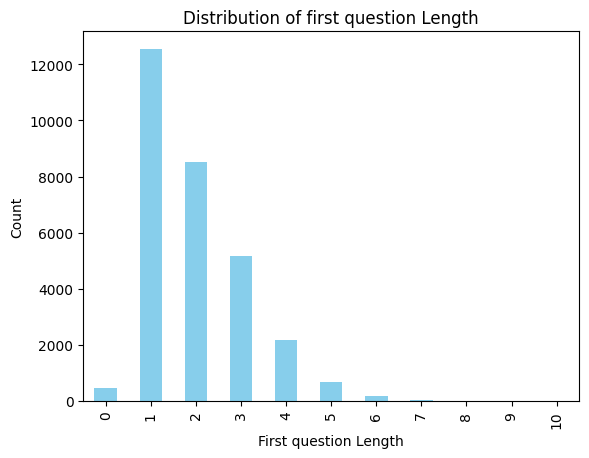

In [679]:
df_ema['first_question_length'].value_counts().sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('First question Length')
plt.ylabel('Count')
plt.title('Distribution of first question Length')
plt.show()


In [680]:
df_ema['first_question_length'].value_counts()

first_question_length
1     12542
2      8507
3      5179
4      2182
5       664
0       471
6       179
7        49
8        19
9         3
10        2
Name: count, dtype: int64

In [681]:
df_ema['length_zero_no_careless_one_point_five'].value_counts()

length_zero_no_careless_one_point_five
0.0    28928
1.0      470
Name: count, dtype: int64

In [682]:
df_ema['length_zero_no_careless_one'].value_counts()

length_zero_no_careless_one
0.0    29242
1.0      471
Name: count, dtype: int64

In [683]:
df_ema['length_zero_no_careless_two'].value_counts()

length_zero_no_careless_two
0.0    27958
1.0      462
Name: count, dtype: int64

In [684]:
df_ema['nothing_no_careless_two_nulllength'].value_counts()

nothing_no_careless_two_nulllength
0.0    27070
1.0     1350
Name: count, dtype: int64

In [685]:
df_ema['nothing_no_careless_one_nulllength'].value_counts()

nothing_no_careless_one_nulllength
0.0    28293
1.0     1420
Name: count, dtype: int64

In [686]:
df_ema['nothing_no_careless_one_point_five_nulllength'].value_counts()

nothing_no_careless_one_point_five_nulllength
0.0    27994
1.0     1404
Name: count, dtype: int64

In [687]:
df_tpi['subject_id_roman_x'].nunique()

617

#### Final participants count

In [688]:
df_time_comp_no_respona['subject_id_roman_x'].nunique()

593

In [689]:
len(df_time_comp_no_respona)

12034

In [690]:
df_time_comp['subject_id_roman_x'].nunique()

617

In [691]:
df_tpi['subject_id_roman_x'].nunique()

617

In [692]:
len(df_tpi)

29797

In [693]:
df_no_lapro_noobsc_no_null_nepro_comp['subject_id_roman_x'].nunique()

617

In [694]:
len(df_no_lapro_noobsc_no_null_nepro_comp)

22817

In [695]:
df_no_lapro_noobsc['subject_id_roman_x'].nunique()

617

In [696]:
len(df_no_lapro_noobsc)

24854

In [697]:
df_time_comp_no_respona.head()

subject_id_roman_x         issued_time  response delay  \
89      2023006-00146A 2022-01-21 20:32:54         362.367   
108     2023006-00508A 2022-01-19 09:07:30          33.712   
110     2023006-00508A 2022-01-19 13:46:58         428.002   
112     2023006-00508A 2022-01-19 18:20:34         138.364   
113     2023006-00508A 2022-01-19 21:12:45          51.784   

     response_delay_10min  compliance  completion_time  \
89                362.367           1             59.0   
108                33.712           1            413.0   
110               428.002           1             35.0   
112               138.364           1             74.0   
113                51.784           1            192.0   

    time_of_the_day_categories_dummy  \
89                               NaN   
108                                1   
110                                3   
112                                5   
113                              NaN   

    time_of_the_day_categories_dummy_no_last_p  sleep_quality  stress  hunger  \
89                                         NaN            1.0     2.0     1.0   
108                                          1            5.0     1.0     1.0   
110                                          3            5.0     2.0     1.0   
112                                        NaN            5.0     2.0     3.0   
113                                        NaN            5.0     1.0     1.0   

     fatigue  affect  number_of_survey  day_of_monitoring  day_of_the_week  \
89       4.0     2.0                36                6.0                5   
108      1.0     5.0                 1                1.0                3   
110      2.0     4.0                 3                1.0                3   
112      2.0     5.0                 5                1.0                3   
113      2.0     6.0                 6                1.0                3   

     day_of_the_week_dummy  incentive_category  survey_length  \
89                     5.0                   1             11   
108                    3.0                   1             25   
110                    3.0                   1              2   
112                    3.0                   1              4   
113                    3.0                   1             17   

     first_question_length  location_current_ordinal  \
89                       2                       NaN   
108                      4                       NaN   
110                      2                       NaN   
112                      2                       5.0   
113                      4                       NaN   

     location_current_commute  location_current_green_spaces  \
89                      False                          False   
108                     False                          False   
110                     False                          False   
112                     False                          False   
113                     False                          False   

     location_current_home  location_current_home_outside  \
89                   False                          False   
108                  False                          False   
110                  False                          False   
112                  False                           True   
113                  False                          False   

     location_current_indoors_elsewhere  location_current_other  \
89                                False                   False   
108                               False                   False   
110                               False                   False   
112                               False                   False   
113                               False                   False   

     time_of_day_8_to_930  time_of_day_1030_to_12  time_of_day_13_to_1430  \
89                  False                   False                   False   
108                  True                   Fals

#### Calculate average age and gender for the included participants

In [698]:
avg_age = df_no_lapro_noobsc.groupby('subject_id_roman_x')['age'].mean()

# Calculating the overall average age
overall_avg_age = avg_age.mean()

# Calculating the standard deviation of average ages
std_avg_age = avg_age.std()

# Displaying the results
print("Overall Average Age:", overall_avg_age)
print("Standard Deviation of Average Age:", std_avg_age)

Overall Average Age: 21.18800648298217
Standard Deviation of Average Age: 14.15969857427211


In [699]:
avg_age = df_no_lapro_noobsc.groupby('subject_id_roman_x')['age'].mean()

# Finding the minimum and maximum average ages
min_avg_age = avg_age.min()
max_avg_age = avg_age.max()

# Displaying the results
print("Minimum Average Age:", min_avg_age)
print("Maximum Average Age:", max_avg_age)

Minimum Average Age: 1.0
Maximum Average Age: 49.0


In [700]:
gender_distribution = df_no_lapro_noobsc.groupby('subject_id_roman_x')['gender'].unique()

# Counting occurrences of 0 (male) and 1 (female) in the gender column
male_count = (gender_distribution.apply(lambda x: 0 in x)).sum()
female_count = (gender_distribution.apply(lambda x: 1 in x)).sum()

# Displaying the results
print("Male Count:", male_count)
print("Female Count:", female_count)

Male Count: 211
Female Count: 406
